In [1]:
!nvidia-smi

Thu Feb 29 11:10:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |    982MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M13mfcc as M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m13mfcc128.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 128, 'n_fft': 1024, 'hop_length': 128, 'n_mels': 128, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [18]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006557377049180328/10 [00:00<12:33, 75.36s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.334363
Mem before-during-after: 1660928 10332672 22687232


  1%|▍                                  | 0.13770491803278687/10 [00:07<08:15, 50.27s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.396143
Mem before-during-after: 22687232 22838272 22687232


  3%|▉                                  | 0.26885245901639304/10 [00:14<08:30, 52.48s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.089031
Mem before-during-after: 22687232 22838272 22687232


  4%|█▌                                    | 0.39672131147541/10 [00:21<08:11, 51.16s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.092434
Mem before-during-after: 22687232 22838272 22687232


  5%|█▉                                  | 0.5311475409836068/10 [00:28<08:37, 54.64s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.474794
Mem before-during-after: 22687232 22838272 22687232


  7%|██▍                                 | 0.6622950819672118/10 [00:35<08:03, 51.81s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.207385
Mem before-during-after: 22687232 22838272 22687232


  8%|██▊                                 | 0.7934426229508167/10 [00:41<07:54, 51.56s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.973476
Mem before-during-after: 22687232 22838272 22687232


 10%|███▌                                | 1.0032786885245846/10 [00:52<07:38, 51.01s/it]


Test Epoch: 1	Accuracy: 465/976 (47%)

Train Epoch: 2 [0/3918 (0%)]	Loss: 1.104145
Mem before-during-after: 22686208 22838272 22687232


 11%|████                                | 1.1377049180327796/10 [00:59<07:22, 49.94s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.034490
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                               | 1.2688524590163845/10 [01:06<07:08, 49.11s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 1.030220
Mem before-during-after: 22687232 22838272 22687232


 14%|█████                               | 1.3999999999999895/10 [01:13<07:21, 51.38s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.996787
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▌                              | 1.5311475409835944/10 [01:20<06:56, 49.24s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.043928
Mem before-during-after: 22687232 22838272 22687232


 17%|█████▉                              | 1.6622950819671993/10 [01:26<07:08, 51.41s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 0.802484
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▍                             | 1.7934426229508043/10 [01:33<07:31, 54.96s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.220492
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                            | 2.0032786885245724/10 [01:44<06:48, 51.08s/it]


Test Epoch: 2	Accuracy: 521/976 (53%)

Train Epoch: 3 [0/3918 (0%)]	Loss: 1.336824
Mem before-during-after: 22686208 22838272 22687232


 21%|███████▋                            | 2.1377049180327674/10 [01:51<06:38, 50.73s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 0.867724
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▏                           | 2.2688524590163723/10 [01:58<06:41, 51.96s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 0.911795
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▋                           | 2.3999999999999773/10 [02:04<06:57, 54.97s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 0.898289
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████▎                           | 2.531147540983582/10 [02:11<06:12, 49.89s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 0.725931
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▊                           | 2.662295081967187/10 [02:18<06:03, 49.56s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 1.264799
Mem before-during-after: 22687232 22838272 22687232


 28%|██████████▎                          | 2.793442622950792/10 [02:25<06:26, 53.62s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.886820
Mem before-during-after: 22687232 22838272 22687232


 30%|███████████▍                          | 3.00327868852456/10 [02:35<06:06, 52.38s/it]


Test Epoch: 3	Accuracy: 498/976 (51%)

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.982903
Mem before-during-after: 22686208 22838272 22687232


 31%|███████████▌                         | 3.137704918032755/10 [02:42<06:09, 53.83s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 0.952071
Mem before-during-after: 22687232 22838272 22687232


 33%|████████████▍                         | 3.26885245901636/10 [02:49<05:58, 53.32s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 1.061004
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████▌                        | 3.399999999999965/10 [02:56<05:31, 50.27s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 1.026925
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▋                       | 3.5311475409835698/10 [03:02<05:25, 50.37s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 1.044252
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▏                      | 3.6622950819671747/10 [03:09<05:12, 49.32s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.112298
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▋                      | 3.7934426229507796/10 [03:16<05:09, 49.87s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 0.900223
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▍                     | 3.9999999999999574/10 [03:26<05:05, 50.89s/it]


Test Epoch: 4	Accuracy: 517/976 (53%)

Train Epoch: 5 [0/3918 (0%)]	Loss: 0.734502
Mem before-during-after: 22686208 22838272 22687232


 41%|██████████████▉                     | 4.1377049180327425/10 [03:34<04:52, 49.91s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 1.129526
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▎                    | 4.2688524590163475/10 [03:41<05:05, 53.22s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 1.323489
Mem before-during-after: 22687232 22838272 22687232


 44%|████████████████▎                    | 4.399999999999952/10 [03:47<04:38, 49.73s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.055837
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▊                    | 4.531147540983557/10 [03:54<04:35, 50.41s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 1.257299
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████▎                   | 4.662295081967162/10 [04:01<04:37, 51.93s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 0.835211
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████▋                   | 4.793442622950767/10 [04:08<04:23, 50.63s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 1.046769
Mem before-during-after: 22687232 22838272 22687232


 50%|██████████████████▌                  | 5.003278688524535/10 [04:19<04:04, 49.01s/it]


Test Epoch: 5	Accuracy: 501/976 (51%)

Train Epoch: 6 [0/3918 (0%)]	Loss: 0.973376
Mem before-during-after: 22686208 22838272 22687232


 51%|███████████████████▌                  | 5.13770491803273/10 [04:25<04:02, 49.83s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 1.363222
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▍                 | 5.268852459016335/10 [04:33<03:51, 48.94s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 0.964701
Mem before-during-after: 22687232 22838272 22687232


 54%|████████████████████▌                 | 5.39999999999994/10 [04:39<04:00, 52.37s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 0.843993
Mem before-during-after: 22687232 22838272 22687232


 55%|████████████████████▍                | 5.531147540983545/10 [04:46<03:38, 49.00s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 1.038962
Mem before-during-after: 22687232 22838272 22687232


 57%|█████████████████████▌                | 5.66229508196715/10 [04:52<03:31, 48.82s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 0.948568
Mem before-during-after: 22687232 22838272 22687232


 58%|█████████████████████▍               | 5.793442622950755/10 [04:59<03:23, 48.37s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 1.396620
Mem before-during-after: 22687232 22838272 22687232


 60%|██████████████████████▏              | 6.003278688524523/10 [05:09<03:14, 48.71s/it]


Test Epoch: 6	Accuracy: 543/976 (55%)

Train Epoch: 7 [0/3918 (0%)]	Loss: 0.828885
Mem before-during-after: 22686208 22838272 22687232


 61%|██████████████████████▋              | 6.137704918032718/10 [05:16<03:08, 48.87s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 0.831572
Mem before-during-after: 22687232 22838272 22687232


 63%|███████████████████████▏             | 6.268852459016323/10 [05:22<03:05, 49.71s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 1.092614
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████             | 6.3999999999999275/10 [05:29<02:56, 48.99s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 0.780800
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▌            | 6.5311475409835325/10 [05:36<02:49, 48.89s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 1.041005
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▋            | 6.662295081967137/10 [05:42<02:56, 52.84s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.791390
Mem before-during-after: 22687232 22838272 22687232


 68%|█████████████████████████▏           | 6.793442622950742/10 [05:49<02:43, 51.06s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 0.848259
Mem before-during-after: 22687232 22838272 22687232


 70%|██████████████████████████▌           | 7.00327868852451/10 [05:59<02:26, 48.96s/it]


Test Epoch: 7	Accuracy: 560/976 (57%)

Train Epoch: 8 [0/3918 (0%)]	Loss: 0.813908
Mem before-during-after: 22686208 22838272 22687232


 71%|██████████████████████████▍          | 7.137704918032705/10 [06:06<02:21, 49.53s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 0.867990
Mem before-during-after: 22687232 22838272 22687232


 73%|███████████████████████████▌          | 7.26885245901631/10 [06:12<02:16, 49.91s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 0.737784
Mem before-during-after: 22687232 22838272 22687232


 74%|███████████████████████████▍         | 7.399999999999915/10 [06:19<02:08, 49.39s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 0.725299
Mem before-during-after: 22687232 22838272 22687232


 75%|████████████████████████████▌         | 7.53114754098352/10 [06:25<02:00, 48.91s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.665094
Mem before-during-after: 22687232 22838272 22687232


 77%|████████████████████████████▎        | 7.662295081967125/10 [06:32<01:51, 47.89s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 0.742424
Mem before-during-after: 22687232 22838272 22687232


 78%|█████████████████████████████▌        | 7.79344262295073/10 [06:38<01:47, 48.60s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 1.009915
Mem before-during-after: 22687232 22838272 22687232


 80%|█████████████████████████████▌       | 8.003278688524498/10 [06:49<01:43, 51.69s/it]


Test Epoch: 8	Accuracy: 565/976 (58%)

Train Epoch: 9 [0/3918 (0%)]	Loss: 0.466854
Mem before-during-after: 22686208 22838272 22687232


 81%|██████████████████████████████       | 8.137704918032693/10 [06:55<01:30, 48.47s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 0.819655
Mem before-during-after: 22687232 22838272 22687232


 83%|██████████████████████████████▌      | 8.268852459016298/10 [07:02<01:24, 48.66s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 0.975782
Mem before-during-after: 22687232 22838272 22687232


 84%|███████████████████████████████      | 8.399999999999903/10 [07:08<01:18, 48.93s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 1.006484
Mem before-during-after: 22687232 22838272 22687232


 85%|███████████████████████████████▌     | 8.531147540983508/10 [07:15<01:11, 48.66s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 1.164607
Mem before-during-after: 22687232 22838272 22687232


 87%|████████████████████████████████     | 8.662295081967113/10 [07:21<01:09, 51.91s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 0.621510
Mem before-during-after: 22687232 22838272 22687232


 88%|████████████████████████████████▌    | 8.793442622950717/10 [07:28<00:58, 48.66s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 0.952277
Mem before-during-after: 22687232 22838272 22687232


 90%|█████████████████████████████████▎   | 9.003278688524485/10 [07:38<00:49, 49.20s/it]


Test Epoch: 9	Accuracy: 501/976 (51%)

Train Epoch: 10 [0/3918 (0%)]	Loss: 1.124888
Mem before-during-after: 22686208 22838272 22687232


 91%|██████████████████████████████████▋   | 9.13770491803268/10 [07:45<00:41, 48.10s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 0.819053
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▎  | 9.268852459016285/10 [07:52<00:35, 49.22s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 1.076177
Mem before-during-after: 22687232 22838272 22687232


 94%|███████████████████████████████████▋  | 9.39999999999989/10 [07:58<00:29, 49.80s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 0.802018
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▎ | 9.531147540983495/10 [08:05<00:24, 51.22s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 0.857644
Mem before-during-after: 22687232 22838272 22687232


 97%|█████████████████████████████████████▋ | 9.6622950819671/10 [08:11<00:16, 48.51s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 1.063833
Mem before-during-after: 22687232 22838272 22687232


 98%|████████████████████████████████████▏| 9.793442622950705/10 [08:18<00:10, 51.41s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 0.634640
Mem before-during-after: 22687232 22838272 22687232


100%|████████████████████████████████████▉| 9.999999999999883/10 [08:28<00:00, 50.85s/it]


Test Epoch: 10	Accuracy: 539/976 (55%)



In [22]:
model_path = '../models_cremad4/cremad_label4_m13mfcc128_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13mfcc128_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/50 [00:00<40:18, 48.37s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 0.842146
Mem before-during-after: 20028928 20180992 22687232


  0%|                                   | 0.13770491803278687/50 [00:06<40:38, 48.91s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 0.825620
Mem before-during-after: 22687232 22838272 22687232


  1%|▏                                  | 0.26885245901639304/50 [00:13<41:10, 49.67s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.034027
Mem before-during-after: 22687232 22838272 22687232


  1%|▎                                   | 0.4000000000000002/50 [00:19<40:13, 48.65s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 0.710899
Mem before-during-after: 22687232 22838272 22687232


  1%|▍                                   | 0.5311475409836068/50 [00:26<40:06, 48.65s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 1.341893
Mem before-during-after: 22687232 22838272 22687232


  1%|▍                                   | 0.6622950819672118/50 [00:32<39:39, 48.23s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 1.031684
Mem before-during-after: 22687232 22838272 22687232


  2%|▌                                   | 0.7934426229508167/50 [00:39<40:32, 49.42s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 0.937522
Mem before-during-after: 22687232 22838272 22687232


  2%|▋                                   | 1.0032786885245846/50 [00:49<39:31, 48.39s/it]


Test Epoch: 11	Accuracy: 580/976 (59%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_11epoch.pt
Train Epoch: 12 [0/3918 (0%)]	Loss: 0.865484
Mem before-during-after: 22686208 22838272 22687232


  2%|▊                                   | 1.1377049180327796/50 [00:56<39:53, 48.99s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 1.109918
Mem before-during-after: 22687232 22838272 22687232


  3%|▉                                   | 1.2688524590163845/50 [01:02<39:42, 48.89s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 0.847764
Mem before-during-after: 22687232 22838272 22687232


  3%|█                                   | 1.3999999999999895/50 [01:09<40:28, 49.98s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.526524
Mem before-during-after: 22687232 22838272 22687232


  3%|█                                   | 1.5311475409835944/50 [01:16<40:19, 49.93s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.845622
Mem before-during-after: 22687232 22838272 22687232


  3%|█▏                                  | 1.6622950819671993/50 [01:22<40:33, 50.34s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 0.933389
Mem before-during-after: 22687232 22838272 22687232


  4%|█▎                                  | 1.7934426229508043/50 [01:29<39:53, 49.64s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 0.456227
Mem before-during-after: 22687232 22838272 22687232


  4%|█▍                                  | 2.0032786885245724/50 [01:39<39:35, 49.49s/it]


Test Epoch: 12	Accuracy: 584/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_12epoch.pt
Train Epoch: 13 [0/3918 (0%)]	Loss: 0.716682
Mem before-during-after: 22686208 22838272 22687232


  4%|█▌                                  | 2.1377049180327674/50 [01:46<39:20, 49.32s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 0.934809
Mem before-during-after: 22687232 22838272 22687232


  5%|█▋                                  | 2.2688524590163723/50 [01:52<39:13, 49.31s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.434434
Mem before-during-after: 22687232 22838272 22687232


  5%|█▋                                  | 2.3999999999999773/50 [01:59<38:22, 48.37s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 0.751803
Mem before-during-after: 22687232 22838272 22687232


  5%|█▊                                   | 2.531147540983582/50 [02:05<38:54, 49.17s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 0.926148
Mem before-during-after: 22687232 22838272 22687232


  5%|█▉                                   | 2.662295081967187/50 [02:12<38:44, 49.10s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 0.818471
Mem before-during-after: 22687232 22838272 22687232


  6%|██                                   | 2.793442622950792/50 [02:18<38:19, 48.71s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 0.638550
Mem before-during-after: 22687232 22838272 22687232


  6%|██▎                                   | 3.00327868852456/50 [02:28<38:40, 49.38s/it]


Test Epoch: 13	Accuracy: 588/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_13epoch.pt
Train Epoch: 14 [0/3918 (0%)]	Loss: 0.904720
Mem before-during-after: 22686208 22838272 22687232


  6%|██▎                                  | 3.137704918032755/50 [02:35<39:20, 50.37s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 0.542539
Mem before-during-after: 22687232 22838272 22687232


  7%|██▍                                   | 3.26885245901636/50 [02:42<38:12, 49.05s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.627234
Mem before-during-after: 22687232 22838272 22687232


  7%|██▌                                  | 3.399999999999965/50 [02:48<38:07, 49.10s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 0.690708
Mem before-during-after: 22687232 22838272 22687232


  7%|██▌                                 | 3.5311475409835698/50 [02:55<39:43, 51.29s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 0.607950
Mem before-during-after: 22687232 22838272 22687232


  7%|██▋                                 | 3.6622950819671747/50 [03:01<36:52, 47.75s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.936158
Mem before-during-after: 22687232 22838272 22687232


  8%|██▋                                 | 3.7934426229507796/50 [03:08<37:27, 48.64s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 0.544128
Mem before-during-after: 22687232 22838272 22687232


  8%|██▉                                 | 4.0032786885245475/50 [03:18<37:14, 48.58s/it]


Test Epoch: 14	Accuracy: 596/976 (61%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_14epoch.pt
Train Epoch: 15 [0/3918 (0%)]	Loss: 0.468211
Mem before-during-after: 22686208 22838272 22687232


  8%|███                                  | 4.134426229508152/50 [03:24<39:26, 51.60s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 0.611975
Mem before-during-after: 22687232 22838272 22687232


  9%|███                                 | 4.2688524590163475/50 [03:31<38:21, 50.32s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.749654
Mem before-during-after: 22687232 22838272 22687232


  9%|███▎                                 | 4.399999999999952/50 [03:38<36:46, 48.39s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 0.868632
Mem before-during-after: 22687232 22838272 22687232


  9%|███▎                                 | 4.531147540983557/50 [03:44<36:35, 48.28s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.571860
Mem before-during-after: 22687232 22838272 22687232


  9%|███▍                                 | 4.662295081967162/50 [03:51<37:05, 49.08s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 0.753331
Mem before-during-after: 22687232 22838272 22687232


 10%|███▌                                 | 4.793442622950767/50 [03:57<36:41, 48.69s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.860420
Mem before-during-after: 22687232 22838272 22687232


 10%|███▋                                 | 5.003278688524535/50 [04:07<35:48, 47.76s/it]


Test Epoch: 15	Accuracy: 585/976 (60%)

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.558924
Mem before-during-after: 22686208 22838272 22687232


 10%|███▉                                  | 5.13770491803273/50 [04:14<36:48, 49.24s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 1.082299
Mem before-during-after: 22687232 22838272 22687232


 11%|███▉                                 | 5.268852459016335/50 [04:21<36:56, 49.56s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 0.717838
Mem before-during-after: 22687232 22838272 22687232


 11%|████                                  | 5.39999999999994/50 [04:27<36:23, 48.96s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 0.713900
Mem before-during-after: 22687232 22838272 22687232


 11%|████                                 | 5.531147540983545/50 [04:33<36:03, 48.66s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 0.799701
Mem before-during-after: 22687232 22838272 22687232


 11%|████▎                                 | 5.66229508196715/50 [04:40<35:34, 48.14s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 1.064068
Mem before-during-after: 22687232 22838272 22687232


 12%|████▎                                | 5.793442622950755/50 [04:46<35:22, 48.01s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.646639
Mem before-during-after: 22687232 22838272 22687232


 12%|████▍                                | 6.003278688524523/50 [04:57<35:08, 47.93s/it]


Test Epoch: 16	Accuracy: 598/976 (61%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_16epoch.pt
Train Epoch: 17 [0/3918 (0%)]	Loss: 1.118661
Mem before-during-after: 22686208 22838272 22687232


 12%|████▌                                | 6.137704918032718/50 [05:03<34:49, 47.65s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 0.601305
Mem before-during-after: 22687232 22838272 22687232


 13%|████▋                                | 6.268852459016323/50 [05:10<35:52, 49.22s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 0.903901
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                               | 6.3999999999999275/50 [05:16<35:13, 48.47s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.768190
Mem before-during-after: 22687232 22838272 22687232


 13%|████▋                               | 6.5311475409835325/50 [05:23<35:13, 48.63s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 0.638845
Mem before-during-after: 22687232 22838272 22687232


 13%|████▉                                | 6.662295081967137/50 [05:29<35:20, 48.93s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 0.608504
Mem before-during-after: 22687232 22838272 22687232


 14%|█████                                | 6.793442622950742/50 [05:36<35:35, 49.42s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 0.395236
Mem before-during-after: 22687232 22838272 22687232


 14%|█████▎                                | 7.00327868852451/50 [05:46<36:06, 50.38s/it]


Test Epoch: 17	Accuracy: 596/976 (61%)

Train Epoch: 18 [0/3918 (0%)]	Loss: 0.722949
Mem before-during-after: 22686208 22838272 22687232


 14%|█████▎                               | 7.137704918032705/50 [05:52<35:41, 49.96s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 0.363842
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▌                                | 7.26885245901631/50 [05:59<34:36, 48.59s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 0.797884
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▍                               | 7.399999999999915/50 [06:05<34:41, 48.87s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 0.580067
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▋                                | 7.53114754098352/50 [06:12<34:23, 48.58s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.590615
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▋                               | 7.662295081967125/50 [06:18<34:39, 49.11s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 1.079052
Mem before-during-after: 22687232 22838272 22687232


 16%|█████▉                                | 7.79344262295073/50 [06:25<34:14, 48.68s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 0.616032
Mem before-during-after: 22687232 22838272 22687232


 16%|█████▉                               | 8.003278688524498/50 [06:35<35:16, 50.39s/it]


Test Epoch: 18	Accuracy: 582/976 (59%)

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.756758
Mem before-during-after: 22686208 22838272 22687232


 16%|██████                               | 8.137704918032693/50 [06:42<34:18, 49.18s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 0.525874
Mem before-during-after: 22687232 22838272 22687232


 17%|██████                               | 8.268852459016298/50 [06:48<34:52, 50.15s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 0.868610
Mem before-during-after: 22687232 22838272 22687232


 17%|██████▏                              | 8.399999999999903/50 [06:55<34:45, 50.12s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.749015
Mem before-during-after: 22687232 22838272 22687232


 17%|██████▎                              | 8.531147540983508/50 [07:01<33:39, 48.70s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 0.720452
Mem before-during-after: 22687232 22838272 22687232


 17%|██████▍                              | 8.662295081967113/50 [07:08<33:08, 48.10s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 0.543509
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▌                              | 8.793442622950717/50 [07:14<33:18, 48.49s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 0.547981
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▋                              | 9.003278688524485/50 [07:24<32:31, 47.61s/it]


Test Epoch: 19	Accuracy: 593/976 (61%)

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.503572
Mem before-during-after: 22686208 22838272 22687232


 18%|██████▉                               | 9.13770491803268/50 [07:31<33:09, 48.69s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.548936
Mem before-during-after: 22687232 22838272 22687232


 19%|██████▊                              | 9.268852459016285/50 [07:37<34:02, 50.14s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.448210
Mem before-during-after: 22687232 22838272 22687232


 19%|███████▏                              | 9.39999999999989/50 [07:44<32:39, 48.27s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 0.932389
Mem before-during-after: 22687232 22838272 22687232


 19%|███████                              | 9.531147540983495/50 [07:51<34:24, 51.01s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.827577
Mem before-during-after: 22687232 22838272 22687232


 19%|███████▌                               | 9.6622950819671/50 [07:57<32:38, 48.56s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.774394
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                             | 9.793442622950705/50 [08:04<35:09, 52.47s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 0.839466
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                            | 10.003278688524473/50 [08:14<32:26, 48.66s/it]


Test Epoch: 20	Accuracy: 592/976 (60%)

Train Epoch: 21 [0/3918 (0%)]	Loss: 0.639572
Mem before-during-after: 22686208 22838272 22687232


 20%|███████▎                            | 10.137704918032668/50 [08:20<32:32, 48.99s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 0.832981
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▍                            | 10.268852459016273/50 [08:27<33:18, 50.30s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 0.682690
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▍                            | 10.399999999999878/50 [08:33<31:44, 48.10s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 0.689903
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▌                            | 10.531147540983483/50 [08:40<31:50, 48.40s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 0.510136
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▋                            | 10.662295081967088/50 [08:46<32:35, 49.71s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 0.647754
Mem before-during-after: 22687232 22838272 22687232


 22%|███████▊                            | 10.793442622950693/50 [08:53<32:49, 50.23s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 0.957714
Mem before-during-after: 22687232 22838272 22687232


 22%|████████▏                            | 11.00327868852446/50 [09:03<31:25, 48.36s/it]


Test Epoch: 21	Accuracy: 603/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_21epoch.pt
Train Epoch: 22 [0/3918 (0%)]	Loss: 0.512292
Mem before-during-after: 22686208 22838272 22687232


 22%|████████                            | 11.137704918032655/50 [09:10<31:12, 48.19s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.628672
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▎                            | 11.26885245901626/50 [09:16<31:57, 49.51s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 0.621519
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▏                           | 11.399999999999865/50 [09:23<31:10, 48.46s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 0.741745
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▌                            | 11.53114754098347/50 [09:29<30:45, 47.98s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.892125
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▍                           | 11.662295081967075/50 [09:36<33:19, 52.16s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.417557
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▋                            | 11.79344262295068/50 [09:42<30:10, 47.38s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 0.641569
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▋                           | 12.003278688524448/50 [09:52<30:02, 47.44s/it]


Test Epoch: 22	Accuracy: 606/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_22epoch.pt
Train Epoch: 23 [0/3918 (0%)]	Loss: 0.517096
Mem before-during-after: 22686208 22838272 22687232


 24%|████████▋                           | 12.137704918032643/50 [09:59<31:25, 49.80s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.579496
Mem before-during-after: 22687232 22838272 22687232


 25%|████████▊                           | 12.268852459016248/50 [10:06<31:32, 50.16s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.445895
Mem before-during-after: 22687232 22838272 22687232


 25%|████████▉                           | 12.399999999999853/50 [10:12<31:02, 49.54s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 0.757055
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████                           | 12.531147540983458/50 [10:18<30:08, 48.26s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.571544
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████                           | 12.662295081967063/50 [10:25<30:37, 49.21s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.670287
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████▏                          | 12.793442622950668/50 [10:31<30:08, 48.60s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.592907
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████▎                          | 13.003278688524436/50 [10:42<29:45, 48.26s/it]


Test Epoch: 23	Accuracy: 608/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_23epoch.pt
Train Epoch: 24 [0/3918 (0%)]	Loss: 1.134705
Mem before-during-after: 22686208 22838272 22687232


 26%|█████████▋                           | 13.13770491803263/50 [10:48<31:13, 50.82s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 0.717198
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▌                          | 13.268852459016236/50 [10:55<29:32, 48.25s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.702008
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▉                           | 13.39999999999984/50 [11:01<29:43, 48.74s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 0.647494
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▋                          | 13.531147540983445/50 [11:08<30:22, 49.98s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 0.536911
Mem before-during-after: 22687232 22838272 22687232


 27%|██████████                           | 13.66229508196705/50 [11:14<29:49, 49.24s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 0.517225
Mem before-during-after: 22687232 22838272 22687232


 28%|█████████▉                          | 13.793442622950655/50 [11:21<29:08, 48.30s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 0.404389
Mem before-during-after: 22687232 22838272 22687232


 28%|██████████                          | 14.003278688524423/50 [11:31<29:54, 49.86s/it]


Test Epoch: 24	Accuracy: 596/976 (61%)

Train Epoch: 25 [0/3918 (0%)]	Loss: 0.679268
Mem before-during-after: 22686208 22838272 22687232


 28%|██████████▏                         | 14.137704918032618/50 [11:38<29:24, 49.21s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.769384
Mem before-during-after: 22687232 22838272 22687232


 29%|██████████▎                         | 14.268852459016223/50 [11:44<28:52, 48.49s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 0.642536
Mem before-during-after: 22687232 22838272 22687232


 29%|██████████▎                         | 14.399999999999828/50 [11:51<28:47, 48.53s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 0.240173
Mem before-during-after: 22687232 22838272 22687232


 29%|██████████▍                         | 14.531147540983433/50 [11:57<28:34, 48.35s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.497147
Mem before-during-after: 22687232 22838272 22687232


 29%|██████████▌                         | 14.662295081967038/50 [12:04<29:05, 49.40s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.657726
Mem before-during-after: 22687232 22838272 22687232


 30%|██████████▋                         | 14.793442622950643/50 [12:10<28:52, 49.21s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 0.522309
Mem before-during-after: 22687232 22838272 22687232


 30%|███████████                          | 15.00327868852441/50 [12:20<28:08, 48.24s/it]


Test Epoch: 25	Accuracy: 608/976 (62%)

Train Epoch: 26 [0/3918 (0%)]	Loss: 0.491815
Mem before-during-after: 22686208 22838272 22687232


 30%|██████████▉                         | 15.137704918032606/50 [12:27<28:15, 48.65s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.894015
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████▎                         | 15.26885245901621/50 [12:33<28:32, 49.32s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 1.159307
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████                         | 15.399999999999816/50 [12:40<28:08, 48.79s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.557925
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████▍                         | 15.53114754098342/50 [12:46<28:02, 48.81s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.689265
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████▎                        | 15.662295081967025/50 [12:53<28:01, 48.97s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 0.692756
Mem before-during-after: 22687232 22838272 22687232


 32%|███████████▋                         | 15.79344262295063/50 [13:00<28:47, 50.51s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 0.597993
Mem before-during-after: 22687232 22838272 22687232


 32%|████████████▏                         | 16.0032786885244/50 [13:10<27:17, 48.16s/it]


Test Epoch: 26	Accuracy: 591/976 (60%)

Train Epoch: 27 [0/3918 (0%)]	Loss: 0.485139
Mem before-during-after: 22686208 22838272 22687232


 32%|███████████▌                        | 16.137704918032668/50 [13:16<27:10, 48.15s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.483280
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▋                        | 16.268852459016344/50 [13:23<27:42, 49.30s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.419584
Mem before-during-after: 22687232 22838272 22687232


 33%|████████████▏                        | 16.40000000000002/50 [13:29<27:53, 49.80s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.544704
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▉                        | 16.531147540983696/50 [13:36<27:16, 48.91s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 0.716017
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▉                        | 16.662295081967372/50 [13:42<26:52, 48.37s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.718959
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████                        | 16.793442622951048/50 [13:49<27:11, 49.14s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 0.527556
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████▌                        | 17.00327868852493/50 [13:59<26:44, 48.62s/it]


Test Epoch: 27	Accuracy: 598/976 (61%)

Train Epoch: 28 [0/3918 (0%)]	Loss: 0.504758
Mem before-during-after: 22686208 22838272 22687232


 34%|████████████▎                       | 17.137704918033197/50 [14:06<26:49, 48.99s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 0.520343
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▊                        | 17.26557377049228/50 [14:12<26:53, 49.28s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.336809
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▉                        | 17.40000000000055/50 [14:19<27:04, 49.84s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 0.555851
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▌                       | 17.531147540984225/50 [14:25<26:17, 48.57s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.830000
Mem before-during-after: 22687232 22838272 22687232


 35%|█████████████▍                        | 17.6622950819679/50 [14:32<26:13, 48.66s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 0.465113
Mem before-during-after: 22687232 22838272 22687232


 36%|████████████▊                       | 17.793442622951577/50 [14:38<26:29, 49.36s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 0.590112
Mem before-during-after: 22687232 22838272 22687232


 36%|█████████████▎                       | 18.00327868852546/50 [14:48<25:35, 47.98s/it]


Test Epoch: 28	Accuracy: 592/976 (60%)

Train Epoch: 29 [0/3918 (0%)]	Loss: 0.430584
Mem before-during-after: 22686208 22838272 22687232


 36%|█████████████                       | 18.137704918033727/50 [14:55<26:05, 49.12s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 0.245513
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▏                      | 18.268852459017403/50 [15:02<25:49, 48.82s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 0.422190
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▌                       | 18.40000000000108/50 [15:08<25:40, 48.74s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.480766
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▎                      | 18.531147540984755/50 [15:14<25:39, 48.92s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 1.118508
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▊                       | 18.66229508196843/50 [15:21<24:57, 47.79s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 0.311878
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▌                      | 18.793442622952107/50 [15:27<25:36, 49.23s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.645581
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▋                      | 19.003278688525988/50 [15:38<24:57, 48.30s/it]


Test Epoch: 29	Accuracy: 597/976 (61%)

Train Epoch: 30 [0/3918 (0%)]	Loss: 0.646966
Mem before-during-after: 22686208 22838272 22687232


 38%|█████████████▊                      | 19.137704918034256/50 [15:44<25:01, 48.65s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.590318
Mem before-during-after: 22687232 22838272 22687232


 39%|█████████████▊                      | 19.268852459017932/50 [15:51<25:43, 50.23s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 0.661670
Mem before-during-after: 22687232 22838272 22687232


 39%|█████████████▉                      | 19.400000000001608/50 [15:57<24:40, 48.38s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 0.708792
Mem before-during-after: 22687232 22838272 22687232


 39%|██████████████                      | 19.531147540985284/50 [16:04<24:58, 49.18s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.547273
Mem before-during-after: 22687232 22838272 22687232


 39%|██████████████▌                      | 19.66229508196896/50 [16:10<24:50, 49.13s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 0.336855
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▎                     | 19.793442622952636/50 [16:17<24:05, 47.86s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 0.419471
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▍                     | 20.003278688526517/50 [16:27<24:21, 48.73s/it]


Test Epoch: 30	Accuracy: 600/976 (61%)

Train Epoch: 31 [0/3918 (0%)]	Loss: 0.434020
Mem before-during-after: 22686208 22838272 22687232


 40%|██████████████▍                     | 20.137704918034785/50 [16:34<25:08, 50.52s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.286453
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▉                      | 20.26885245901846/50 [16:40<23:45, 47.94s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 0.250493
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▋                     | 20.400000000002137/50 [16:46<24:05, 48.82s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 0.593944
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▊                     | 20.531147540985813/50 [16:53<24:49, 50.54s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 0.570633
Mem before-during-after: 22687232 22838272 22687232


 41%|███████████████▎                     | 20.66229508196949/50 [16:59<24:03, 49.19s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.318255
Mem before-during-after: 22687232 22838272 22687232


 42%|██████████████▉                     | 20.793442622953165/50 [17:06<23:34, 48.42s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 0.440206
Mem before-during-after: 22687232 22838272 22687232


 42%|███████████████                     | 21.003278688527047/50 [17:16<23:47, 49.23s/it]


Test Epoch: 31	Accuracy: 601/976 (61%)

Train Epoch: 32 [0/3918 (0%)]	Loss: 0.257169
Mem before-during-after: 22686208 22838272 22687232


 42%|███████████████▏                    | 21.137704918035315/50 [17:23<23:57, 49.80s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.361335
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▋                     | 21.26885245901899/50 [17:29<23:01, 48.08s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.389280
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▍                    | 21.400000000002667/50 [17:36<24:04, 50.49s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 0.689087
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▌                    | 21.531147540986343/50 [17:42<22:38, 47.71s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.389160
Mem before-during-after: 22687232 22838272 22687232


 43%|████████████████                     | 21.66229508197002/50 [17:49<22:58, 48.66s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 0.398998
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▋                    | 21.793442622953695/50 [17:55<23:34, 50.14s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 0.535363
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▊                    | 22.003278688527576/50 [18:06<22:30, 48.24s/it]


Test Epoch: 32	Accuracy: 595/976 (61%)

Train Epoch: 33 [0/3918 (0%)]	Loss: 0.304343
Mem before-during-after: 22686208 22838272 22687232


 44%|███████████████▉                    | 22.137704918035844/50 [18:12<23:15, 50.07s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 0.184987
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▍                    | 22.26885245901952/50 [18:19<22:36, 48.91s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.263740
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▏                   | 22.400000000003196/50 [18:25<22:31, 48.98s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.209549
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▏                   | 22.531147540986872/50 [18:32<22:11, 48.48s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.393874
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▎                   | 22.662295081970548/50 [18:38<21:58, 48.21s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.622104
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▍                   | 22.793442622954224/50 [18:45<24:21, 53.71s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.324607
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▌                   | 23.003278688528106/50 [18:55<21:30, 47.82s/it]


Test Epoch: 33	Accuracy: 601/976 (61%)

Train Epoch: 34 [0/3918 (0%)]	Loss: 0.307799
Mem before-during-after: 22686208 22838272 22687232


 46%|████████████████▋                   | 23.137704918036373/50 [19:02<21:29, 48.02s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.413632
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████▏                   | 23.26885245902005/50 [19:08<22:16, 50.00s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 0.289538
Mem before-during-after: 22687232 22838272 22687232


 47%|████████████████▊                   | 23.400000000003725/50 [19:15<21:32, 48.59s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.306969
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████▉                    | 23.5311475409874/50 [19:21<22:08, 50.20s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 0.343025
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████                   | 23.662295081971077/50 [19:27<21:19, 48.57s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 0.322221
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████▏                  | 23.793442622954753/50 [19:34<21:01, 48.12s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 0.602505
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████▎                  | 24.003278688528635/50 [19:44<20:44, 47.87s/it]


Test Epoch: 34	Accuracy: 592/976 (60%)

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.375334
Mem before-during-after: 22686208 22838272 22687232


 48%|█████████████████▍                  | 24.137704918036903/50 [19:51<20:41, 47.99s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 0.247392
Mem before-during-after: 22687232 22838272 22687232


 49%|█████████████████▉                   | 24.26885245902058/50 [19:58<22:22, 52.19s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 0.186512
Mem before-during-after: 22687232 22838272 22687232


 49%|█████████████████▌                  | 24.400000000004255/50 [20:04<20:40, 48.47s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 0.198932
Mem before-during-after: 22687232 22838272 22687232


 49%|██████████████████▏                  | 24.53114754098793/50 [20:11<21:12, 49.97s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.161282
Mem before-during-after: 22687232 22838272 22687232


 49%|█████████████████▊                  | 24.662295081971607/50 [20:17<21:25, 50.75s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 0.634698
Mem before-during-after: 22687232 22838272 22687232


 50%|█████████████████▊                  | 24.793442622955283/50 [20:24<19:51, 47.26s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.434061
Mem before-during-after: 22687232 22838272 22687232


 50%|██████████████████                  | 25.003278688529164/50 [20:34<21:37, 51.89s/it]


Test Epoch: 35	Accuracy: 608/976 (62%)

Train Epoch: 36 [0/3918 (0%)]	Loss: 0.240411
Mem before-during-after: 22686208 22838272 22687232


 50%|██████████████████                  | 25.137704918037432/50 [20:41<20:27, 49.38s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 0.612088
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▏                 | 25.268852459021108/50 [20:47<19:50, 48.13s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.616752
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▎                 | 25.400000000004784/50 [20:54<19:56, 48.66s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 1.032591
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▉                  | 25.53114754098846/50 [21:00<20:05, 49.26s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 0.631055
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▍                 | 25.662295081972136/50 [21:07<20:31, 50.59s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.429991
Mem before-during-after: 22687232 22838272 22687232


 52%|██████████████████▌                 | 25.793442622955812/50 [21:13<20:22, 50.49s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 0.492779
Mem before-during-after: 22687232 22838272 22687232


 52%|██████████████████▋                 | 26.003278688529694/50 [21:24<19:18, 48.28s/it]


Test Epoch: 36	Accuracy: 601/976 (61%)

Train Epoch: 37 [0/3918 (0%)]	Loss: 0.336160
Mem before-during-after: 22686208 22838272 22687232


 52%|███████████████████▎                 | 26.13770491803796/50 [21:30<19:50, 49.88s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.401101
Mem before-during-after: 22687232 22838272 22687232


 53%|██████████████████▉                 | 26.268852459021637/50 [21:37<20:10, 51.01s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.210978
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████                 | 26.400000000005313/50 [21:43<19:27, 49.47s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 0.324770
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▋                 | 26.53114754098899/50 [21:50<18:48, 48.08s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.572865
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▏                | 26.662295081972665/50 [21:56<19:08, 49.21s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.447269
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▊                 | 26.79344262295634/50 [22:03<19:31, 50.49s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.506522
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▍                | 27.003278688530223/50 [22:13<18:36, 48.56s/it]


Test Epoch: 37	Accuracy: 606/976 (62%)

Train Epoch: 38 [0/3918 (0%)]	Loss: 0.465225
Mem before-during-after: 22686208 22838272 22687232


 54%|████████████████████                 | 27.13770491803849/50 [22:20<18:45, 49.25s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.136566
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▋                | 27.268852459022167/50 [22:26<18:25, 48.64s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 0.224464
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▋                | 27.400000000005843/50 [22:32<18:08, 48.16s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 0.266812
Mem before-during-after: 22687232 22838272 22687232


 55%|████████████████████▎                | 27.53114754098952/50 [22:39<18:35, 49.65s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.371956
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▉                | 27.662295081973195/50 [22:45<18:28, 49.62s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 0.610070
Mem before-during-after: 22687232 22838272 22687232


 56%|████████████████████▌                | 27.79344262295687/50 [22:52<18:08, 49.03s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.469240
Mem before-during-after: 22687232 22838272 22687232


 56%|████████████████████▏               | 28.003278688530752/50 [23:02<17:41, 48.26s/it]


Test Epoch: 38	Accuracy: 599/976 (61%)

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.138941
Mem before-during-after: 22686208 22838272 22687232


 56%|████████████████████▊                | 28.13770491803902/50 [23:09<18:17, 50.19s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 0.290762
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▎               | 28.268852459022696/50 [23:15<17:45, 49.05s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 0.917355
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▍               | 28.400000000006372/50 [23:22<17:40, 49.09s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.157656
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▌               | 28.531147540990048/50 [23:28<17:28, 48.85s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.477045
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▋               | 28.662295081973724/50 [23:35<17:24, 48.97s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 0.127708
Mem before-during-after: 22687232 22838272 22687232


 58%|█████████████████████▉                | 28.7934426229574/50 [23:41<17:12, 48.70s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 0.339274
Mem before-during-after: 22687232 22838272 22687232


 58%|█████████████████████▍               | 29.00327868853128/50 [23:52<17:02, 48.71s/it]


Test Epoch: 39	Accuracy: 601/976 (61%)

Train Epoch: 40 [0/3918 (0%)]	Loss: 0.275917
Mem before-during-after: 22686208 22838272 22687232


 58%|█████████████████████▌               | 29.13770491803955/50 [23:58<17:03, 49.06s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.604687
Mem before-during-after: 22687232 22838272 22687232


 59%|█████████████████████               | 29.268852459023226/50 [24:05<16:56, 49.01s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 0.355963
Mem before-during-after: 22687232 22838272 22687232


 59%|██████████████████████▎               | 29.4000000000069/50 [24:11<16:31, 48.13s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.643876
Mem before-during-after: 22687232 22838272 22687232


 59%|█████████████████████▎              | 29.531147540990577/50 [24:18<16:48, 49.26s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.391876
Mem before-during-after: 22687232 22838272 22687232


 59%|█████████████████████▎              | 29.662295081974253/50 [24:24<16:27, 48.54s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.256925
Mem before-during-after: 22687232 22838272 22687232


 60%|██████████████████████               | 29.79344262295793/50 [24:31<16:55, 50.26s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.372250
Mem before-during-after: 22687232 22838272 22687232


 60%|██████████████████████▏              | 30.00327868853181/50 [24:41<16:39, 50.00s/it]


Test Epoch: 40	Accuracy: 599/976 (61%)

Train Epoch: 41 [0/3918 (0%)]	Loss: 0.565158
Mem before-during-after: 22686208 22838272 22687232


 60%|██████████████████████▎              | 30.13770491804008/50 [24:48<16:08, 48.76s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 0.628653
Mem before-during-after: 22687232 22838272 22687232


 61%|█████████████████████▊              | 30.268852459023755/50 [24:54<15:41, 47.70s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 0.313478
Mem before-during-after: 22687232 22838272 22687232


 61%|██████████████████████▍              | 30.40000000000743/50 [25:01<16:08, 49.43s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.269123
Mem before-during-after: 22687232 22838272 22687232


 61%|█████████████████████▉              | 30.531147540991107/50 [25:07<15:38, 48.21s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 0.608728
Mem before-during-after: 22687232 22838272 22687232


 61%|██████████████████████              | 30.662295081974783/50 [25:14<16:04, 49.85s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 0.464876
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▊              | 30.79344262295846/50 [25:21<15:31, 48.52s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.424050
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▉              | 31.00327868853234/50 [25:31<15:14, 48.12s/it]


Test Epoch: 41	Accuracy: 605/976 (62%)

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.428500
Mem before-during-after: 22686208 22838272 22687232


 62%|███████████████████████              | 31.13770491804061/50 [25:38<18:33, 59.01s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.433187
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▌             | 31.268852459024284/50 [25:44<14:53, 47.68s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.582415
Mem before-during-after: 22687232 22838272 22687232


 63%|███████████████████████▏             | 31.40000000000796/50 [25:50<15:09, 48.88s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.396605
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▋             | 31.531147540991636/50 [25:57<15:19, 49.80s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 0.186279
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▊             | 31.662295081975312/50 [26:04<14:52, 48.69s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 0.240831
Mem before-during-after: 22687232 22838272 22687232


 64%|██████████████████████▉             | 31.793442622958988/50 [26:10<14:34, 48.04s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.357780
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████             | 32.003278688532866/50 [26:20<14:45, 49.20s/it]


Test Epoch: 42	Accuracy: 599/976 (61%)

Train Epoch: 43 [0/3918 (0%)]	Loss: 0.242757
Mem before-during-after: 22686208 22838272 22687232


 64%|███████████████████████▊             | 32.13770491804099/50 [26:27<14:37, 49.15s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 0.225252
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▉             | 32.26885245902452/50 [26:34<14:34, 49.31s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.701203
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▎            | 32.400000000008056/50 [26:40<14:38, 49.90s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 0.286251
Mem before-during-after: 22687232 22838272 22687232


 65%|████████████████████████             | 32.53114754099159/50 [26:47<15:50, 54.41s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.048824
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▌            | 32.662295081975124/50 [26:53<14:15, 49.34s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.305273
Mem before-during-after: 22687232 22838272 22687232


 66%|████████████████████████▎            | 32.79344262295866/50 [26:59<14:01, 48.88s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 0.208368
Mem before-during-after: 22687232 22838272 22687232


 66%|████████████████████████▍            | 33.00327868853231/50 [27:10<13:54, 49.10s/it]


Test Epoch: 43	Accuracy: 601/976 (61%)

Train Epoch: 44 [0/3918 (0%)]	Loss: 0.103660
Mem before-during-after: 22686208 22838272 22687232


 66%|███████████████████████▊            | 33.137704918040434/50 [27:16<13:46, 49.00s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 0.155831
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▌            | 33.26885245902397/50 [27:23<14:15, 51.16s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 0.140051
Mem before-during-after: 22687232 22838272 22687232


 67%|█████████████████████████▍            | 33.4000000000075/50 [27:29<13:21, 48.27s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 0.166446
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▏           | 33.531147540991036/50 [27:36<13:26, 48.96s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.280823
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▉            | 33.66229508197457/50 [27:43<13:02, 47.90s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 0.252722
Mem before-during-after: 22687232 22838272 22687232


 68%|█████████████████████████▋            | 33.7934426229581/50 [27:49<13:08, 48.67s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.119248
Mem before-during-after: 22687232 22838272 22687232


 68%|█████████████████████████▏           | 34.00327868853176/50 [27:59<12:54, 48.41s/it]


Test Epoch: 44	Accuracy: 583/976 (59%)

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.295801
Mem before-during-after: 22686208 22838272 22687232


 68%|█████████████████████████▎           | 34.13770491803988/50 [28:06<13:19, 50.39s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.294048
Mem before-during-after: 22687232 22838272 22687232


 69%|████████████████████████▋           | 34.268852459023414/50 [28:12<12:54, 49.21s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.176082
Mem before-during-after: 22687232 22838272 22687232


 69%|█████████████████████████▍           | 34.40000000000695/50 [28:19<14:18, 55.02s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.499377
Mem before-during-after: 22687232 22838272 22687232


 69%|█████████████████████████▌           | 34.53114754099048/50 [28:26<12:34, 48.76s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 0.066530
Mem before-during-after: 22687232 22838272 22687232


 69%|████████████████████████▉           | 34.662295081974015/50 [28:32<12:21, 48.37s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.196279
Mem before-during-after: 22687232 22838272 22687232


 70%|█████████████████████████▋           | 34.79344262295755/50 [28:38<13:24, 52.90s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 0.167431
Mem before-during-after: 22687232 22838272 22687232


 70%|██████████████████████████▌           | 35.0032786885312/50 [28:49<12:07, 48.53s/it]


Test Epoch: 45	Accuracy: 599/976 (61%)

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.234446
Mem before-during-after: 22686208 22838272 22687232


 70%|█████████████████████████▎          | 35.137704918039326/50 [28:56<12:29, 50.41s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 0.123464
Mem before-during-after: 22687232 22838272 22687232


 71%|██████████████████████████           | 35.26885245902286/50 [29:02<11:32, 47.00s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.211202
Mem before-during-after: 22687232 22838272 22687232


 71%|██████████████████████████▏          | 35.40000000000639/50 [29:09<12:08, 49.91s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 0.286969
Mem before-during-after: 22687232 22838272 22687232


 71%|██████████████████████████▎          | 35.53114754098993/50 [29:15<11:36, 48.11s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 0.230715
Mem before-during-after: 22687232 22838272 22687232


 71%|██████████████████████████▍          | 35.66229508197346/50 [29:22<11:49, 49.46s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 0.367337
Mem before-during-after: 22687232 22838272 22687232


 72%|█████████████████████████▊          | 35.793442622956995/50 [29:28<12:25, 52.45s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.318373
Mem before-during-after: 22687232 22838272 22687232


 72%|██████████████████████████▋          | 36.00327868853065/50 [29:38<11:15, 48.24s/it]


Test Epoch: 46	Accuracy: 599/976 (61%)

Train Epoch: 47 [0/3918 (0%)]	Loss: 0.168605
Mem before-during-after: 22686208 22838272 22687232


 72%|██████████████████████████▋          | 36.13770491803877/50 [29:45<11:22, 49.21s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 0.118582
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████          | 36.268852459022305/50 [29:52<11:46, 51.44s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.178096
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████▉          | 36.40000000000584/50 [29:58<11:15, 49.64s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.283261
Mem before-during-after: 22687232 22838272 22687232


 73%|███████████████████████████          | 36.53114754098937/50 [30:05<10:55, 48.70s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 0.150596
Mem before-during-after: 22687232 22838272 22687232


 73%|███████████████████████████▏         | 36.66229508197291/50 [30:11<11:08, 50.13s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 0.165271
Mem before-during-after: 22687232 22838272 22687232


 74%|███████████████████████████▏         | 36.79344262295644/50 [30:18<10:27, 47.52s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 0.038581
Mem before-during-after: 22687232 22838272 22687232


 74%|██████████████████████████▋         | 37.003278688530095/50 [30:28<10:20, 47.75s/it]


Test Epoch: 47	Accuracy: 589/976 (60%)

Train Epoch: 48 [0/3918 (0%)]	Loss: 0.138692
Mem before-during-after: 22686208 22838272 22687232


 74%|███████████████████████████▍         | 37.13770491803822/50 [30:34<10:44, 50.11s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.072186
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████▌         | 37.26885245902175/50 [30:41<10:19, 48.65s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.111844
Mem before-during-after: 22687232 22838272 22687232


 75%|██████████████████████████▉         | 37.400000000005285/50 [30:47<10:18, 49.05s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 0.161945
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████▊         | 37.53114754098882/50 [30:54<10:07, 48.75s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 0.069345
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████▊         | 37.66229508197235/50 [31:00<10:05, 49.06s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 0.064733
Mem before-during-after: 22687232 22838272 22687232


 76%|███████████████████████████▉         | 37.79344262295589/50 [31:07<09:59, 49.09s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 0.121088
Mem before-during-after: 22687232 22838272 22687232


 76%|████████████████████████████         | 38.00327868852954/50 [31:17<09:43, 48.62s/it]


Test Epoch: 48	Accuracy: 592/976 (60%)

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.165269
Mem before-during-after: 22686208 22838272 22687232


 76%|████████████████████████████▏        | 38.13770491803766/50 [31:24<09:57, 50.35s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 0.168810
Mem before-during-after: 22687232 22838272 22687232


 77%|█████████████████████████████         | 38.2688524590212/50 [31:31<09:42, 49.69s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 0.061912
Mem before-during-after: 22687232 22838272 22687232


 77%|████████████████████████████▍        | 38.40000000000473/50 [31:37<09:32, 49.36s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 0.091707
Mem before-during-after: 22687232 22838272 22687232


 77%|███████████████████████████▋        | 38.531147540988265/50 [31:43<10:02, 52.50s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 0.043282
Mem before-during-after: 22687232 22838272 22687232


 77%|█████████████████████████████▍        | 38.6622950819718/50 [31:50<09:34, 50.71s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 0.157603
Mem before-during-after: 22687232 22838272 22687232


 78%|████████████████████████████▋        | 38.79344262295533/50 [31:57<09:06, 48.76s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 0.397677
Mem before-during-after: 22687232 22838272 22687232


 78%|████████████████████████████▊        | 39.00327868852899/50 [32:07<08:47, 48.00s/it]


Test Epoch: 49	Accuracy: 591/976 (60%)

Train Epoch: 50 [0/3918 (0%)]	Loss: 0.134700
Mem before-during-after: 22686208 22838272 22687232


 78%|████████████████████████████▉        | 39.13770491803711/50 [32:14<08:41, 47.97s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.162941
Mem before-during-after: 22687232 22838272 22687232


 79%|█████████████████████████████        | 39.26885245902064/50 [32:20<08:52, 49.58s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.245212
Mem before-during-after: 22687232 22838272 22687232


 79%|█████████████████████████████▏       | 39.40000000000418/50 [32:26<08:34, 48.55s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 0.062164
Mem before-during-after: 22687232 22838272 22687232


 79%|█████████████████████████████▎       | 39.53114754098771/50 [32:33<08:28, 48.61s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.052852
Mem before-during-after: 22687232 22838272 22687232


 79%|████████████████████████████▌       | 39.662295081971244/50 [32:40<08:23, 48.66s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.231230
Mem before-during-after: 22687232 22838272 22687232


 80%|█████████████████████████████▍       | 39.79344262295478/50 [32:46<08:15, 48.58s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 0.094106
Mem before-during-after: 22687232 22838272 22687232


 80%|█████████████████████████████▌       | 40.00327868852843/50 [32:56<08:13, 49.36s/it]


Test Epoch: 50	Accuracy: 599/976 (61%)

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.207583
Mem before-during-after: 22686208 22838272 22687232


 80%|████████████████████████████▉       | 40.137704918036555/50 [33:03<07:57, 48.44s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.126377
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▊       | 40.26885245902009/50 [33:09<07:45, 47.88s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 0.183160
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▉       | 40.40000000000362/50 [33:16<07:52, 49.25s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.155848
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▏      | 40.531147540987156/50 [33:22<07:44, 49.09s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.254444
Mem before-during-after: 22687232 22838272 22687232


 81%|██████████████████████████████       | 40.66229508197069/50 [33:29<08:17, 53.24s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 0.142198
Mem before-during-after: 22687232 22838272 22687232


 82%|█████████████████████████████▎      | 40.793442622954224/50 [33:35<07:44, 50.46s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.087248
Mem before-during-after: 22687232 22838272 22687232


 82%|██████████████████████████████▎      | 41.00327868852788/50 [33:46<07:21, 49.05s/it]


Test Epoch: 51	Accuracy: 602/976 (61%)

Train Epoch: 52 [0/3918 (0%)]	Loss: 0.064706
Mem before-during-after: 22686208 22838272 22687232


 82%|████████████████████████████████       | 41.137704918036/50 [33:52<07:09, 48.49s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.073500
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▋      | 41.268852459019534/50 [33:59<07:15, 49.86s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 0.088237
Mem before-during-after: 22687232 22838272 22687232


 83%|██████████████████████████████▋      | 41.40000000000307/50 [34:06<07:09, 49.99s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.133929
Mem before-during-after: 22687232 22838272 22687232


 83%|███████████████████████████████▌      | 41.5311475409866/50 [34:12<06:53, 48.82s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.291493
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▉      | 41.662295081970136/50 [34:19<06:47, 48.88s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.098117
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████▉      | 41.79344262295367/50 [34:25<07:49, 57.24s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.048816
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████▏     | 42.003278688527324/50 [34:35<06:17, 47.21s/it]


Test Epoch: 52	Accuracy: 583/976 (59%)

Train Epoch: 53 [0/3918 (0%)]	Loss: 0.152803
Mem before-during-after: 22686208 22838272 22687232


 84%|██████████████████████████████▎     | 42.137704918035446/50 [34:42<06:27, 49.32s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 0.078203
Mem before-during-after: 22687232 22838272 22687232


 85%|███████████████████████████████▎     | 42.26885245901898/50 [34:49<06:27, 50.07s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 0.025120
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▌     | 42.400000000002514/50 [34:55<06:21, 50.15s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.060201
Mem before-during-after: 22687232 22838272 22687232


 85%|███████████████████████████████▍     | 42.53114754098605/50 [35:01<06:05, 48.87s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.041082
Mem before-during-after: 22687232 22838272 22687232


 85%|███████████████████████████████▌     | 42.66229508196958/50 [35:08<05:57, 48.68s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 0.056280
Mem before-during-after: 22687232 22838272 22687232


 86%|██████████████████████████████▊     | 42.793442622953116/50 [35:14<05:44, 47.87s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 0.195317
Mem before-during-after: 22687232 22838272 22687232


 86%|███████████████████████████████▊     | 43.00327868852677/50 [35:25<05:42, 48.89s/it]


Test Epoch: 53	Accuracy: 601/976 (61%)

Train Epoch: 54 [0/3918 (0%)]	Loss: 0.023457
Mem before-during-after: 22686208 22838272 22687232


 86%|███████████████████████████████▉     | 43.13770491803489/50 [35:31<05:31, 48.26s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.035752
Mem before-during-after: 22687232 22838272 22687232


 87%|███████████████████████████████▏    | 43.268852459018426/50 [35:38<05:26, 48.47s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 0.044454
Mem before-during-after: 22687232 22838272 22687232


 87%|████████████████████████████████     | 43.40000000000196/50 [35:44<05:32, 50.40s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.017741
Mem before-during-after: 22687232 22838272 22687232


 87%|████████████████████████████████▏    | 43.53114754098549/50 [35:51<05:14, 48.66s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 0.201440
Mem before-during-after: 22687232 22838272 22687232


 87%|████████████████████████████████▎    | 43.65901639344444/50 [35:57<07:10, 67.92s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 0.160940
Mem before-during-after: 22687232 22838272 22687232


 88%|████████████████████████████████▍    | 43.79344262295256/50 [36:04<04:59, 48.27s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.164125
Mem before-during-after: 22687232 22838272 22687232


 88%|███████████████████████████████▋    | 44.003278688526215/50 [36:14<04:46, 47.84s/it]


Test Epoch: 54	Accuracy: 595/976 (61%)

Train Epoch: 55 [0/3918 (0%)]	Loss: 0.052022
Mem before-during-after: 22686208 22838272 22687232


 88%|████████████████████████████████▋    | 44.13770491803434/50 [36:21<04:54, 50.23s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 0.059674
Mem before-during-after: 22687232 22838272 22687232


 89%|████████████████████████████████▊    | 44.26885245901787/50 [36:28<04:40, 48.99s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.088736
Mem before-during-after: 22687232 22838272 22687232


 89%|███████████████████████████████▉    | 44.400000000001405/50 [36:34<04:27, 47.80s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 0.405356
Mem before-during-after: 22687232 22838272 22687232


 89%|████████████████████████████████▉    | 44.53114754098494/50 [36:41<04:52, 53.47s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 0.082072
Mem before-during-after: 22687232 22838272 22687232


 89%|█████████████████████████████████    | 44.66229508196847/50 [36:47<04:21, 49.03s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.024880
Mem before-during-after: 22687232 22838272 22687232


 90%|█████████████████████████████████▏   | 44.79344262295201/50 [36:54<04:14, 48.89s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.094907
Mem before-during-after: 22687232 22838272 22687232


 90%|█████████████████████████████████▎   | 45.00327868852566/50 [37:04<04:13, 50.77s/it]


Test Epoch: 55	Accuracy: 604/976 (62%)

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.041651
Mem before-during-after: 22686208 22838272 22687232


 90%|█████████████████████████████████▍   | 45.13770491803378/50 [37:11<03:56, 48.73s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 0.043033
Mem before-during-after: 22687232 22838272 22687232


 91%|█████████████████████████████████▍   | 45.26885245901732/50 [37:17<03:45, 47.57s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 0.057951
Mem before-during-after: 22687232 22838272 22687232


 91%|█████████████████████████████████▌   | 45.40000000000085/50 [37:24<03:45, 49.09s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 0.113926
Mem before-during-after: 22687232 22838272 22687232


 91%|████████████████████████████████▊   | 45.531147540984385/50 [37:30<03:35, 48.27s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.023933
Mem before-during-after: 22687232 22838272 22687232


 91%|█████████████████████████████████▊   | 45.66229508196792/50 [37:37<03:30, 48.54s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.030275
Mem before-during-after: 22687232 22838272 22687232


 92%|█████████████████████████████████▉   | 45.79344262295145/50 [37:43<03:34, 50.99s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.027497
Mem before-during-after: 22687232 22838272 22687232


 92%|██████████████████████████████████   | 46.00327868852511/50 [37:54<03:13, 48.40s/it]


Test Epoch: 56	Accuracy: 605/976 (62%)

Train Epoch: 57 [0/3918 (0%)]	Loss: 0.242160
Mem before-during-after: 22686208 22838272 22687232


 92%|██████████████████████████████████▏  | 46.13770491803323/50 [38:00<03:11, 49.51s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 0.005851
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▏  | 46.26885245901676/50 [38:07<03:01, 48.73s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 0.019298
Mem before-during-after: 22687232 22838272 22687232


 93%|███████████████████████████████████▎  | 46.4000000000003/50 [38:13<02:55, 48.68s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.027246
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▍  | 46.53114754098383/50 [38:20<02:48, 48.50s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 0.032403
Mem before-during-after: 22687232 22838272 22687232


 93%|█████████████████████████████████▌  | 46.662295081967365/50 [38:26<02:45, 49.57s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.089307
Mem before-during-after: 22687232 22838272 22687232


 94%|███████████████████████████████████▌  | 46.7934426229509/50 [38:33<02:36, 48.88s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.016322
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▊  | 47.00327868852455/50 [38:43<02:28, 49.65s/it]


Test Epoch: 57	Accuracy: 616/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_57epoch.pt
Train Epoch: 58 [0/3918 (0%)]	Loss: 0.051863
Mem before-during-after: 22686208 22838272 22687232


 94%|█████████████████████████████████▉  | 47.137704918032675/50 [38:50<02:20, 49.24s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 0.036264
Mem before-during-after: 22687232 22838272 22687232


 95%|██████████████████████████████████▉  | 47.26885245901621/50 [38:56<02:50, 62.39s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 0.108734
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████  | 47.39999999999974/50 [39:03<02:06, 48.76s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 0.072604
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▏ | 47.53114754098328/50 [39:09<02:01, 49.17s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 0.050153
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▎ | 47.66229508196681/50 [39:16<01:58, 50.67s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.267838
Mem before-during-after: 22687232 22838272 22687232


 96%|██████████████████████████████████▍ | 47.793442622950344/50 [39:22<01:48, 49.03s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.066595
Mem before-during-after: 22687232 22838272 22687232


 96%|█████████████████████████████████████▍ | 48.003278688524/50 [39:33<01:36, 48.38s/it]


Test Epoch: 58	Accuracy: 608/976 (62%)

Train Epoch: 59 [0/3918 (0%)]	Loss: 0.168760
Mem before-during-after: 22686208 22838272 22687232


 96%|███████████████████████████████████▌ | 48.13770491803212/50 [39:39<01:31, 48.93s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 0.024513
Mem before-during-after: 22687232 22838272 22687232


 97%|██████████████████████████████████▊ | 48.265573770491066/50 [39:46<01:26, 49.65s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.059913
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▊ | 48.39999999999919/50 [39:52<01:18, 48.92s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 0.067760
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▉ | 48.53114754098272/50 [39:59<01:12, 49.49s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.043076
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████ | 48.662295081966256/50 [40:06<01:23, 62.65s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 0.126733
Mem before-during-after: 22687232 22838272 22687232


 98%|████████████████████████████████████ | 48.79344262294979/50 [40:12<00:59, 48.96s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.015174
Mem before-during-after: 22687232 22838272 22687232


 98%|███████████████████████████████████▎| 49.003278688523444/50 [40:22<00:48, 48.17s/it]


Test Epoch: 59	Accuracy: 613/976 (63%)

Train Epoch: 60 [0/3918 (0%)]	Loss: 0.053844
Mem before-during-after: 22686208 22838272 22687232


 98%|████████████████████████████████████▎| 49.13770491803157/50 [40:29<00:45, 52.72s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.023675
Mem before-during-after: 22687232 22838272 22687232


 99%|█████████████████████████████████████▍| 49.2688524590151/50 [40:35<00:35, 48.79s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 0.022424
Mem before-during-after: 22687232 22838272 22687232


 99%|███████████████████████████████████▌| 49.399999999998634/50 [40:42<00:29, 49.05s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 0.037164
Mem before-during-after: 22687232 22838272 22687232


 99%|████████████████████████████████████▋| 49.53114754098217/50 [40:48<00:22, 48.35s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 0.259981
Mem before-during-after: 22687232 22838272 22687232


 99%|█████████████████████████████████████▋| 49.6622950819657/50 [40:55<00:16, 49.98s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 0.170818
Mem before-during-after: 22687232 22838272 22687232


100%|███████████████████████████████████▊| 49.793442622949236/50 [41:01<00:10, 48.48s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.015381
Mem before-during-after: 22687232 22838272 22687232


100%|█████████████████████████████████████▉| 49.9999999999983/50 [41:11<00:00, 49.44s/it]


Test Epoch: 60	Accuracy: 584/976 (60%)



In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

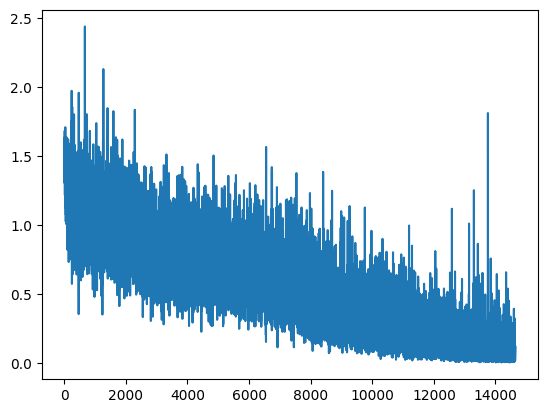

In [25]:
plt.plot(train_losses)

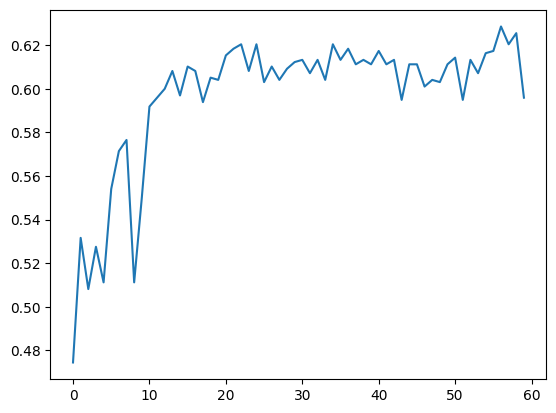

In [26]:
plt.plot(test_accuracy)

In [27]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 584/976 (0.5984)
{'acc_detail': tensor([0.6811, 0.4954, 0.6614, 0.5397], device='cuda:0'),
 'acc_unweighted': tensor(0.5944, device='cuda:0'),
 'acc_weighted': tensor(0.5984, device='cuda:0'),
 'f1s_detail': tensor([0.6906, 0.4875, 0.6942, 0.5152], device='cuda:0'),
 'f1s_unweighted': tensor(0.5969, device='cuda:0'),
 'f1s_weighted': tensor(0.6013, device='cuda:0'),
 'precision_detail': tensor([0.7004, 0.4798, 0.7304, 0.4928], device='cuda:0'),
 'recall_detail': tensor([0.6811, 0.4954, 0.6614, 0.5397], device='cuda:0'),
 'rocauc': tensor(0.8419, device='cuda:0'),
 'rocauc_detail': tensor([0.8939, 0.8128, 0.8946, 0.7663], device='cuda:0'),
 'uar': tensor(0.5944, device='cuda:0'),
 'wap': tensor(0.6058, device='cuda:0')}


tensor([[173,   8,   7,  66],
        [ 16, 107,  42,  51],
        [  3,  60, 168,  23],
        [ 55,  48,  13, 136]], device='cuda:0')

In [28]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc128_best_57epoch.pt
Correct: 616/976 (0.6311)
{'acc_detail': tensor([0.7323, 0.5417, 0.7087, 0.5278], device='cuda:0'),
 'acc_unweighted': tensor(0.6276, device='cuda:0'),
 'acc_weighted': tensor(0.6311, device='cuda:0'),
 'f1s_detail': tensor([0.7294, 0.5355, 0.7143, 0.5309], device='cuda:0'),
 'f1s_unweighted': tensor(0.6275, device='cuda:0'),
 'f1s_weighted': tensor(0.6313, device='cuda:0'),
 'precision_detail': tensor([0.7266, 0.5294, 0.7200, 0.5341], device='cuda:0'),
 'recall_detail': tensor([0.7323, 0.5417, 0.7087, 0.5278], device='cuda:0'),
 'rocauc': tensor(0.8516, device='cuda:0'),
 'rocauc_detail': tensor([0.8984, 0.8292, 0.9075, 0.7712], device='cuda:0'),
 'uar': tensor(0.6276, device='cuda:0'),
 'wap': tensor(0.6315, device='cuda:0')}


tensor([[186,   7,   7,  54],
        [ 13, 117,  41,  45],
        [  2,  55, 180,  17],
        [ 55,  42,  22, 133]], device='cuda:0')

In [29]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [30]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/40 [00:00<37:48, 56.72s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.026982
Mem before-during-after: 20203008 20355072 22861312


  0%|                                   | 0.13770491803278687/40 [00:07<36:41, 55.24s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 0.057185
Mem before-during-after: 22861312 23012352 22861312


  1%|▏                                  | 0.26885245901639304/40 [00:14<36:22, 54.93s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.015440
Mem before-during-after: 22861312 23012352 22861312


  1%|▍                                     | 0.39672131147541/40 [00:22<36:51, 55.83s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 0.015601
Mem before-during-after: 22861312 23012352 22861312


  1%|▍                                   | 0.5278688524590167/40 [00:29<36:14, 55.08s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 0.037125
Mem before-during-after: 22861312 23012352 22861312


  2%|▌                                   | 0.6622950819672118/40 [00:37<37:11, 56.73s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.088705
Mem before-during-after: 22861312 23012352 22861312


  2%|▋                                   | 0.7934426229508167/40 [00:44<36:03, 55.18s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 0.061538
Mem before-during-after: 22861312 23012352 22861312


  3%|▉                                   | 1.0032786885245846/40 [00:56<36:11, 55.68s/it]


Test Epoch: 61	Accuracy: 601/976 (61%)

Train Epoch: 62 [0/3918 (0%)]	Loss: 0.017957
Mem before-during-after: 22860288 23012352 22861312


  3%|█                                   | 1.1377049180327796/40 [01:03<35:42, 55.12s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 0.007248
Mem before-during-after: 22861312 23012352 22861312


  3%|█▏                                  | 1.2688524590163845/40 [01:10<35:08, 54.44s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.036285
Mem before-during-after: 22861312 23012352 22861312


  3%|█▎                                  | 1.3999999999999895/40 [01:18<37:12, 57.84s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 0.004195
Mem before-during-after: 22861312 23012352 22861312


  4%|█▍                                  | 1.5311475409835944/40 [01:25<36:09, 56.39s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.048475
Mem before-during-after: 22861312 23012352 22861312


  4%|█▍                                  | 1.6622950819671993/40 [01:32<35:15, 55.19s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 0.009372
Mem before-during-after: 22861312 23012352 22861312


  4%|█▌                                  | 1.7934426229508043/40 [01:40<35:52, 56.35s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.030323
Mem before-during-after: 22861312 23012352 22861312


  5%|█▊                                  | 2.0032786885245724/40 [01:51<35:06, 55.45s/it]


Test Epoch: 62	Accuracy: 592/976 (60%)

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.017808
Mem before-during-after: 22860288 23012352 22861312


  5%|█▉                                  | 2.1377049180327674/40 [01:59<35:44, 56.63s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 0.108109
Mem before-during-after: 22861312 23012352 22861312


  6%|██                                  | 2.2688524590163723/40 [02:06<34:49, 55.38s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.104035
Mem before-during-after: 22861312 23012352 22861312


  6%|██▏                                  | 2.396721311475387/40 [02:14<35:19, 56.36s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 0.006807
Mem before-during-after: 22861312 23012352 22861312


  6%|██▎                                  | 2.531147540983582/40 [02:21<34:23, 55.07s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.001233
Mem before-during-after: 22861312 23012352 22861312


  7%|██▍                                  | 2.662295081967187/40 [02:29<34:30, 55.45s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 0.032696
Mem before-during-after: 22861312 23012352 22861312


  7%|██▌                                  | 2.790163934426202/40 [02:36<34:48, 56.13s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.099584
Mem before-during-after: 22861312 23012352 22861312


  8%|██▊                                   | 3.00327868852456/40 [02:48<34:01, 55.18s/it]


Test Epoch: 63	Accuracy: 618/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_63epoch.pt
Train Epoch: 64 [0/3918 (0%)]	Loss: 0.060271
Mem before-during-after: 22860288 23012352 22861312


  8%|██▉                                  | 3.137704918032755/40 [02:55<33:42, 54.88s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.033162
Mem before-during-after: 22861312 23012352 22861312


  8%|███                                   | 3.26885245901636/40 [03:03<35:24, 57.83s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.004613
Mem before-during-after: 22861312 23012352 22861312


  8%|███▏                                 | 3.399999999999965/40 [03:11<39:07, 64.14s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.026656
Mem before-during-after: 22861312 23012352 22861312


  9%|███▏                                | 3.5278688524589796/40 [03:18<33:21, 54.87s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.015199
Mem before-during-after: 22861312 23012352 22861312


  9%|███▎                                | 3.6622950819671747/40 [03:25<33:12, 54.83s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.030693
Mem before-during-after: 22861312 23012352 22861312


  9%|███▍                                | 3.7934426229507796/40 [03:33<33:15, 55.13s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.069493
Mem before-during-after: 22861312 23012352 22861312


 10%|███▌                                | 4.0032786885245475/40 [03:44<32:27, 54.10s/it]


Test Epoch: 64	Accuracy: 576/976 (59%)

Train Epoch: 65 [0/3918 (0%)]	Loss: 0.030652
Mem before-during-after: 22860288 23012352 22861312


 10%|███▋                                | 4.1377049180327425/40 [03:52<33:09, 55.48s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 0.074457
Mem before-during-after: 22861312 23012352 22861312


 11%|███▊                                | 4.2688524590163475/40 [03:59<32:29, 54.57s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 0.030061
Mem before-during-after: 22861312 23012352 22861312


 11%|████                                 | 4.399999999999952/40 [04:06<33:18, 56.15s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 0.013834
Mem before-during-after: 22861312 23012352 22861312


 11%|████▏                                | 4.531147540983557/40 [04:13<33:00, 55.85s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 0.141123
Mem before-during-after: 22861312 23012352 22861312


 12%|████▎                                | 4.662295081967162/40 [04:21<32:29, 55.18s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.048625
Mem before-during-after: 22861312 23012352 22861312


 12%|████▍                                | 4.793442622950767/40 [04:28<32:00, 54.56s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 0.495627
Mem before-during-after: 22861312 23012352 22861312


 13%|████▋                                | 5.003278688524535/40 [04:40<31:34, 54.13s/it]


Test Epoch: 65	Accuracy: 591/976 (60%)

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.023324
Mem before-during-after: 22860288 23012352 22861312


 13%|████▉                                 | 5.13442622950814/40 [04:47<31:48, 54.74s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.091551
Mem before-during-after: 22861312 23012352 22861312


 13%|████▊                                | 5.268852459016335/40 [04:55<32:36, 56.35s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 0.011966
Mem before-during-after: 22861312 23012352 22861312


 13%|█████▏                                | 5.39999999999994/40 [05:02<31:19, 54.32s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 0.188138
Mem before-during-after: 22861312 23012352 22861312


 14%|█████                                | 5.531147540983545/40 [05:09<31:40, 55.12s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.057691
Mem before-during-after: 22861312 23012352 22861312


 14%|█████▍                                | 5.66229508196715/40 [05:16<34:19, 59.97s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 0.373529
Mem before-during-after: 22861312 23012352 22861312


 14%|█████▎                               | 5.793442622950755/40 [05:24<31:03, 54.47s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.176105
Mem before-during-after: 22861312 23012352 22861312


 15%|█████▌                               | 6.003278688524523/40 [05:35<31:18, 55.26s/it]


Test Epoch: 66	Accuracy: 603/976 (62%)

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.040614
Mem before-during-after: 22860288 23012352 22861312


 15%|█████▋                               | 6.137704918032718/40 [05:43<32:44, 58.03s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.070586
Mem before-during-after: 22861312 23012352 22861312


 16%|█████▊                               | 6.268852459016323/40 [05:50<30:35, 54.43s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 0.000495
Mem before-during-after: 22861312 23012352 22861312


 16%|█████▊                              | 6.3999999999999275/40 [05:57<30:04, 53.70s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.395397
Mem before-during-after: 22861312 23012352 22861312


 16%|█████▉                              | 6.5311475409835325/40 [06:04<30:40, 54.98s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 0.031574
Mem before-during-after: 22861312 23012352 22861312


 17%|██████▏                              | 6.662295081967137/40 [06:12<30:33, 54.99s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 0.002512
Mem before-during-after: 22861312 23012352 22861312


 17%|██████▎                              | 6.793442622950742/40 [06:19<30:22, 54.88s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 0.016304
Mem before-during-after: 22861312 23012352 22861312


 17%|██████▋                               | 6.99999999999992/40 [06:30<29:46, 54.14s/it]


Test Epoch: 67	Accuracy: 600/976 (61%)



 18%|██████▊                                | 7.0065573770491/40 [06:31<30:46, 55.95s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 0.013754
Mem before-during-after: 22860288 23012352 22861312


 18%|██████▌                              | 7.137704918032705/40 [06:38<29:43, 54.26s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.022990
Mem before-during-after: 22861312 23012352 22861312


 18%|██████▉                               | 7.26885245901631/40 [06:45<30:02, 55.06s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 0.030906
Mem before-during-after: 22861312 23012352 22861312


 18%|██████▊                              | 7.399999999999915/40 [06:53<30:07, 55.44s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.108138
Mem before-during-after: 22861312 23012352 22861312


 19%|███████▏                              | 7.52786885245893/40 [07:00<29:36, 54.71s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.080462
Mem before-during-after: 22861312 23012352 22861312


 19%|███████                              | 7.662295081967125/40 [07:07<30:03, 55.76s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.023128
Mem before-during-after: 22861312 23012352 22861312


 19%|███████▍                              | 7.79344262295073/40 [07:15<29:57, 55.81s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.066835
Mem before-during-after: 22861312 23012352 22861312


 20%|███████▍                             | 8.003278688524498/40 [07:26<29:24, 55.14s/it]


Test Epoch: 68	Accuracy: 602/976 (61%)

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.012648
Mem before-during-after: 22860288 23012352 22861312


 20%|███████▌                             | 8.137704918032693/40 [07:34<29:30, 55.56s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 0.027904
Mem before-during-after: 22861312 23012352 22861312


 21%|███████▋                             | 8.268852459016298/40 [07:41<28:58, 54.80s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.041743
Mem before-during-after: 22861312 23012352 22861312


 21%|███████▊                             | 8.399999999999903/40 [07:48<29:01, 55.10s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 0.125606
Mem before-during-after: 22861312 23012352 22861312


 21%|███████▉                             | 8.531147540983508/40 [07:56<28:59, 55.26s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 0.056579
Mem before-during-after: 22861312 23012352 22861312


 22%|████████                             | 8.662295081967113/40 [08:03<28:54, 55.34s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.042254
Mem before-during-after: 22861312 23012352 22861312


 22%|████████▏                            | 8.793442622950717/40 [08:10<28:35, 54.99s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.006143
Mem before-during-after: 22861312 23012352 22861312


 23%|████████▎                            | 9.003278688524485/40 [08:22<28:28, 55.12s/it]


Test Epoch: 69	Accuracy: 595/976 (61%)

Train Epoch: 70 [0/3918 (0%)]	Loss: 0.017780
Mem before-during-after: 22860288 23012352 22861312


 23%|████████▋                             | 9.13770491803268/40 [08:29<27:58, 54.40s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 0.266072
Mem before-during-after: 22861312 23012352 22861312


 23%|████████▌                            | 9.268852459016285/40 [08:37<27:58, 54.61s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 0.030275
Mem before-during-after: 22861312 23012352 22861312


 23%|████████▉                             | 9.39999999999989/40 [08:44<28:51, 56.58s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 0.146203
Mem before-during-after: 22861312 23012352 22861312


 24%|████████▊                            | 9.531147540983495/40 [08:51<27:42, 54.58s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.017855
Mem before-during-after: 22861312 23012352 22861312


 24%|█████████▍                             | 9.6622950819671/40 [08:59<28:08, 55.64s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.121506
Mem before-during-after: 22861312 23012352 22861312


 24%|█████████                            | 9.793442622950705/40 [09:06<27:31, 54.66s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.148350
Mem before-during-after: 22861312 23012352 22861312


 25%|█████████                           | 10.003278688524473/40 [09:17<27:32, 55.08s/it]


Test Epoch: 70	Accuracy: 599/976 (61%)

Train Epoch: 71 [0/3918 (0%)]	Loss: 0.017805
Mem before-during-after: 22860288 23012352 22861312


 25%|█████████                           | 10.137704918032668/40 [09:25<27:17, 54.85s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.005769
Mem before-during-after: 22861312 23012352 22861312


 26%|█████████▏                          | 10.268852459016273/40 [09:32<27:09, 54.79s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.012047
Mem before-during-after: 22861312 23012352 22861312


 26%|█████████▎                          | 10.399999999999878/40 [09:40<26:57, 54.65s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.007316
Mem before-during-after: 22861312 23012352 22861312


 26%|█████████▍                          | 10.531147540983483/40 [09:47<27:04, 55.12s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 0.264551
Mem before-during-after: 22861312 23012352 22861312


 27%|█████████▌                          | 10.662295081967088/40 [09:54<26:47, 54.80s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.017585
Mem before-during-after: 22861312 23012352 22861312


 27%|█████████▋                          | 10.793442622950693/40 [10:01<26:52, 55.20s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 0.131796
Mem before-during-after: 22861312 23012352 22861312


 28%|██████████▏                          | 11.00327868852446/40 [10:13<26:33, 54.95s/it]


Test Epoch: 71	Accuracy: 598/976 (61%)

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.001487
Mem before-during-after: 22860288 23012352 22861312


 28%|██████████                          | 11.137704918032655/40 [10:21<27:06, 56.34s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 0.014278
Mem before-during-after: 22861312 23012352 22861312


 28%|██████████▍                          | 11.26885245901626/40 [10:28<26:28, 55.29s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: 0.036341
Mem before-during-after: 22861312 23012352 22861312


 28%|██████████▎                         | 11.399999999999865/40 [10:35<25:47, 54.11s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: 0.008540
Mem before-during-after: 22861312 23012352 22861312


 29%|██████████▋                          | 11.53114754098347/40 [10:43<26:19, 55.47s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: 0.187028
Mem before-during-after: 22861312 23012352 22861312


 29%|██████████▍                         | 11.662295081967075/40 [10:50<26:41, 56.52s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: 0.039893
Mem before-during-after: 22861312 23012352 22861312


 29%|██████████▉                          | 11.79344262295068/40 [10:57<26:14, 55.81s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: 0.009668
Mem before-during-after: 22861312 23012352 22861312


 30%|██████████▊                         | 12.003278688524448/40 [11:09<25:27, 54.54s/it]


Test Epoch: 72	Accuracy: 610/976 (62%)

Train Epoch: 73 [0/3918 (0%)]	Loss: 0.023800
Mem before-during-after: 22860288 23012352 22861312


 30%|██████████▉                         | 12.137704918032643/40 [11:16<25:22, 54.64s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: 0.036663
Mem before-during-after: 22861312 23012352 22861312


 31%|███████████                         | 12.268852459016248/40 [11:24<25:39, 55.53s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: 0.041849
Mem before-during-after: 22861312 23012352 22861312


 31%|███████████▏                        | 12.399999999999853/40 [11:31<25:15, 54.92s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: 0.054289
Mem before-during-after: 22861312 23012352 22861312


 31%|███████████▎                        | 12.531147540983458/40 [11:38<25:20, 55.36s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: 0.041420
Mem before-during-after: 22861312 23012352 22861312


 32%|███████████▍                        | 12.662295081967063/40 [11:46<24:27, 53.67s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: 0.008163
Mem before-during-after: 22861312 23012352 22861312


 32%|███████████▌                        | 12.793442622950668/40 [11:53<24:27, 53.93s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: 0.078931
Mem before-during-after: 22861312 23012352 22861312


 33%|███████████▋                        | 13.003278688524436/40 [12:04<24:22, 54.18s/it]


Test Epoch: 73	Accuracy: 584/976 (60%)

Train Epoch: 74 [0/3918 (0%)]	Loss: 0.084770
Mem before-during-after: 22860288 23012352 22861312


 33%|████████████▏                        | 13.13770491803263/40 [12:12<24:20, 54.35s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: 0.016578
Mem before-during-after: 22861312 23012352 22861312


 33%|███████████▉                        | 13.268852459016236/40 [12:19<25:14, 56.67s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: 0.017653
Mem before-during-after: 22861312 23012352 22861312


 33%|████████████▍                        | 13.39999999999984/40 [12:27<24:24, 55.04s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: 0.055495
Mem before-during-after: 22861312 23012352 22861312


 34%|████████████▏                       | 13.531147540983445/40 [12:34<24:49, 56.26s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: 0.172229
Mem before-during-after: 22861312 23012352 22861312


 34%|████████████▋                        | 13.66229508196705/40 [12:41<24:03, 54.81s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: 0.036670
Mem before-during-after: 22861312 23012352 22861312


 34%|████████████▍                       | 13.793442622950655/40 [12:49<23:23, 53.56s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: 0.012536
Mem before-during-after: 22861312 23012352 22861312


 35%|████████████▌                       | 14.003278688524423/40 [13:00<24:21, 56.23s/it]


Test Epoch: 74	Accuracy: 605/976 (62%)

Train Epoch: 75 [0/3918 (0%)]	Loss: 0.032889
Mem before-during-after: 22860288 23012352 22861312


 35%|████████████▋                       | 14.137704918032618/40 [13:08<23:35, 54.73s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: 0.004216
Mem before-during-after: 22861312 23012352 22861312


 36%|████████████▊                       | 14.268852459016223/40 [13:15<23:36, 55.04s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: 0.139688
Mem before-during-after: 22861312 23012352 22861312


 36%|████████████▉                       | 14.399999999999828/40 [13:22<23:55, 56.08s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: 0.120141
Mem before-during-after: 22861312 23012352 22861312


 36%|█████████████                       | 14.531147540983433/40 [13:30<25:57, 61.17s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: 0.095187
Mem before-during-after: 22861312 23012352 22861312


 37%|█████████████▏                      | 14.662295081967038/40 [13:37<23:23, 55.38s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: 0.019752
Mem before-during-after: 22861312 23012352 22861312


 37%|█████████████▎                      | 14.793442622950643/40 [13:44<23:33, 56.06s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: 0.499004
Mem before-during-after: 22861312 23012352 22861312


 38%|█████████████▉                       | 15.00327868852441/40 [13:56<23:16, 55.86s/it]


Test Epoch: 75	Accuracy: 589/976 (60%)

Train Epoch: 76 [0/3918 (0%)]	Loss: 0.066336
Mem before-during-after: 22860288 23012352 22861312


 38%|█████████████▌                      | 15.137704918032606/40 [14:03<23:21, 56.36s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: 0.422967
Mem before-during-after: 22861312 23012352 22861312


 38%|██████████████                       | 15.26885245901621/40 [14:10<22:49, 55.38s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: 0.116762
Mem before-during-after: 22861312 23012352 22861312


 38%|█████████████▊                      | 15.399999999999816/40 [14:18<23:06, 56.36s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: 0.024329
Mem before-during-after: 22861312 23012352 22861312


 39%|██████████████▎                      | 15.53114754098342/40 [14:25<22:24, 54.96s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: 0.254725
Mem before-during-after: 22861312 23012352 22861312


 39%|██████████████                      | 15.662295081967025/40 [14:33<22:18, 54.98s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: 0.011269
Mem before-during-after: 22861312 23012352 22861312


 39%|██████████████▌                      | 15.79344262295063/40 [14:40<21:36, 53.58s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: 0.328165
Mem before-during-after: 22861312 23012352 22861312


 40%|███████████████▏                      | 16.0032786885244/40 [14:52<22:07, 55.30s/it]


Test Epoch: 76	Accuracy: 591/976 (60%)

Train Epoch: 77 [0/3918 (0%)]	Loss: 0.250953
Mem before-during-after: 22860288 23012352 22861312


 40%|██████████████▌                     | 16.137704918032668/40 [14:59<21:59, 55.28s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: 0.374579
Mem before-during-after: 22861312 23012352 22861312


 41%|██████████████▋                     | 16.268852459016344/40 [15:06<21:50, 55.20s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: 0.186523
Mem before-during-after: 22861312 23012352 22861312


 41%|███████████████▏                     | 16.40000000000002/40 [15:14<21:54, 55.68s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: 0.020074
Mem before-during-after: 22861312 23012352 22861312


 41%|██████████████▉                     | 16.531147540983696/40 [15:21<20:52, 53.39s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: 0.051417
Mem before-during-after: 22861312 23012352 22861312


 42%|██████████████▉                     | 16.662295081967372/40 [15:28<20:55, 53.79s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: 0.017572
Mem before-during-after: 22861312 23012352 22861312


 42%|███████████████                     | 16.793442622951048/40 [15:35<20:41, 53.49s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: 0.014505
Mem before-during-after: 22861312 23012352 22861312


 43%|███████████████▋                     | 17.00327868852493/40 [15:47<21:23, 55.80s/it]


Test Epoch: 77	Accuracy: 611/976 (62%)

Train Epoch: 78 [0/3918 (0%)]	Loss: 0.001452
Mem before-during-after: 22860288 23012352 22861312


 43%|███████████████▍                    | 17.137704918033197/40 [15:55<20:32, 53.91s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: 0.077557
Mem before-during-after: 22861312 23012352 22861312


 43%|███████████████▌                    | 17.268852459016873/40 [16:02<21:02, 55.55s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: 0.002076
Mem before-during-after: 22861312 23012352 22861312


 44%|████████████████                     | 17.40000000000055/40 [16:10<20:47, 55.18s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: 0.026336
Mem before-during-after: 22861312 23012352 22861312


 44%|███████████████▊                    | 17.531147540984225/40 [16:17<21:22, 57.06s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: 0.408460
Mem before-during-after: 22861312 23012352 22861312


 44%|████████████████▊                     | 17.6622950819679/40 [16:24<20:08, 54.10s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: 0.000848
Mem before-during-after: 22861312 23012352 22861312


 44%|████████████████                    | 17.793442622951577/40 [16:32<20:29, 55.38s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: 0.018609
Mem before-during-after: 22861312 23012352 22861312


 45%|████████████████▋                    | 18.00327868852546/40 [16:43<20:01, 54.61s/it]


Test Epoch: 78	Accuracy: 582/976 (59%)

Train Epoch: 79 [0/3918 (0%)]	Loss: 0.024341
Mem before-during-after: 22860288 23012352 22861312


 45%|████████████████▎                   | 18.137704918033727/40 [16:50<20:04, 55.10s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: 0.025938
Mem before-during-after: 22861312 23012352 22861312


 46%|████████████████▍                   | 18.268852459017403/40 [16:58<20:24, 56.36s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: 0.170603
Mem before-during-after: 22861312 23012352 22861312


 46%|█████████████████                    | 18.40000000000108/40 [17:05<19:50, 55.14s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: 0.000763
Mem before-during-after: 22861312 23012352 22861312


 46%|████████████████▋                   | 18.531147540984755/40 [17:12<19:30, 54.54s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: 0.006723
Mem before-during-after: 22861312 23012352 22861312


 47%|█████████████████▎                   | 18.66229508196843/40 [17:20<19:23, 54.51s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: 0.075788
Mem before-during-after: 22861312 23012352 22861312


 47%|████████████████▉                   | 18.793442622952107/40 [17:27<19:09, 54.23s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: 0.003712
Mem before-during-after: 22861312 23012352 22861312


 48%|█████████████████                   | 19.003278688525988/40 [17:39<18:53, 53.97s/it]


Test Epoch: 79	Accuracy: 606/976 (62%)

Train Epoch: 80 [0/3918 (0%)]	Loss: 0.020019
Mem before-during-after: 22860288 23012352 22861312


 48%|█████████████████▏                  | 19.137704918034256/40 [17:46<19:02, 54.78s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: 0.012988
Mem before-during-after: 22861312 23012352 22861312


 48%|█████████████████▎                  | 19.268852459017932/40 [17:54<18:49, 54.49s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: 0.020887
Mem before-during-after: 22861312 23012352 22861312


 49%|█████████████████▍                  | 19.400000000001608/40 [18:01<19:33, 56.98s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: 0.015189
Mem before-during-after: 22861312 23012352 22861312


 49%|█████████████████▌                  | 19.531147540985284/40 [18:08<18:21, 53.82s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: 0.282342
Mem before-during-after: 22861312 23012352 22861312


 49%|██████████████████▏                  | 19.66229508196896/40 [18:16<19:46, 58.33s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: 0.003351
Mem before-during-after: 22861312 23012352 22861312


 49%|█████████████████▊                  | 19.793442622952636/40 [18:23<18:32, 55.05s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: 0.614284
Mem before-during-after: 22861312 23012352 22861312


 50%|██████████████████                  | 20.003278688526517/40 [18:34<17:55, 53.80s/it]


Test Epoch: 80	Accuracy: 579/976 (59%)

Train Epoch: 81 [0/3918 (0%)]	Loss: 0.018156
Mem before-during-after: 22860288 23012352 22861312


 50%|██████████████████                  | 20.137704918034785/40 [18:42<19:39, 59.41s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: 0.123921
Mem before-during-after: 22861312 23012352 22861312


 51%|██████████████████▋                  | 20.26885245901846/40 [18:49<17:55, 54.51s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: 0.005370
Mem before-during-after: 22861312 23012352 22861312


 51%|██████████████████▎                 | 20.400000000002137/40 [18:57<18:27, 56.49s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: 0.003147
Mem before-during-after: 22861312 23012352 22861312


 51%|██████████████████▍                 | 20.531147540985813/40 [19:04<17:53, 55.13s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: 0.031152
Mem before-during-after: 22861312 23012352 22861312


 52%|███████████████████                  | 20.66229508196949/40 [19:11<17:27, 54.15s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: 0.056975
Mem before-during-after: 22861312 23012352 22861312


 52%|██████████████████▋                 | 20.793442622953165/40 [19:19<17:55, 55.98s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: 0.057333
Mem before-during-after: 22861312 23012352 22861312


 53%|██████████████████▉                 | 21.003278688527047/40 [19:30<17:06, 54.06s/it]


Test Epoch: 81	Accuracy: 596/976 (61%)

Train Epoch: 82 [0/3918 (0%)]	Loss: 0.002544
Mem before-during-after: 22860288 23012352 22861312


 53%|███████████████████                 | 21.137704918035315/40 [19:38<17:16, 54.94s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: 0.000382
Mem before-during-after: 22861312 23012352 22861312


 53%|███████████████████▋                 | 21.26885245901899/40 [19:45<17:05, 54.72s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: 0.050922
Mem before-during-after: 22861312 23012352 22861312


 54%|███████████████████▎                | 21.400000000002667/40 [19:52<16:38, 53.71s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: 0.010973
Mem before-during-after: 22861312 23012352 22861312


 54%|███████████████████▉                 | 21.52786885246175/40 [19:59<17:02, 55.36s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: 0.035653
Mem before-during-after: 22861312 23012352 22861312


 54%|████████████████████                 | 21.66229508197002/40 [20:07<16:50, 55.08s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: 0.016193
Mem before-during-after: 22861312 23012352 22861312


 54%|███████████████████▌                | 21.793442622953695/40 [20:14<16:32, 54.51s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: 0.055890
Mem before-during-after: 22861312 23012352 22861312


 55%|███████████████████▊                | 22.000000000002984/40 [20:25<16:10, 53.93s/it]


Test Epoch: 82	Accuracy: 587/976 (60%)



 55%|███████████████████▊                | 22.006557377052168/40 [20:26<21:06, 70.38s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: 0.118358
Mem before-during-after: 22860288 23012352 22861312


 55%|███████████████████▉                | 22.137704918035844/40 [20:33<16:06, 54.08s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: 0.005006
Mem before-during-after: 22861312 23012352 22861312


 56%|████████████████████▌                | 22.26885245901952/40 [20:40<16:11, 54.78s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: 0.005381
Mem before-during-after: 22861312 23012352 22861312


 56%|████████████████████▏               | 22.400000000003196/40 [20:48<16:08, 55.04s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: 0.005040
Mem before-during-after: 22861312 23012352 22861312


 56%|████████████████████▎               | 22.531147540986872/40 [20:55<16:00, 54.96s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: 0.064289
Mem before-during-after: 22861312 23012352 22861312


 57%|████████████████████▍               | 22.662295081970548/40 [21:02<15:43, 54.41s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: 0.043852
Mem before-during-after: 22861312 23012352 22861312


 57%|████████████████████▌               | 22.793442622954224/40 [21:10<16:07, 56.23s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: 0.151824
Mem before-during-after: 22861312 23012352 22861312


 58%|████████████████████▋               | 23.003278688528106/40 [21:22<15:28, 54.66s/it]


Test Epoch: 83	Accuracy: 586/976 (60%)

Train Epoch: 84 [0/3918 (0%)]	Loss: 0.065126
Mem before-during-after: 22860288 23012352 22861312


 58%|████████████████████▊               | 23.137704918036373/40 [21:29<15:20, 54.59s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: 0.003765
Mem before-during-after: 22861312 23012352 22861312


 58%|█████████████████████▌               | 23.26885245902005/40 [21:36<15:17, 54.81s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: 0.039780
Mem before-during-after: 22861312 23012352 22861312


 59%|█████████████████████               | 23.400000000003725/40 [21:44<15:23, 55.63s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: 0.020667
Mem before-during-after: 22861312 23012352 22861312


 59%|██████████████████████▎               | 23.5311475409874/40 [21:51<15:05, 54.97s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: 0.029580
Mem before-during-after: 22861312 23012352 22861312


 59%|█████████████████████▎              | 23.662295081971077/40 [21:58<15:06, 55.48s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: 0.017458
Mem before-during-after: 22861312 23012352 22861312


 59%|█████████████████████▍              | 23.793442622954753/40 [22:06<14:48, 54.83s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: 0.002178
Mem before-during-after: 22861312 23012352 22861312


 60%|█████████████████████▌              | 24.003278688528635/40 [22:17<14:33, 54.59s/it]


Test Epoch: 84	Accuracy: 589/976 (60%)

Train Epoch: 85 [0/3918 (0%)]	Loss: 0.001129
Mem before-during-after: 22860288 23012352 22861312


 60%|█████████████████████▋              | 24.137704918036903/40 [22:25<14:35, 55.16s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: 0.007570
Mem before-during-after: 22861312 23012352 22861312


 61%|██████████████████████▍              | 24.26885245902058/40 [22:32<14:14, 54.30s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: 0.001417
Mem before-during-after: 22861312 23012352 22861312


 61%|█████████████████████▉              | 24.400000000004255/40 [22:39<14:07, 54.31s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: 0.020615
Mem before-during-after: 22861312 23012352 22861312


 61%|██████████████████████▋              | 24.53114754098793/40 [22:47<14:05, 54.68s/it]

Train Epoch: 85 [2560/3918 (66%)]	Loss: 0.027991
Mem before-during-after: 22861312 23012352 22861312


 62%|██████████████████████▏             | 24.662295081971607/40 [22:54<13:57, 54.60s/it]

Train Epoch: 85 [3200/3918 (82%)]	Loss: 0.198008
Mem before-during-after: 22861312 23012352 22861312


 62%|██████████████████████▉              | 24.79016393443069/40 [23:01<13:56, 55.00s/it]

Train Epoch: 85 [3840/3918 (98%)]	Loss: 0.001836
Mem before-during-after: 22861312 23012352 22861312


 63%|██████████████████████▌             | 25.003278688529164/40 [23:13<14:01, 56.10s/it]


Test Epoch: 85	Accuracy: 575/976 (59%)

Train Epoch: 86 [0/3918 (0%)]	Loss: 0.023147
Mem before-during-after: 22860288 23012352 22861312


 63%|██████████████████████▌             | 25.137704918037432/40 [23:21<13:24, 54.14s/it]

Train Epoch: 86 [640/3918 (16%)]	Loss: 0.050861
Mem before-during-after: 22861312 23012352 22861312


 63%|██████████████████████▋             | 25.268852459021108/40 [23:28<15:45, 64.18s/it]

Train Epoch: 86 [1280/3918 (33%)]	Loss: 0.011534
Mem before-during-after: 22861312 23012352 22861312


 64%|██████████████████████▊             | 25.400000000004784/40 [23:35<13:17, 54.61s/it]

Train Epoch: 86 [1920/3918 (49%)]	Loss: 0.000377
Mem before-during-after: 22861312 23012352 22861312


 64%|███████████████████████▌             | 25.53114754098846/40 [23:43<13:04, 54.19s/it]

Train Epoch: 86 [2560/3918 (66%)]	Loss: 0.000734
Mem before-during-after: 22861312 23012352 22861312


 64%|███████████████████████             | 25.662295081972136/40 [23:50<13:12, 55.26s/it]

Train Epoch: 86 [3200/3918 (82%)]	Loss: 0.000033
Mem before-during-after: 22861312 23012352 22861312


 64%|███████████████████████▏            | 25.793442622955812/40 [23:57<12:42, 53.65s/it]

Train Epoch: 86 [3840/3918 (98%)]	Loss: 0.005426
Mem before-during-after: 22861312 23012352 22861312


 65%|███████████████████████▍            | 26.003278688529694/40 [24:09<12:44, 54.63s/it]


Test Epoch: 86	Accuracy: 572/976 (58%)

Train Epoch: 87 [0/3918 (0%)]	Loss: 0.005031
Mem before-during-after: 22860288 23012352 22861312


 65%|████████████████████████▏            | 26.13770491803796/40 [24:16<12:40, 54.87s/it]

Train Epoch: 87 [640/3918 (16%)]	Loss: 0.007276
Mem before-during-after: 22861312 23012352 22861312


 66%|███████████████████████▋            | 26.268852459021637/40 [24:24<12:36, 55.09s/it]

Train Epoch: 87 [1280/3918 (33%)]	Loss: 0.746155
Mem before-during-after: 22861312 23012352 22861312


 66%|███████████████████████▊            | 26.400000000005313/40 [24:31<12:22, 54.56s/it]

Train Epoch: 87 [1920/3918 (49%)]	Loss: 0.079072
Mem before-during-after: 22861312 23012352 22861312


 66%|████████████████████████▌            | 26.53114754098899/40 [24:38<12:13, 54.49s/it]

Train Epoch: 87 [2560/3918 (66%)]	Loss: 0.024202
Mem before-during-after: 22861312 23012352 22861312


 67%|███████████████████████▉            | 26.659016393448074/40 [24:45<13:17, 59.80s/it]

Train Epoch: 87 [3200/3918 (82%)]	Loss: 0.165083
Mem before-during-after: 22861312 23012352 22861312


 67%|████████████████████████▊            | 26.79344262295634/40 [24:53<12:04, 54.89s/it]

Train Epoch: 87 [3840/3918 (98%)]	Loss: 0.243379
Mem before-during-after: 22861312 23012352 22861312


 68%|████████████████████████▎           | 27.003278688530223/40 [25:04<11:57, 55.19s/it]


Test Epoch: 87	Accuracy: 595/976 (61%)

Train Epoch: 88 [0/3918 (0%)]	Loss: 0.003663
Mem before-during-after: 22860288 23012352 22861312


 68%|█████████████████████████            | 27.13770491803849/40 [25:12<11:58, 55.88s/it]

Train Epoch: 88 [640/3918 (16%)]	Loss: 0.000159
Mem before-during-after: 22861312 23012352 22861312


 68%|████████████████████████▌           | 27.268852459022167/40 [25:19<11:42, 55.20s/it]

Train Epoch: 88 [1280/3918 (33%)]	Loss: 0.018398
Mem before-during-after: 22861312 23012352 22861312


 69%|████████████████████████▋           | 27.400000000005843/40 [25:27<11:46, 56.04s/it]

Train Epoch: 88 [1920/3918 (49%)]	Loss: 0.196607
Mem before-during-after: 22861312 23012352 22861312


 69%|█████████████████████████▍           | 27.53114754098952/40 [25:34<11:27, 55.11s/it]

Train Epoch: 88 [2560/3918 (66%)]	Loss: 0.065281
Mem before-during-after: 22861312 23012352 22861312


 69%|████████████████████████▉           | 27.662295081973195/40 [25:41<11:19, 55.10s/it]

Train Epoch: 88 [3200/3918 (82%)]	Loss: 0.004389
Mem before-during-after: 22861312 23012352 22861312


 69%|█████████████████████████▋           | 27.79344262295687/40 [25:49<11:15, 55.32s/it]

Train Epoch: 88 [3840/3918 (98%)]	Loss: 0.002226
Mem before-during-after: 22861312 23012352 22861312


 70%|█████████████████████████▏          | 28.003278688530752/40 [26:00<10:50, 54.26s/it]


Test Epoch: 88	Accuracy: 590/976 (60%)

Train Epoch: 89 [0/3918 (0%)]	Loss: 0.000601
Mem before-during-after: 22860288 23012352 22861312


 70%|██████████████████████████           | 28.13770491803902/40 [26:08<10:56, 55.36s/it]

Train Epoch: 89 [640/3918 (16%)]	Loss: 0.000471
Mem before-during-after: 22861312 23012352 22861312


 71%|█████████████████████████▍          | 28.268852459022696/40 [26:15<10:47, 55.20s/it]

Train Epoch: 89 [1280/3918 (33%)]	Loss: 0.029715
Mem before-during-after: 22861312 23012352 22861312


 71%|█████████████████████████▌          | 28.400000000006372/40 [26:22<10:45, 55.65s/it]

Train Epoch: 89 [1920/3918 (49%)]	Loss: 0.045065
Mem before-during-after: 22861312 23012352 22861312


 71%|█████████████████████████▋          | 28.531147540990048/40 [26:30<10:36, 55.52s/it]

Train Epoch: 89 [2560/3918 (66%)]	Loss: 0.012850
Mem before-during-after: 22861312 23012352 22861312


 72%|█████████████████████████▊          | 28.662295081973724/40 [26:37<10:45, 56.92s/it]

Train Epoch: 89 [3200/3918 (82%)]	Loss: 0.000609
Mem before-during-after: 22861312 23012352 22861312


 72%|███████████████████████████▎          | 28.7934426229574/40 [26:44<10:21, 55.43s/it]

Train Epoch: 89 [3840/3918 (98%)]	Loss: 0.001486
Mem before-during-after: 22861312 23012352 22861312


 73%|██████████████████████████▊          | 29.00327868853128/40 [26:56<10:07, 55.26s/it]


Test Epoch: 89	Accuracy: 599/976 (61%)

Train Epoch: 90 [0/3918 (0%)]	Loss: 0.000533
Mem before-during-after: 22860288 23012352 22861312


 73%|██████████████████████████▉          | 29.13770491803955/40 [27:04<10:18, 56.97s/it]

Train Epoch: 90 [640/3918 (16%)]	Loss: 0.868188
Mem before-during-after: 22861312 23012352 22861312


 73%|██████████████████████████▎         | 29.268852459023226/40 [27:11<09:48, 54.82s/it]

Train Epoch: 90 [1280/3918 (33%)]	Loss: 0.236433
Mem before-during-after: 22861312 23012352 22861312


 73%|███████████████████████████▏         | 29.39672131148231/40 [27:18<09:50, 55.72s/it]

Train Epoch: 90 [1920/3918 (49%)]	Loss: 0.009446
Mem before-during-after: 22861312 23012352 22861312


 74%|██████████████████████████▌         | 29.531147540990577/40 [27:26<09:46, 56.02s/it]

Train Epoch: 90 [2560/3918 (66%)]	Loss: 0.002312
Mem before-during-after: 22861312 23012352 22861312


 74%|██████████████████████████▋         | 29.662295081974253/40 [27:33<09:28, 54.95s/it]

Train Epoch: 90 [3200/3918 (82%)]	Loss: 0.000892
Mem before-during-after: 22861312 23012352 22861312


 74%|███████████████████████████▌         | 29.79344262295793/40 [27:40<09:42, 57.05s/it]

Train Epoch: 90 [3840/3918 (98%)]	Loss: 0.142467
Mem before-during-after: 22861312 23012352 22861312


 75%|███████████████████████████▊         | 30.00327868853181/40 [27:52<09:17, 55.74s/it]


Test Epoch: 90	Accuracy: 591/976 (60%)

Train Epoch: 91 [0/3918 (0%)]	Loss: 0.002546
Mem before-during-after: 22860288 23012352 22861312


 75%|███████████████████████████▉         | 30.13770491804008/40 [27:59<08:46, 53.43s/it]

Train Epoch: 91 [640/3918 (16%)]	Loss: 0.010193
Mem before-during-after: 22861312 23012352 22861312


 76%|███████████████████████████▏        | 30.268852459023755/40 [28:07<08:54, 54.91s/it]

Train Epoch: 91 [1280/3918 (33%)]	Loss: 0.067191
Mem before-during-after: 22861312 23012352 22861312


 76%|████████████████████████████         | 30.40000000000743/40 [28:14<11:01, 68.96s/it]

Train Epoch: 91 [1920/3918 (49%)]	Loss: 0.078684
Mem before-during-after: 22861312 23012352 22861312


 76%|███████████████████████████▍        | 30.531147540991107/40 [28:21<08:42, 55.13s/it]

Train Epoch: 91 [2560/3918 (66%)]	Loss: 0.009689
Mem before-during-after: 22861312 23012352 22861312


 77%|███████████████████████████▌        | 30.662295081974783/40 [28:28<08:32, 54.84s/it]

Train Epoch: 91 [3200/3918 (82%)]	Loss: 0.023151
Mem before-during-after: 22861312 23012352 22861312


 77%|████████████████████████████▍        | 30.79344262295846/40 [28:36<08:38, 56.33s/it]

Train Epoch: 91 [3840/3918 (98%)]	Loss: 0.007538
Mem before-during-after: 22861312 23012352 22861312


 78%|████████████████████████████▋        | 31.00327868853234/40 [28:48<08:10, 54.53s/it]


Test Epoch: 91	Accuracy: 569/976 (58%)

Train Epoch: 92 [0/3918 (0%)]	Loss: 0.007928
Mem before-during-after: 22860288 23012352 22861312


 78%|████████████████████████████▊        | 31.13770491804061/40 [28:55<08:03, 54.61s/it]

Train Epoch: 92 [640/3918 (16%)]	Loss: 0.000158
Mem before-during-after: 22861312 23012352 22861312


 78%|████████████████████████████▏       | 31.268852459024284/40 [29:02<07:54, 54.31s/it]

Train Epoch: 92 [1280/3918 (33%)]	Loss: 0.000197
Mem before-during-after: 22861312 23012352 22861312


 79%|█████████████████████████████        | 31.40000000000796/40 [29:10<07:50, 54.65s/it]

Train Epoch: 92 [1920/3918 (49%)]	Loss: 0.005664
Mem before-during-after: 22861312 23012352 22861312


 79%|████████████████████████████▍       | 31.531147540991636/40 [29:17<07:43, 54.71s/it]

Train Epoch: 92 [2560/3918 (66%)]	Loss: 0.000068
Mem before-during-after: 22861312 23012352 22861312


 79%|████████████████████████████▍       | 31.662295081975312/40 [29:24<07:38, 55.01s/it]

Train Epoch: 92 [3200/3918 (82%)]	Loss: 0.002103
Mem before-during-after: 22861312 23012352 22861312


 79%|████████████████████████████▌       | 31.793442622958988/40 [29:32<07:32, 55.15s/it]

Train Epoch: 92 [3840/3918 (98%)]	Loss: 0.011085
Mem before-during-after: 22861312 23012352 22861312


 80%|████████████████████████████▊       | 32.003278688532866/40 [29:43<07:20, 55.03s/it]


Test Epoch: 92	Accuracy: 605/976 (62%)

Train Epoch: 93 [0/3918 (0%)]	Loss: 0.341377
Mem before-during-after: 22860288 23012352 22861312


 80%|█████████████████████████████▋       | 32.13770491804099/40 [29:51<07:13, 55.14s/it]

Train Epoch: 93 [640/3918 (16%)]	Loss: 0.177017
Mem before-during-after: 22861312 23012352 22861312


 81%|█████████████████████████████▊       | 32.26885245902452/40 [29:58<07:05, 55.00s/it]

Train Epoch: 93 [1280/3918 (33%)]	Loss: 0.000326
Mem before-during-after: 22861312 23012352 22861312


 81%|█████████████████████████████▏      | 32.400000000008056/40 [30:05<06:55, 54.71s/it]

Train Epoch: 93 [1920/3918 (49%)]	Loss: 0.000365
Mem before-during-after: 22861312 23012352 22861312


 81%|██████████████████████████████       | 32.53114754099159/40 [30:13<06:46, 54.48s/it]

Train Epoch: 93 [2560/3918 (66%)]	Loss: 0.032536
Mem before-during-after: 22861312 23012352 22861312


 82%|█████████████████████████████▍      | 32.662295081975124/40 [30:20<06:51, 56.12s/it]

Train Epoch: 93 [3200/3918 (82%)]	Loss: 0.018222
Mem before-during-after: 22861312 23012352 22861312


 82%|██████████████████████████████▎      | 32.79344262295866/40 [30:27<06:39, 55.45s/it]

Train Epoch: 93 [3840/3918 (98%)]	Loss: 0.671866
Mem before-during-after: 22861312 23012352 22861312


 83%|██████████████████████████████▌      | 33.00327868853231/40 [30:39<06:22, 54.66s/it]


Test Epoch: 93	Accuracy: 605/976 (62%)

Train Epoch: 94 [0/3918 (0%)]	Loss: 0.119670
Mem before-during-after: 22860288 23012352 22861312


 83%|█████████████████████████████▊      | 33.137704918040434/40 [30:46<06:13, 54.48s/it]

Train Epoch: 94 [640/3918 (16%)]	Loss: 0.000664
Mem before-during-after: 22861312 23012352 22861312


 83%|██████████████████████████████▊      | 33.26885245902397/40 [30:54<06:13, 55.51s/it]

Train Epoch: 94 [1280/3918 (33%)]	Loss: 0.000474
Mem before-during-after: 22861312 23012352 22861312


 84%|███████████████████████████████▋      | 33.4000000000075/40 [31:01<06:03, 55.02s/it]

Train Epoch: 94 [1920/3918 (49%)]	Loss: 0.074324
Mem before-during-after: 22861312 23012352 22861312


 84%|██████████████████████████████▏     | 33.531147540991036/40 [31:08<05:57, 55.24s/it]

Train Epoch: 94 [2560/3918 (66%)]	Loss: 0.039450
Mem before-during-after: 22861312 23012352 22861312


 84%|███████████████████████████████▏     | 33.66229508197457/40 [31:16<05:53, 55.77s/it]

Train Epoch: 94 [3200/3918 (82%)]	Loss: 0.082250
Mem before-during-after: 22861312 23012352 22861312


 84%|████████████████████████████████      | 33.7934426229581/40 [31:23<05:44, 55.51s/it]

Train Epoch: 94 [3840/3918 (98%)]	Loss: 0.000438
Mem before-during-after: 22861312 23012352 22861312


 85%|███████████████████████████████▍     | 34.00327868853176/40 [31:35<05:30, 55.12s/it]


Test Epoch: 94	Accuracy: 616/976 (63%)

Train Epoch: 95 [0/3918 (0%)]	Loss: 0.002636
Mem before-during-after: 22860288 23012352 22861312


 85%|███████████████████████████████▌     | 34.13770491803988/40 [31:42<05:20, 54.71s/it]

Train Epoch: 95 [640/3918 (16%)]	Loss: 0.000069
Mem before-during-after: 22861312 23012352 22861312


 86%|██████████████████████████████▊     | 34.268852459023414/40 [31:49<05:13, 54.71s/it]

Train Epoch: 95 [1280/3918 (33%)]	Loss: 0.033790
Mem before-during-after: 22861312 23012352 22861312


 86%|███████████████████████████████▊     | 34.40000000000695/40 [31:57<05:12, 55.85s/it]

Train Epoch: 95 [1920/3918 (49%)]	Loss: 0.011385
Mem before-during-after: 22861312 23012352 22861312


 86%|███████████████████████████████▉     | 34.53114754099048/40 [32:04<05:01, 55.08s/it]

Train Epoch: 95 [2560/3918 (66%)]	Loss: 0.004945
Mem before-during-after: 22861312 23012352 22861312


 87%|███████████████████████████████▏    | 34.662295081974015/40 [32:12<05:01, 56.44s/it]

Train Epoch: 95 [3200/3918 (82%)]	Loss: 0.089969
Mem before-during-after: 22861312 23012352 22861312


 87%|████████████████████████████████▏    | 34.79344262295755/40 [32:19<04:40, 53.85s/it]

Train Epoch: 95 [3840/3918 (98%)]	Loss: 0.003865
Mem before-during-after: 22861312 23012352 22861312


 88%|█████████████████████████████████▎    | 35.0032786885312/40 [32:30<04:34, 54.85s/it]


Test Epoch: 95	Accuracy: 604/976 (62%)

Train Epoch: 96 [0/3918 (0%)]	Loss: 0.053584
Mem before-during-after: 22860288 23012352 22861312


 88%|███████████████████████████████▌    | 35.137704918039326/40 [32:38<04:29, 55.50s/it]

Train Epoch: 96 [640/3918 (16%)]	Loss: 0.315331
Mem before-during-after: 22861312 23012352 22861312


 88%|████████████████████████████████▌    | 35.26885245902286/40 [32:45<04:26, 56.35s/it]

Train Epoch: 96 [1280/3918 (33%)]	Loss: 0.013913
Mem before-during-after: 22861312 23012352 22861312


 89%|████████████████████████████████▋    | 35.40000000000639/40 [32:53<04:11, 54.71s/it]

Train Epoch: 96 [1920/3918 (49%)]	Loss: 0.021313
Mem before-during-after: 22861312 23012352 22861312


 89%|████████████████████████████████▊    | 35.53114754098993/40 [33:00<04:08, 55.54s/it]

Train Epoch: 96 [2560/3918 (66%)]	Loss: 0.120486
Mem before-during-after: 22861312 23012352 22861312


 89%|████████████████████████████████▉    | 35.66229508197346/40 [33:07<03:59, 55.30s/it]

Train Epoch: 96 [3200/3918 (82%)]	Loss: 0.000290
Mem before-during-after: 22861312 23012352 22861312


 89%|████████████████████████████████▏   | 35.793442622956995/40 [33:15<03:48, 54.25s/it]

Train Epoch: 96 [3840/3918 (98%)]	Loss: 0.020580
Mem before-during-after: 22861312 23012352 22861312


 90%|█████████████████████████████████▎   | 36.00327868853065/40 [33:26<03:41, 55.38s/it]


Test Epoch: 96	Accuracy: 608/976 (62%)

Train Epoch: 97 [0/3918 (0%)]	Loss: 0.000097
Mem before-during-after: 22860288 23012352 22861312


 90%|█████████████████████████████████▍   | 36.13770491803877/40 [33:34<03:31, 54.82s/it]

Train Epoch: 97 [640/3918 (16%)]	Loss: 0.001344
Mem before-during-after: 22861312 23012352 22861312


 91%|████████████████████████████████▋   | 36.268852459022305/40 [33:41<03:25, 55.05s/it]

Train Epoch: 97 [1280/3918 (33%)]	Loss: 0.001039
Mem before-during-after: 22861312 23012352 22861312


 91%|█████████████████████████████████▋   | 36.40000000000584/40 [33:48<03:19, 55.51s/it]

Train Epoch: 97 [1920/3918 (49%)]	Loss: 0.170209
Mem before-during-after: 22861312 23012352 22861312


 91%|█████████████████████████████████▊   | 36.53114754098937/40 [33:56<03:15, 56.47s/it]

Train Epoch: 97 [2560/3918 (66%)]	Loss: 0.021700
Mem before-during-after: 22861312 23012352 22861312


 92%|█████████████████████████████████▉   | 36.66229508197291/40 [34:03<03:00, 54.11s/it]

Train Epoch: 97 [3200/3918 (82%)]	Loss: 0.003042
Mem before-during-after: 22861312 23012352 22861312


 92%|██████████████████████████████████   | 36.79016393443185/40 [34:10<02:58, 55.59s/it]

Train Epoch: 97 [3840/3918 (98%)]	Loss: 0.006432
Mem before-during-after: 22861312 23012352 22861312


 93%|█████████████████████████████████▎  | 37.003278688530095/40 [34:22<02:43, 54.71s/it]


Test Epoch: 97	Accuracy: 611/976 (62%)

Train Epoch: 98 [0/3918 (0%)]	Loss: 0.001474
Mem before-during-after: 22860288 23012352 22861312


 93%|██████████████████████████████████▎  | 37.13770491803822/40 [34:30<02:37, 55.11s/it]

Train Epoch: 98 [640/3918 (16%)]	Loss: 0.007486
Mem before-during-after: 22861312 23012352 22861312


 93%|██████████████████████████████████▍  | 37.26885245902175/40 [34:37<02:32, 55.82s/it]

Train Epoch: 98 [1280/3918 (33%)]	Loss: 0.001826
Mem before-during-after: 22861312 23012352 22861312


 94%|█████████████████████████████████▋  | 37.400000000005285/40 [34:44<02:26, 56.19s/it]

Train Epoch: 98 [1920/3918 (49%)]	Loss: 0.000100
Mem before-during-after: 22861312 23012352 22861312


 94%|██████████████████████████████████▋  | 37.53114754098882/40 [34:52<02:12, 53.74s/it]

Train Epoch: 98 [2560/3918 (66%)]	Loss: 0.031184
Mem before-during-after: 22861312 23012352 22861312


 94%|██████████████████████████████████▊  | 37.66229508197235/40 [34:59<02:06, 54.21s/it]

Train Epoch: 98 [3200/3918 (82%)]	Loss: 0.003550
Mem before-during-after: 22861312 23012352 22861312


 94%|██████████████████████████████████▉  | 37.79344262295589/40 [35:06<02:01, 55.21s/it]

Train Epoch: 98 [3840/3918 (98%)]	Loss: 0.008032
Mem before-during-after: 22861312 23012352 22861312


 95%|███████████████████████████████████▏ | 38.00327868852954/40 [35:18<01:47, 54.07s/it]


Test Epoch: 98	Accuracy: 609/976 (62%)

Train Epoch: 99 [0/3918 (0%)]	Loss: 0.005565
Mem before-during-after: 22860288 23012352 22861312


 95%|███████████████████████████████████▎ | 38.13770491803766/40 [35:25<01:43, 55.78s/it]

Train Epoch: 99 [640/3918 (16%)]	Loss: 0.000327
Mem before-during-after: 22861312 23012352 22861312


 96%|████████████████████████████████████▎ | 38.2688524590212/40 [35:33<01:36, 55.85s/it]

Train Epoch: 99 [1280/3918 (33%)]	Loss: 0.270993
Mem before-during-after: 22861312 23012352 22861312


 96%|███████████████████████████████████▌ | 38.40000000000473/40 [35:40<01:27, 54.47s/it]

Train Epoch: 99 [1920/3918 (49%)]	Loss: 0.005575
Mem before-during-after: 22861312 23012352 22861312


 96%|██████████████████████████████████▋ | 38.531147540988265/40 [35:47<01:22, 56.38s/it]

Train Epoch: 99 [2560/3918 (66%)]	Loss: 0.044725
Mem before-during-after: 22861312 23012352 22861312


 97%|████████████████████████████████████▋ | 38.6622950819718/40 [35:55<01:14, 55.55s/it]

Train Epoch: 99 [3200/3918 (82%)]	Loss: 0.001482
Mem before-during-after: 22861312 23012352 22861312


 97%|███████████████████████████████████▉ | 38.79344262295533/40 [36:02<01:05, 54.42s/it]

Train Epoch: 99 [3840/3918 (98%)]	Loss: 0.003156
Mem before-during-after: 22861312 23012352 22861312


 98%|████████████████████████████████████ | 39.00327868852899/40 [36:14<00:54, 55.05s/it]


Test Epoch: 99	Accuracy: 587/976 (60%)

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.000146
Mem before-during-after: 22860288 23012352 22861312


 98%|████████████████████████████████████▏| 39.13770491803711/40 [36:21<00:46, 54.44s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 0.000843
Mem before-during-after: 22861312 23012352 22861312


 98%|████████████████████████████████████▎| 39.26885245902064/40 [36:28<00:47, 64.69s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 0.037462
Mem before-during-after: 22861312 23012352 22861312


 99%|████████████████████████████████████▍| 39.40000000000418/40 [36:36<00:32, 54.53s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 0.004176
Mem before-during-after: 22861312 23012352 22861312


 99%|████████████████████████████████████▌| 39.53114754098771/40 [36:43<00:25, 55.07s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 0.675788
Mem before-during-after: 22861312 23012352 22861312


 99%|███████████████████████████████████▋| 39.662295081971244/40 [36:50<00:18, 55.85s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 0.000742
Mem before-during-after: 22861312 23012352 22861312


 99%|████████████████████████████████████▊| 39.79344262295478/40 [36:58<00:11, 54.54s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.082511
Mem before-during-after: 22861312 23012352 22861312


100%|███████████████████████████████████▉| 39.996721311479256/40 [37:09<00:00, 54.32s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████| 40.000000000003844/40 [37:09<00:00, 55.74s/it]


Test Epoch: 100	Accuracy: 599/976 (61%)



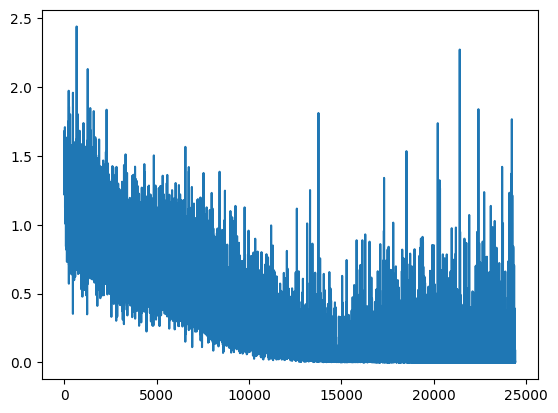

In [31]:
plt.plot(train_losses)

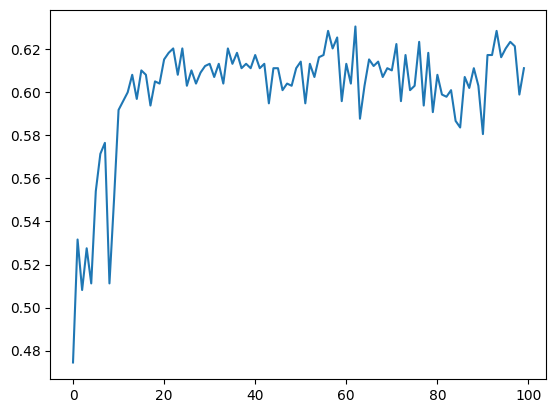

In [32]:
plt.plot(test_accuracy)

In [33]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc128_best_63epoch.pt
Correct: 618/976 (0.6332)
{'acc_detail': tensor([0.7598, 0.5000, 0.7677, 0.4841], device='cuda:0'),
 'acc_unweighted': tensor(0.6279, device='cuda:0'),
 'acc_weighted': tensor(0.6332, device='cuda:0'),
 'f1s_detail': tensor([0.7352, 0.5059, 0.7303, 0.5236], device='cuda:0'),
 'f1s_unweighted': tensor(0.6238, device='cuda:0'),
 'f1s_weighted': tensor(0.6286, device='cuda:0'),
 'precision_detail': tensor([0.7122, 0.5118, 0.6964, 0.5701], device='cuda:0'),
 'recall_detail': tensor([0.7598, 0.5000, 0.7677, 0.4841], device='cuda:0'),
 'rocauc': tensor(0.8462, device='cuda:0'),
 'rocauc_detail': tensor([0.8991, 0.8113, 0.8980, 0.7764], device='cuda:0'),
 'uar': tensor(0.6279, device='cuda:0'),
 'wap': tensor(0.6271, device='cuda:0')}


tensor([[193,   8,   8,  45],
        [ 15, 108,  57,  36],
        [  2,  46, 195,  11],
        [ 61,  49,  20, 122]], device='cuda:0')

In [34]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [35]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/50 [00:00<44:21, 53.23s/it]

Train Epoch: 101 [0/3918 (0%)]	Loss: 0.000710
Mem before-during-after: 20290048 20355584 22861824


  0%|                                   | 0.13770491803278687/50 [00:07<46:12, 55.60s/it]

Train Epoch: 101 [640/3918 (16%)]	Loss: 0.000195
Mem before-during-after: 22861824 23012864 22861824


  1%|▏                                  | 0.26885245901639304/50 [00:15<45:28, 54.86s/it]

Train Epoch: 101 [1280/3918 (33%)]	Loss: 0.004706
Mem before-during-after: 22861824 23012864 22861824


  1%|▎                                   | 0.4000000000000002/50 [00:22<45:15, 54.74s/it]

Train Epoch: 101 [1920/3918 (49%)]	Loss: 0.000127
Mem before-during-after: 22861824 23012864 22861824


  1%|▍                                   | 0.5311475409836068/50 [00:29<45:23, 55.05s/it]

Train Epoch: 101 [2560/3918 (66%)]	Loss: 0.000187
Mem before-during-after: 22861824 23012864 22861824


  1%|▍                                   | 0.6622950819672118/50 [00:37<46:19, 56.34s/it]

Train Epoch: 101 [3200/3918 (82%)]	Loss: 0.000191
Mem before-during-after: 22861824 23012864 22861824


  2%|▌                                   | 0.7934426229508167/50 [00:44<45:33, 55.56s/it]

Train Epoch: 101 [3840/3918 (98%)]	Loss: 0.000132
Mem before-during-after: 22861824 23012864 22861824


  2%|▋                                   | 1.0032786885245846/50 [00:56<45:34, 55.81s/it]


Test Epoch: 101	Accuracy: 597/976 (61%)

Train Epoch: 102 [0/3918 (0%)]	Loss: 0.000149
Mem before-during-after: 22860800 23012864 22861824


  2%|▊                                   | 1.1377049180327796/50 [01:03<44:58, 55.23s/it]

Train Epoch: 102 [640/3918 (16%)]	Loss: 0.000085
Mem before-during-after: 22861824 23012864 22861824


  3%|▉                                   | 1.2688524590163845/50 [01:11<44:57, 55.35s/it]

Train Epoch: 102 [1280/3918 (33%)]	Loss: 0.000907
Mem before-during-after: 22861824 23012864 22861824


  3%|█                                   | 1.3967213114753994/50 [01:18<45:09, 55.74s/it]

Train Epoch: 102 [1920/3918 (49%)]	Loss: 0.000002
Mem before-during-after: 22861824 23012864 22861824


  3%|█                                   | 1.5311475409835944/50 [01:25<45:23, 56.20s/it]

Train Epoch: 102 [2560/3918 (66%)]	Loss: 0.000049
Mem before-during-after: 22861824 23012864 22861824


  3%|█▏                                  | 1.6622950819671993/50 [01:33<45:07, 56.01s/it]

Train Epoch: 102 [3200/3918 (82%)]	Loss: 0.000219
Mem before-during-after: 22861824 23012864 22861824


  4%|█▎                                  | 1.7934426229508043/50 [01:40<44:38, 55.56s/it]

Train Epoch: 102 [3840/3918 (98%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


  4%|█▍                                  | 2.0032786885245724/50 [01:51<43:27, 54.33s/it]


Test Epoch: 102	Accuracy: 609/976 (62%)

Train Epoch: 103 [0/3918 (0%)]	Loss: 0.000151
Mem before-during-after: 22860800 23012864 22861824


  4%|█▌                                  | 2.1377049180327674/50 [01:59<43:52, 55.01s/it]

Train Epoch: 103 [640/3918 (16%)]	Loss: 0.001379
Mem before-during-after: 22861824 23012864 22861824


  5%|█▋                                  | 2.2688524590163723/50 [02:07<44:36, 56.08s/it]

Train Epoch: 103 [1280/3918 (33%)]	Loss: 0.000053
Mem before-during-after: 22861824 23012864 22861824


  5%|█▋                                  | 2.3999999999999773/50 [02:14<44:11, 55.71s/it]

Train Epoch: 103 [1920/3918 (49%)]	Loss: 0.000159
Mem before-during-after: 22861824 23012864 22861824


  5%|█▊                                   | 2.531147540983582/50 [02:22<44:03, 55.69s/it]

Train Epoch: 103 [2560/3918 (66%)]	Loss: 0.001074
Mem before-during-after: 22861824 23012864 22861824


  5%|█▉                                   | 2.662295081967187/50 [02:29<44:34, 56.51s/it]

Train Epoch: 103 [3200/3918 (82%)]	Loss: 0.000130
Mem before-during-after: 22861824 23012864 22861824


  6%|██                                   | 2.793442622950792/50 [02:36<44:27, 56.50s/it]

Train Epoch: 103 [3840/3918 (98%)]	Loss: 0.000197
Mem before-during-after: 22861824 23012864 22861824


  6%|██▎                                   | 3.00327868852456/50 [02:48<43:57, 56.12s/it]


Test Epoch: 103	Accuracy: 608/976 (62%)

Train Epoch: 104 [0/3918 (0%)]	Loss: 0.000075
Mem before-during-after: 22860800 23012864 22861824


  6%|██▎                                  | 3.137704918032755/50 [02:55<43:59, 56.33s/it]

Train Epoch: 104 [640/3918 (16%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


  7%|██▍                                   | 3.26885245901636/50 [03:03<42:36, 54.71s/it]

Train Epoch: 104 [1280/3918 (33%)]	Loss: 0.000045
Mem before-during-after: 22861824 23012864 22861824


  7%|██▌                                  | 3.399999999999965/50 [03:10<42:56, 55.28s/it]

Train Epoch: 104 [1920/3918 (49%)]	Loss: 0.000033
Mem before-during-after: 22861824 23012864 22861824


  7%|██▌                                 | 3.5311475409835698/50 [03:17<42:34, 54.98s/it]

Train Epoch: 104 [2560/3918 (66%)]	Loss: 0.000030
Mem before-during-after: 22861824 23012864 22861824


  7%|██▋                                 | 3.6622950819671747/50 [03:25<41:53, 54.25s/it]

Train Epoch: 104 [3200/3918 (82%)]	Loss: 0.000160
Mem before-during-after: 22861824 23012864 22861824


  8%|██▋                                 | 3.7934426229507796/50 [03:32<41:32, 53.94s/it]

Train Epoch: 104 [3840/3918 (98%)]	Loss: 0.000039
Mem before-during-after: 22861824 23012864 22861824


  8%|██▉                                 | 4.0032786885245475/50 [03:43<41:51, 54.60s/it]


Test Epoch: 104	Accuracy: 607/976 (62%)

Train Epoch: 105 [0/3918 (0%)]	Loss: 0.000164
Mem before-during-after: 22860800 23012864 22861824


  8%|███                                  | 4.134426229508152/50 [03:51<41:34, 54.39s/it]

Train Epoch: 105 [640/3918 (16%)]	Loss: 0.000030
Mem before-during-after: 22861824 23012864 22861824


  9%|███                                 | 4.2688524590163475/50 [03:58<42:22, 55.60s/it]

Train Epoch: 105 [1280/3918 (33%)]	Loss: 0.000425
Mem before-during-after: 22861824 23012864 22861824


  9%|███▎                                 | 4.396721311475362/50 [04:05<41:27, 54.55s/it]

Train Epoch: 105 [1920/3918 (49%)]	Loss: 0.000007
Mem before-during-after: 22861824 23012864 22861824


  9%|███▎                                 | 4.527868852458967/50 [04:12<42:02, 55.48s/it]

Train Epoch: 105 [2560/3918 (66%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


  9%|███▍                                 | 4.662295081967162/50 [04:20<41:28, 54.89s/it]

Train Epoch: 105 [3200/3918 (82%)]	Loss: 0.006021
Mem before-during-after: 22861824 23012864 22861824


 10%|███▌                                 | 4.793442622950767/50 [04:27<40:50, 54.21s/it]

Train Epoch: 105 [3840/3918 (98%)]	Loss: 0.000232
Mem before-during-after: 22861824 23012864 22861824


 10%|███▋                                 | 5.003278688524535/50 [04:39<41:21, 55.15s/it]


Test Epoch: 105	Accuracy: 602/976 (61%)

Train Epoch: 106 [0/3918 (0%)]	Loss: 0.000001
Mem before-during-after: 22860800 23012864 22861824


 10%|███▉                                  | 5.13770491803273/50 [04:46<40:37, 54.34s/it]

Train Epoch: 106 [640/3918 (16%)]	Loss: 0.000227
Mem before-during-after: 22861824 23012864 22861824


 11%|███▉                                 | 5.268852459016335/50 [04:53<40:46, 54.70s/it]

Train Epoch: 106 [1280/3918 (33%)]	Loss: 0.000712
Mem before-during-after: 22861824 23012864 22861824


 11%|████                                  | 5.39999999999994/50 [05:01<42:10, 56.74s/it]

Train Epoch: 106 [1920/3918 (49%)]	Loss: 0.000607
Mem before-during-after: 22861824 23012864 22861824


 11%|████                                 | 5.531147540983545/50 [05:08<40:27, 54.58s/it]

Train Epoch: 106 [2560/3918 (66%)]	Loss: 0.000126
Mem before-during-after: 22861824 23012864 22861824


 11%|████▎                                 | 5.66229508196715/50 [05:15<40:42, 55.09s/it]

Train Epoch: 106 [3200/3918 (82%)]	Loss: 0.000130
Mem before-during-after: 22861824 23012864 22861824


 12%|████▎                                | 5.793442622950755/50 [05:22<40:06, 54.43s/it]

Train Epoch: 106 [3840/3918 (98%)]	Loss: 0.000029
Mem before-during-after: 22861824 23012864 22861824


 12%|████▍                                | 6.003278688524523/50 [05:34<40:44, 55.57s/it]


Test Epoch: 106	Accuracy: 603/976 (62%)

Train Epoch: 107 [0/3918 (0%)]	Loss: 0.000335
Mem before-during-after: 22860800 23012864 22861824


 12%|████▌                                | 6.137704918032718/50 [05:41<40:35, 55.52s/it]

Train Epoch: 107 [640/3918 (16%)]	Loss: 0.001081
Mem before-during-after: 22861824 23012864 22861824


 13%|████▋                                | 6.268852459016323/50 [05:49<40:07, 55.05s/it]

Train Epoch: 107 [1280/3918 (33%)]	Loss: 0.000437
Mem before-during-after: 22861824 23012864 22861824


 13%|████▌                               | 6.3999999999999275/50 [05:56<39:58, 55.01s/it]

Train Epoch: 107 [1920/3918 (49%)]	Loss: 0.000013
Mem before-during-after: 22861824 23012864 22861824


 13%|████▋                               | 6.5311475409835325/50 [06:03<39:47, 54.93s/it]

Train Epoch: 107 [2560/3918 (66%)]	Loss: 0.000145
Mem before-during-after: 22861824 23012864 22861824


 13%|████▉                                | 6.662295081967137/50 [06:11<39:18, 54.43s/it]

Train Epoch: 107 [3200/3918 (82%)]	Loss: 0.000000
Mem before-during-after: 22861824 23012864 22861824


 14%|█████                                | 6.790163934426152/50 [06:18<42:27, 58.94s/it]

Train Epoch: 107 [3840/3918 (98%)]	Loss: 0.000110
Mem before-during-after: 22861824 23012864 22861824


 14%|█████▎                                | 7.00327868852451/50 [06:30<38:58, 54.40s/it]


Test Epoch: 107	Accuracy: 589/976 (60%)

Train Epoch: 108 [0/3918 (0%)]	Loss: 0.000122
Mem before-during-after: 22860800 23012864 22861824


 14%|█████▎                               | 7.137704918032705/50 [06:37<39:58, 55.96s/it]

Train Epoch: 108 [640/3918 (16%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 15%|█████▌                                | 7.26885245901631/50 [06:44<42:50, 60.15s/it]

Train Epoch: 108 [1280/3918 (33%)]	Loss: 0.000178
Mem before-during-after: 22861824 23012864 22861824


 15%|█████▍                               | 7.399999999999915/50 [06:52<38:53, 54.77s/it]

Train Epoch: 108 [1920/3918 (49%)]	Loss: 0.066149
Mem before-during-after: 22861824 23012864 22861824


 15%|█████▋                                | 7.53114754098352/50 [06:59<38:55, 54.98s/it]

Train Epoch: 108 [2560/3918 (66%)]	Loss: 0.000617
Mem before-during-after: 22861824 23012864 22861824


 15%|█████▋                               | 7.662295081967125/50 [07:06<38:23, 54.42s/it]

Train Epoch: 108 [3200/3918 (82%)]	Loss: 0.001145
Mem before-during-after: 22861824 23012864 22861824


 16%|█████▉                                | 7.79344262295073/50 [07:14<39:26, 56.08s/it]

Train Epoch: 108 [3840/3918 (98%)]	Loss: 0.022179
Mem before-during-after: 22861824 23012864 22861824


 16%|█████▉                               | 8.003278688524498/50 [07:25<38:14, 54.63s/it]


Test Epoch: 108	Accuracy: 597/976 (61%)

Train Epoch: 109 [0/3918 (0%)]	Loss: 0.000154
Mem before-during-after: 22860800 23012864 22861824


 16%|██████                               | 8.137704918032693/50 [07:33<38:38, 55.38s/it]

Train Epoch: 109 [640/3918 (16%)]	Loss: 0.000041
Mem before-during-after: 22861824 23012864 22861824


 17%|██████                               | 8.265573770491708/50 [07:40<38:17, 55.04s/it]

Train Epoch: 109 [1280/3918 (33%)]	Loss: 0.008059
Mem before-during-after: 22861824 23012864 22861824


 17%|██████▏                              | 8.399999999999903/50 [07:47<38:04, 54.91s/it]

Train Epoch: 109 [1920/3918 (49%)]	Loss: 0.000022
Mem before-during-after: 22861824 23012864 22861824


 17%|██████▎                              | 8.531147540983508/50 [07:54<37:48, 54.70s/it]

Train Epoch: 109 [2560/3918 (66%)]	Loss: 0.000112
Mem before-during-after: 22861824 23012864 22861824


 17%|██████▍                              | 8.662295081967113/50 [08:02<37:54, 55.02s/it]

Train Epoch: 109 [3200/3918 (82%)]	Loss: 0.000028
Mem before-during-after: 22861824 23012864 22861824


 18%|██████▌                              | 8.793442622950717/50 [08:09<37:29, 54.60s/it]

Train Epoch: 109 [3840/3918 (98%)]	Loss: 0.000021
Mem before-during-after: 22861824 23012864 22861824


 18%|██████▋                              | 9.003278688524485/50 [08:20<36:46, 53.81s/it]


Test Epoch: 109	Accuracy: 603/976 (62%)

Train Epoch: 110 [0/3918 (0%)]	Loss: 0.002096
Mem before-during-after: 22860800 23012864 22861824


 18%|██████▉                               | 9.13442622950809/50 [08:28<36:32, 53.66s/it]

Train Epoch: 110 [640/3918 (16%)]	Loss: 0.001884
Mem before-during-after: 22861824 23012864 22861824


 19%|██████▊                              | 9.268852459016285/50 [08:35<37:55, 55.88s/it]

Train Epoch: 110 [1280/3918 (33%)]	Loss: 0.000052
Mem before-during-after: 22861824 23012864 22861824


 19%|███████▏                              | 9.39999999999989/50 [08:45<38:24, 56.77s/it]

Train Epoch: 110 [1920/3918 (49%)]	Loss: 0.000051
Mem before-during-after: 22861824 23012864 22861824


 19%|███████                              | 9.531147540983495/50 [08:52<37:00, 54.88s/it]

Train Epoch: 110 [2560/3918 (66%)]	Loss: 0.000156
Mem before-during-after: 22861824 23012864 22861824


 19%|███████▌                               | 9.6622950819671/50 [08:59<36:03, 53.63s/it]

Train Epoch: 110 [3200/3918 (82%)]	Loss: 0.000095
Mem before-during-after: 22861824 23012864 22861824


 20%|███████▏                             | 9.793442622950705/50 [09:06<37:05, 55.36s/it]

Train Epoch: 110 [3840/3918 (98%)]	Loss: 0.022386
Mem before-during-after: 22861824 23012864 22861824


 20%|███████▏                            | 10.003278688524473/50 [09:18<36:06, 54.17s/it]


Test Epoch: 110	Accuracy: 599/976 (61%)

Train Epoch: 111 [0/3918 (0%)]	Loss: 0.000170
Mem before-during-after: 22860800 23012864 22861824


 20%|███████▎                            | 10.137704918032668/50 [09:25<35:57, 54.12s/it]

Train Epoch: 111 [640/3918 (16%)]	Loss: 0.000056
Mem before-during-after: 22861824 23012864 22861824


 21%|███████▍                            | 10.268852459016273/50 [09:33<35:54, 54.23s/it]

Train Epoch: 111 [1280/3918 (33%)]	Loss: 0.000012
Mem before-during-after: 22861824 23012864 22861824


 21%|███████▍                            | 10.399999999999878/50 [09:40<37:00, 56.07s/it]

Train Epoch: 111 [1920/3918 (49%)]	Loss: 0.000390
Mem before-during-after: 22861824 23012864 22861824


 21%|███████▌                            | 10.531147540983483/50 [09:47<36:55, 56.14s/it]

Train Epoch: 111 [2560/3918 (66%)]	Loss: 0.000040
Mem before-during-after: 22861824 23012864 22861824


 21%|███████▋                            | 10.662295081967088/50 [09:55<35:23, 53.98s/it]

Train Epoch: 111 [3200/3918 (82%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 22%|███████▊                            | 10.793442622950693/50 [10:02<36:01, 55.12s/it]

Train Epoch: 111 [3840/3918 (98%)]	Loss: 0.000735
Mem before-during-after: 22861824 23012864 22861824


 22%|████████▏                            | 11.00327868852446/50 [10:13<35:42, 54.93s/it]


Test Epoch: 111	Accuracy: 609/976 (62%)

Train Epoch: 112 [0/3918 (0%)]	Loss: 0.000054
Mem before-during-after: 22860800 23012864 22861824


 22%|████████                            | 11.134426229508065/50 [10:21<35:27, 54.75s/it]

Train Epoch: 112 [640/3918 (16%)]	Loss: 0.000013
Mem before-during-after: 22861824 23012864 22861824


 23%|████████▎                            | 11.26885245901626/50 [10:29<34:31, 53.49s/it]

Train Epoch: 112 [1280/3918 (33%)]	Loss: 0.000112
Mem before-during-after: 22861824 23012864 22861824


 23%|████████▏                           | 11.399999999999865/50 [10:36<36:55, 57.41s/it]

Train Epoch: 112 [1920/3918 (49%)]	Loss: 0.003168
Mem before-during-after: 22861824 23012864 22861824


 23%|████████▌                            | 11.53114754098347/50 [10:43<35:46, 55.81s/it]

Train Epoch: 112 [2560/3918 (66%)]	Loss: 0.000360
Mem before-during-after: 22861824 23012864 22861824


 23%|████████▍                           | 11.662295081967075/50 [10:51<35:10, 55.05s/it]

Train Epoch: 112 [3200/3918 (82%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 24%|████████▋                            | 11.79344262295068/50 [10:58<35:53, 56.36s/it]

Train Epoch: 112 [3840/3918 (98%)]	Loss: 0.051277
Mem before-during-after: 22861824 23012864 22861824


 24%|███████▉                         | 11.999999999999858/50 [11:10<1:09:51, 110.30s/it]


Test Epoch: 112	Accuracy: 606/976 (62%)



 24%|███████▉                         | 12.003278688524448/50 [11:10<1:12:17, 114.16s/it]

Train Epoch: 113 [0/3918 (0%)]	Loss: 0.000033
Mem before-during-after: 22860800 23012864 22861824


 24%|████████▋                           | 12.137704918032643/50 [11:21<34:57, 55.40s/it]

Train Epoch: 113 [640/3918 (16%)]	Loss: 0.000026
Mem before-during-after: 22861824 23012864 22861824


 25%|████████▊                           | 12.268852459016248/50 [11:29<34:59, 55.65s/it]

Train Epoch: 113 [1280/3918 (33%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 25%|████████▉                           | 12.399999999999853/50 [11:37<34:27, 54.99s/it]

Train Epoch: 113 [1920/3918 (49%)]	Loss: 0.000010
Mem before-during-after: 22861824 23012864 22861824


 25%|█████████                           | 12.531147540983458/50 [11:44<35:04, 56.16s/it]

Train Epoch: 113 [2560/3918 (66%)]	Loss: 0.000336
Mem before-during-after: 22861824 23012864 22861824


 25%|█████████                           | 12.662295081967063/50 [11:51<34:41, 55.74s/it]

Train Epoch: 113 [3200/3918 (82%)]	Loss: 0.000087
Mem before-during-after: 22861824 23012864 22861824


 26%|█████████▏                          | 12.793442622950668/50 [11:59<33:50, 54.58s/it]

Train Epoch: 113 [3840/3918 (98%)]	Loss: 0.000692
Mem before-during-after: 22861824 23012864 22861824


 26%|█████████▎                          | 13.003278688524436/50 [12:10<33:59, 55.11s/it]


Test Epoch: 113	Accuracy: 595/976 (61%)

Train Epoch: 114 [0/3918 (0%)]	Loss: 0.000254
Mem before-during-after: 22860800 23012864 22861824


 26%|█████████▋                           | 13.13442622950804/50 [12:18<33:19, 54.23s/it]

Train Epoch: 114 [640/3918 (16%)]	Loss: 0.000355
Mem before-during-after: 22861824 23012864 22861824


 27%|█████████▌                          | 13.268852459016236/50 [12:25<34:51, 56.94s/it]

Train Epoch: 114 [1280/3918 (33%)]	Loss: 0.000240
Mem before-during-after: 22861824 23012864 22861824


 27%|█████████▉                           | 13.39999999999984/50 [12:32<33:20, 54.67s/it]

Train Epoch: 114 [1920/3918 (49%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 27%|█████████▋                          | 13.531147540983445/50 [12:40<33:41, 55.44s/it]

Train Epoch: 114 [2560/3918 (66%)]	Loss: 0.000023
Mem before-during-after: 22861824 23012864 22861824


 27%|██████████                           | 13.66229508196705/50 [12:47<32:52, 54.28s/it]

Train Epoch: 114 [3200/3918 (82%)]	Loss: 0.020531
Mem before-during-after: 22861824 23012864 22861824


 28%|█████████▉                          | 13.793442622950655/50 [12:54<33:54, 56.20s/it]

Train Epoch: 114 [3840/3918 (98%)]	Loss: 0.000122
Mem before-during-after: 22861824 23012864 22861824


 28%|██████████                          | 14.003278688524423/50 [13:06<32:37, 54.38s/it]


Test Epoch: 114	Accuracy: 615/976 (63%)

Train Epoch: 115 [0/3918 (0%)]	Loss: 0.000113
Mem before-during-after: 22860800 23012864 22861824


 28%|██████████▏                         | 14.137704918032618/50 [13:13<33:11, 55.53s/it]

Train Epoch: 115 [640/3918 (16%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 29%|██████████▎                         | 14.268852459016223/50 [13:20<33:27, 56.19s/it]

Train Epoch: 115 [1280/3918 (33%)]	Loss: 0.000011
Mem before-during-after: 22861824 23012864 22861824


 29%|██████████▎                         | 14.396721311475238/50 [13:28<32:37, 54.99s/it]

Train Epoch: 115 [1920/3918 (49%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 29%|██████████▍                         | 14.531147540983433/50 [13:35<32:32, 55.04s/it]

Train Epoch: 115 [2560/3918 (66%)]	Loss: 0.014560
Mem before-during-after: 22861824 23012864 22861824


 29%|██████████▌                         | 14.662295081967038/50 [13:42<32:39, 55.44s/it]

Train Epoch: 115 [3200/3918 (82%)]	Loss: 0.011034
Mem before-during-after: 22861824 23012864 22861824


 30%|██████████▋                         | 14.793442622950643/50 [13:50<32:10, 54.82s/it]

Train Epoch: 115 [3840/3918 (98%)]	Loss: 0.000026
Mem before-during-after: 22861824 23012864 22861824


 30%|███████████                          | 14.99999999999982/50 [14:01<31:48, 54.53s/it]


Test Epoch: 115	Accuracy: 593/976 (61%)



 30%|███████████▋                           | 15.006557377049/50 [14:02<33:47, 57.94s/it]

Train Epoch: 116 [0/3918 (0%)]	Loss: 0.000258
Mem before-during-after: 22860800 23012864 22861824


 30%|██████████▉                         | 15.137704918032606/50 [14:09<31:23, 54.01s/it]

Train Epoch: 116 [640/3918 (16%)]	Loss: 0.000023
Mem before-during-after: 22861824 23012864 22861824


 31%|███████████▎                         | 15.26557377049162/50 [14:16<31:46, 54.87s/it]

Train Epoch: 116 [1280/3918 (33%)]	Loss: 0.001351
Mem before-during-after: 22861824 23012864 22861824


 31%|███████████                         | 15.399999999999816/50 [14:24<31:59, 55.48s/it]

Train Epoch: 116 [1920/3918 (49%)]	Loss: 0.000950
Mem before-during-after: 22861824 23012864 22861824


 31%|███████████▍                         | 15.53114754098342/50 [14:31<31:32, 54.91s/it]

Train Epoch: 116 [2560/3918 (66%)]	Loss: 0.000026
Mem before-during-after: 22861824 23012864 22861824


 31%|███████████▎                        | 15.662295081967025/50 [14:38<31:46, 55.52s/it]

Train Epoch: 116 [3200/3918 (82%)]	Loss: 0.001151
Mem before-during-after: 22861824 23012864 22861824


 32%|███████████▋                         | 15.79344262295063/50 [14:46<31:10, 54.68s/it]

Train Epoch: 116 [3840/3918 (98%)]	Loss: 0.001166
Mem before-during-after: 22861824 23012864 22861824


 32%|████████████▏                         | 16.0032786885244/50 [14:57<30:41, 54.18s/it]


Test Epoch: 116	Accuracy: 598/976 (61%)

Train Epoch: 117 [0/3918 (0%)]	Loss: 0.003360
Mem before-during-after: 22860800 23012864 22861824


 32%|███████████▌                        | 16.137704918032668/50 [15:04<31:28, 55.78s/it]

Train Epoch: 117 [640/3918 (16%)]	Loss: 0.000981
Mem before-during-after: 22861824 23012864 22861824


 33%|███████████▋                        | 16.268852459016344/50 [15:12<31:04, 55.29s/it]

Train Epoch: 117 [1280/3918 (33%)]	Loss: 0.000020
Mem before-during-after: 22861824 23012864 22861824


 33%|████████████▏                        | 16.40000000000002/50 [15:19<30:21, 54.20s/it]

Train Epoch: 117 [1920/3918 (49%)]	Loss: 0.000125
Mem before-during-after: 22861824 23012864 22861824


 33%|███████████▉                        | 16.531147540983696/50 [15:26<30:29, 54.66s/it]

Train Epoch: 117 [2560/3918 (66%)]	Loss: 0.000213
Mem before-during-after: 22861824 23012864 22861824


 33%|███████████▉                        | 16.662295081967372/50 [15:34<30:43, 55.31s/it]

Train Epoch: 117 [3200/3918 (82%)]	Loss: 0.008408
Mem before-during-after: 22861824 23012864 22861824


 34%|████████████                        | 16.793442622951048/50 [15:41<29:55, 54.07s/it]

Train Epoch: 117 [3840/3918 (98%)]	Loss: 0.000168
Mem before-during-after: 22861824 23012864 22861824


 34%|████████████▌                        | 17.00327868852493/50 [15:52<29:43, 54.04s/it]


Test Epoch: 117	Accuracy: 615/976 (63%)

Train Epoch: 118 [0/3918 (0%)]	Loss: 0.000519
Mem before-during-after: 22860800 23012864 22861824


 34%|████████████▎                       | 17.137704918033197/50 [16:00<29:45, 54.32s/it]

Train Epoch: 118 [640/3918 (16%)]	Loss: 0.000474
Mem before-during-after: 22861824 23012864 22861824


 35%|████████████▍                       | 17.268852459016873/50 [16:07<30:23, 55.72s/it]

Train Epoch: 118 [1280/3918 (33%)]	Loss: 0.000055
Mem before-during-after: 22861824 23012864 22861824


 35%|████████████▉                        | 17.40000000000055/50 [16:15<29:28, 54.24s/it]

Train Epoch: 118 [1920/3918 (49%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 35%|████████████▌                       | 17.531147540984225/50 [16:22<30:05, 55.60s/it]

Train Epoch: 118 [2560/3918 (66%)]	Loss: 0.000582
Mem before-during-after: 22861824 23012864 22861824


 35%|█████████████▍                        | 17.6622950819679/50 [16:29<30:37, 56.82s/it]

Train Epoch: 118 [3200/3918 (82%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 36%|████████████▊                       | 17.793442622951577/50 [16:36<28:53, 53.81s/it]

Train Epoch: 118 [3840/3918 (98%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 36%|█████████████▎                       | 18.00327868852546/50 [16:48<29:54, 56.09s/it]


Test Epoch: 118	Accuracy: 603/976 (62%)

Train Epoch: 119 [0/3918 (0%)]	Loss: 0.000076
Mem before-during-after: 22860800 23012864 22861824


 36%|█████████████                       | 18.137704918033727/50 [16:55<29:49, 56.18s/it]

Train Epoch: 119 [640/3918 (16%)]	Loss: 0.000066
Mem before-during-after: 22861824 23012864 22861824


 37%|█████████████▌                       | 18.26557377049281/50 [17:02<29:23, 55.57s/it]

Train Epoch: 119 [1280/3918 (33%)]	Loss: 0.000025
Mem before-during-after: 22861824 23012864 22861824


 37%|█████████████▏                      | 18.396721311476487/50 [17:10<28:55, 54.91s/it]

Train Epoch: 119 [1920/3918 (49%)]	Loss: 0.000034
Mem before-during-after: 22861824 23012864 22861824


 37%|█████████████▎                      | 18.531147540984755/50 [17:17<28:15, 53.89s/it]

Train Epoch: 119 [2560/3918 (66%)]	Loss: 0.000075
Mem before-during-after: 22861824 23012864 22861824


 37%|█████████████▊                       | 18.66229508196843/50 [17:25<29:08, 55.80s/it]

Train Epoch: 119 [3200/3918 (82%)]	Loss: 0.000352
Mem before-during-after: 22861824 23012864 22861824


 38%|█████████████▌                      | 18.793442622952107/50 [17:32<27:47, 53.42s/it]

Train Epoch: 119 [3840/3918 (98%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 38%|█████████████▋                      | 19.003278688525988/50 [17:43<28:12, 54.60s/it]


Test Epoch: 119	Accuracy: 614/976 (63%)

Train Epoch: 120 [0/3918 (0%)]	Loss: 0.000185
Mem before-during-after: 22860800 23012864 22861824


 38%|█████████████▊                      | 19.137704918034256/50 [17:51<28:29, 55.40s/it]

Train Epoch: 120 [640/3918 (16%)]	Loss: 0.000032
Mem before-during-after: 22861824 23012864 22861824


 39%|█████████████▊                      | 19.268852459017932/50 [17:58<28:22, 55.39s/it]

Train Epoch: 120 [1280/3918 (33%)]	Loss: 0.000098
Mem before-during-after: 22861824 23012864 22861824


 39%|█████████████▉                      | 19.396721311477016/50 [18:05<28:22, 55.64s/it]

Train Epoch: 120 [1920/3918 (49%)]	Loss: 0.000011
Mem before-during-after: 22861824 23012864 22861824


 39%|██████████████                      | 19.531147540985284/50 [18:13<27:32, 54.25s/it]

Train Epoch: 120 [2560/3918 (66%)]	Loss: 0.000048
Mem before-during-after: 22861824 23012864 22861824


 39%|██████████████▏                     | 19.659016393444368/50 [18:20<27:56, 55.26s/it]

Train Epoch: 120 [3200/3918 (82%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 40%|██████████████▎                     | 19.793442622952636/50 [18:28<28:22, 56.38s/it]

Train Epoch: 120 [3840/3918 (98%)]	Loss: 0.000269
Mem before-during-after: 22861824 23012864 22861824


 40%|██████████████▍                     | 20.003278688526517/50 [18:39<27:39, 55.31s/it]


Test Epoch: 120	Accuracy: 603/976 (62%)

Train Epoch: 121 [0/3918 (0%)]	Loss: 0.000002
Mem before-during-after: 22860800 23012864 22861824


 40%|██████████████▍                     | 20.137704918034785/50 [18:47<27:26, 55.14s/it]

Train Epoch: 121 [640/3918 (16%)]	Loss: 0.000000
Mem before-during-after: 22861824 23012864 22861824


 41%|██████████████▉                      | 20.26885245901846/50 [18:54<27:16, 55.04s/it]

Train Epoch: 121 [1280/3918 (33%)]	Loss: 0.000020
Mem before-during-after: 22861824 23012864 22861824


 41%|██████████████▋                     | 20.400000000002137/50 [19:01<26:52, 54.49s/it]

Train Epoch: 121 [1920/3918 (49%)]	Loss: 0.000021
Mem before-during-after: 22861824 23012864 22861824


 41%|██████████████▊                     | 20.531147540985813/50 [19:09<26:54, 54.79s/it]

Train Epoch: 121 [2560/3918 (66%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 41%|███████████████▎                     | 20.66229508196949/50 [19:16<26:55, 55.06s/it]

Train Epoch: 121 [3200/3918 (82%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 42%|██████████████▉                     | 20.793442622953165/50 [19:23<26:40, 54.79s/it]

Train Epoch: 121 [3840/3918 (98%)]	Loss: 0.000193
Mem before-during-after: 22861824 23012864 22861824


 42%|███████████████                     | 21.003278688527047/50 [19:35<27:14, 56.35s/it]


Test Epoch: 121	Accuracy: 604/976 (62%)

Train Epoch: 122 [0/3918 (0%)]	Loss: 0.000008
Mem before-during-after: 22860800 23012864 22861824


 42%|███████████████▏                    | 21.137704918035315/50 [19:42<25:59, 54.03s/it]

Train Epoch: 122 [640/3918 (16%)]	Loss: 0.000015
Mem before-during-after: 22861824 23012864 22861824


 43%|███████████████▋                     | 21.26885245901899/50 [19:49<27:03, 56.51s/it]

Train Epoch: 122 [1280/3918 (33%)]	Loss: 0.000023
Mem before-during-after: 22861824 23012864 22861824


 43%|███████████████▍                    | 21.400000000002667/50 [19:56<26:21, 55.31s/it]

Train Epoch: 122 [1920/3918 (49%)]	Loss: 0.000078
Mem before-during-after: 22861824 23012864 22861824


 43%|███████████████▌                    | 21.531147540986343/50 [20:04<26:05, 54.98s/it]

Train Epoch: 122 [2560/3918 (66%)]	Loss: 0.000026
Mem before-during-after: 22861824 23012864 22861824


 43%|████████████████                     | 21.66229508197002/50 [20:11<26:29, 56.07s/it]

Train Epoch: 122 [3200/3918 (82%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 44%|███████████████▋                    | 21.793442622953695/50 [20:18<25:17, 53.82s/it]

Train Epoch: 122 [3840/3918 (98%)]	Loss: 0.000014
Mem before-during-after: 22861824 23012864 22861824


 44%|███████████████▊                    | 22.003278688527576/50 [20:32<26:34, 56.94s/it]


Test Epoch: 122	Accuracy: 606/976 (62%)

Train Epoch: 123 [0/3918 (0%)]	Loss: 0.000013
Mem before-during-after: 22860800 23012864 22861824


 44%|███████████████▉                    | 22.134426229511252/50 [20:39<25:43, 55.39s/it]

Train Epoch: 123 [640/3918 (16%)]	Loss: 0.000019
Mem before-during-after: 22861824 23012864 22861824


 45%|████████████████▍                    | 22.26885245901952/50 [20:47<26:23, 57.11s/it]

Train Epoch: 123 [1280/3918 (33%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 45%|████████████████▏                   | 22.400000000003196/50 [20:54<26:02, 56.61s/it]

Train Epoch: 123 [1920/3918 (49%)]	Loss: 0.000010
Mem before-during-after: 22861824 23012864 22861824


 45%|████████████████▏                   | 22.531147540986872/50 [21:02<26:15, 57.35s/it]

Train Epoch: 123 [2560/3918 (66%)]	Loss: 0.000002
Mem before-during-after: 22861824 23012864 22861824


 45%|████████████████▎                   | 22.662295081970548/50 [21:09<25:41, 56.40s/it]

Train Epoch: 123 [3200/3918 (82%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 46%|████████████████▍                   | 22.793442622954224/50 [21:17<27:54, 61.55s/it]

Train Epoch: 123 [3840/3918 (98%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 46%|████████████████▌                   | 23.003278688528106/50 [21:29<25:19, 56.28s/it]


Test Epoch: 123	Accuracy: 608/976 (62%)

Train Epoch: 124 [0/3918 (0%)]	Loss: 0.000003
Mem before-during-after: 22860800 23012864 22861824


 46%|█████████████████                    | 23.13442622951178/50 [21:37<24:50, 55.49s/it]

Train Epoch: 124 [640/3918 (16%)]	Loss: 0.000000
Mem before-during-after: 22861824 23012864 22861824


 47%|█████████████████▏                   | 23.26885245902005/50 [21:45<25:44, 57.78s/it]

Train Epoch: 124 [1280/3918 (33%)]	Loss: 0.000062
Mem before-during-after: 22861824 23012864 22861824


 47%|████████████████▊                   | 23.400000000003725/50 [21:53<24:43, 55.79s/it]

Train Epoch: 124 [1920/3918 (49%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 47%|█████████████████▍                   | 23.52786885246281/50 [22:00<25:00, 56.67s/it]

Train Epoch: 124 [2560/3918 (66%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 47%|█████████████████                   | 23.662295081971077/50 [22:08<24:32, 55.91s/it]

Train Epoch: 124 [3200/3918 (82%)]	Loss: 0.000059
Mem before-during-after: 22861824 23012864 22861824


 48%|█████████████████▏                  | 23.793442622954753/50 [22:16<24:31, 56.16s/it]

Train Epoch: 124 [3840/3918 (98%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 48%|█████████████████▎                  | 24.003278688528635/50 [22:28<24:44, 57.11s/it]


Test Epoch: 124	Accuracy: 604/976 (62%)

Train Epoch: 125 [0/3918 (0%)]	Loss: 0.000003
Mem before-during-after: 22860800 23012864 22861824


 48%|█████████████████▍                  | 24.137704918036903/50 [22:36<27:25, 63.64s/it]

Train Epoch: 125 [640/3918 (16%)]	Loss: 0.000013
Mem before-during-after: 22861824 23012864 22861824


 49%|█████████████████▍                  | 24.265573770495987/50 [22:44<24:28, 57.06s/it]

Train Epoch: 125 [1280/3918 (33%)]	Loss: 0.000029
Mem before-during-after: 22861824 23012864 22861824


 49%|█████████████████▌                  | 24.400000000004255/50 [22:52<23:38, 55.42s/it]

Train Epoch: 125 [1920/3918 (49%)]	Loss: 0.000104
Mem before-during-after: 22861824 23012864 22861824


 49%|██████████████████▏                  | 24.53114754098793/50 [22:59<24:16, 57.19s/it]

Train Epoch: 125 [2560/3918 (66%)]	Loss: 0.000025
Mem before-during-after: 22861824 23012864 22861824


 49%|█████████████████▊                  | 24.662295081971607/50 [23:07<23:55, 56.66s/it]

Train Epoch: 125 [3200/3918 (82%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 50%|█████████████████▊                  | 24.793442622955283/50 [23:14<23:38, 56.26s/it]

Train Epoch: 125 [3840/3918 (98%)]	Loss: 0.000744
Mem before-during-after: 22861824 23012864 22861824


 50%|██████████████████                  | 25.003278688529164/50 [23:26<24:01, 57.68s/it]


Test Epoch: 125	Accuracy: 614/976 (63%)

Train Epoch: 126 [0/3918 (0%)]	Loss: 0.006149
Mem before-during-after: 22860800 23012864 22861824


 50%|██████████████████                  | 25.137704918037432/50 [23:34<22:59, 55.48s/it]

Train Epoch: 126 [640/3918 (16%)]	Loss: 0.000024
Mem before-during-after: 22861824 23012864 22861824


 51%|██████████████████▏                 | 25.268852459021108/50 [23:42<24:33, 59.60s/it]

Train Epoch: 126 [1280/3918 (33%)]	Loss: 0.000010
Mem before-during-after: 22861824 23012864 22861824


 51%|██████████████████▎                 | 25.396721311480192/50 [23:49<23:15, 56.73s/it]

Train Epoch: 126 [1920/3918 (49%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 51%|██████████████████▉                  | 25.53114754098846/50 [23:57<23:10, 56.82s/it]

Train Epoch: 126 [2560/3918 (66%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 51%|██████████████████▍                 | 25.662295081972136/50 [24:05<22:56, 56.55s/it]

Train Epoch: 126 [3200/3918 (82%)]	Loss: 1.114287
Mem before-during-after: 22861824 23012864 22861824


 52%|██████████████████▌                 | 25.793442622955812/50 [24:12<22:53, 56.74s/it]

Train Epoch: 126 [3840/3918 (98%)]	Loss: 0.000172
Mem before-during-after: 22861824 23012864 22861824


 52%|██████████████████▋                 | 26.003278688529694/50 [24:24<22:37, 56.59s/it]


Test Epoch: 126	Accuracy: 608/976 (62%)

Train Epoch: 127 [0/3918 (0%)]	Loss: 0.000011
Mem before-during-after: 22860800 23012864 22861824


 52%|███████████████████▎                 | 26.13770491803796/50 [24:32<22:55, 57.65s/it]

Train Epoch: 127 [640/3918 (16%)]	Loss: 0.008773
Mem before-during-after: 22861824 23012864 22861824


 53%|██████████████████▉                 | 26.268852459021637/50 [24:40<29:13, 73.90s/it]

Train Epoch: 127 [1280/3918 (33%)]	Loss: 0.005690
Mem before-during-after: 22861824 23012864 22861824


 53%|███████████████████                 | 26.400000000005313/50 [24:47<22:36, 57.46s/it]

Train Epoch: 127 [1920/3918 (49%)]	Loss: 0.239935
Mem before-during-after: 22861824 23012864 22861824


 53%|███████████████████                 | 26.527868852464398/50 [24:55<22:56, 58.65s/it]

Train Epoch: 127 [2560/3918 (66%)]	Loss: 0.000203
Mem before-during-after: 22861824 23012864 22861824


 53%|███████████████████▏                | 26.662295081972665/50 [25:03<21:50, 56.14s/it]

Train Epoch: 127 [3200/3918 (82%)]	Loss: 0.035899
Mem before-during-after: 22861824 23012864 22861824


 54%|███████████████████▊                 | 26.79016393443175/50 [25:10<21:50, 56.48s/it]

Train Epoch: 127 [3840/3918 (98%)]	Loss: 0.001454
Mem before-during-after: 22861824 23012864 22861824


 54%|███████████████████▍                | 27.003278688530223/50 [25:22<21:41, 56.60s/it]


Test Epoch: 127	Accuracy: 587/976 (60%)

Train Epoch: 128 [0/3918 (0%)]	Loss: 0.000014
Mem before-during-after: 22860800 23012864 22861824


 54%|████████████████████                 | 27.13770491803849/50 [25:30<22:22, 58.71s/it]

Train Epoch: 128 [640/3918 (16%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 55%|███████████████████▋                | 27.268852459022167/50 [25:37<21:18, 56.25s/it]

Train Epoch: 128 [1280/3918 (33%)]	Loss: 0.000099
Mem before-during-after: 22861824 23012864 22861824


 55%|████████████████████▎                | 27.39672131148125/50 [25:45<21:42, 57.62s/it]

Train Epoch: 128 [1920/3918 (49%)]	Loss: 0.039448
Mem before-during-after: 22861824 23012864 22861824


 55%|████████████████████▎                | 27.53114754098952/50 [25:53<21:42, 57.99s/it]

Train Epoch: 128 [2560/3918 (66%)]	Loss: 0.000051
Mem before-during-after: 22861824 23012864 22861824


 55%|███████████████████▉                | 27.662295081973195/50 [26:01<30:22, 81.58s/it]

Train Epoch: 128 [3200/3918 (82%)]	Loss: 0.000150
Mem before-during-after: 22861824 23012864 22861824


 56%|████████████████████▌                | 27.79344262295687/50 [26:08<21:30, 58.11s/it]

Train Epoch: 128 [3840/3918 (98%)]	Loss: 0.012440
Mem before-during-after: 22861824 23012864 22861824


 56%|████████████████████▏               | 28.003278688530752/50 [26:22<24:48, 67.67s/it]


Test Epoch: 128	Accuracy: 593/976 (61%)

Train Epoch: 129 [0/3918 (0%)]	Loss: 0.001096
Mem before-during-after: 22860800 23012864 22861824


 56%|████████████████████▊                | 28.13770491803902/50 [26:30<21:09, 58.08s/it]

Train Epoch: 129 [640/3918 (16%)]	Loss: 0.000372
Mem before-during-after: 22861824 23012864 22861824


 57%|████████████████████▎               | 28.268852459022696/50 [26:37<21:10, 58.49s/it]

Train Epoch: 129 [1280/3918 (33%)]	Loss: 0.000126
Mem before-during-after: 22861824 23012864 22861824


 57%|████████████████████▍               | 28.400000000006372/50 [26:46<20:56, 58.17s/it]

Train Epoch: 129 [1920/3918 (49%)]	Loss: 0.000415
Mem before-during-after: 22861824 23012864 22861824


 57%|████████████████████▌               | 28.531147540990048/50 [26:53<20:09, 56.35s/it]

Train Epoch: 129 [2560/3918 (66%)]	Loss: 0.000038
Mem before-during-after: 22861824 23012864 22861824


 57%|████████████████████▋               | 28.659016393449132/50 [27:01<19:49, 55.74s/it]

Train Epoch: 129 [3200/3918 (82%)]	Loss: 0.000480
Mem before-during-after: 22861824 23012864 22861824


 58%|█████████████████████▉                | 28.7934426229574/50 [27:09<20:23, 57.68s/it]

Train Epoch: 129 [3840/3918 (98%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 58%|█████████████████████▍               | 29.00327868853128/50 [27:21<20:17, 58.00s/it]


Test Epoch: 129	Accuracy: 608/976 (62%)

Train Epoch: 130 [0/3918 (0%)]	Loss: 0.000144
Mem before-during-after: 22860800 23012864 22861824


 58%|█████████████████████▌               | 29.13770491803955/50 [27:29<19:36, 56.42s/it]

Train Epoch: 130 [640/3918 (16%)]	Loss: 0.000019
Mem before-during-after: 22861824 23012864 22861824


 59%|█████████████████████               | 29.265573770498634/50 [27:37<19:34, 56.63s/it]

Train Epoch: 130 [1280/3918 (33%)]	Loss: 0.000105
Mem before-during-after: 22861824 23012864 22861824


 59%|██████████████████████▎               | 29.4000000000069/50 [27:45<20:01, 58.35s/it]

Train Epoch: 130 [1920/3918 (49%)]	Loss: 0.000035
Mem before-during-after: 22861824 23012864 22861824


 59%|█████████████████████▎              | 29.531147540990577/50 [27:54<20:42, 60.72s/it]

Train Epoch: 130 [2560/3918 (66%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 59%|█████████████████████▎              | 29.662295081974253/50 [28:01<19:55, 58.76s/it]

Train Epoch: 130 [3200/3918 (82%)]	Loss: 0.000170
Mem before-during-after: 22861824 23012864 22861824


 60%|██████████████████████               | 29.79344262295793/50 [28:09<19:20, 57.46s/it]

Train Epoch: 130 [3840/3918 (98%)]	Loss: 0.001380
Mem before-during-after: 22861824 23012864 22861824


 60%|██████████████████████▏              | 30.00327868853181/50 [28:22<19:02, 57.12s/it]


Test Epoch: 130	Accuracy: 600/976 (61%)

Train Epoch: 131 [0/3918 (0%)]	Loss: 0.000001
Mem before-during-after: 22860800 23012864 22861824


 60%|██████████████████████▎              | 30.13770491804008/50 [28:29<18:36, 56.20s/it]

Train Epoch: 131 [640/3918 (16%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 61%|█████████████████████▊              | 30.268852459023755/50 [28:37<18:24, 55.97s/it]

Train Epoch: 131 [1280/3918 (33%)]	Loss: 0.000297
Mem before-during-after: 22861824 23012864 22861824


 61%|██████████████████████▍              | 30.40000000000743/50 [28:45<18:20, 56.15s/it]

Train Epoch: 131 [1920/3918 (49%)]	Loss: 0.000019
Mem before-during-after: 22861824 23012864 22861824


 61%|█████████████████████▉              | 30.531147540991107/50 [28:53<19:13, 59.27s/it]

Train Epoch: 131 [2560/3918 (66%)]	Loss: 0.000002
Mem before-during-after: 22861824 23012864 22861824


 61%|██████████████████████              | 30.662295081974783/50 [29:00<18:15, 56.64s/it]

Train Epoch: 131 [3200/3918 (82%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 62%|██████████████████████▊              | 30.79344262295846/50 [29:08<19:28, 60.83s/it]

Train Epoch: 131 [3840/3918 (98%)]	Loss: 0.000002
Mem before-during-after: 22861824 23012864 22861824


 62%|██████████████████████▉              | 31.00327868853234/50 [29:20<17:34, 55.50s/it]


Test Epoch: 131	Accuracy: 605/976 (62%)

Train Epoch: 132 [0/3918 (0%)]	Loss: 0.000310
Mem before-during-after: 22860800 23012864 22861824


 62%|███████████████████████              | 31.13770491804061/50 [29:27<17:37, 56.07s/it]

Train Epoch: 132 [640/3918 (16%)]	Loss: 0.000006
Mem before-during-after: 22861824 23012864 22861824


 63%|██████████████████████▌             | 31.268852459024284/50 [29:35<18:07, 58.06s/it]

Train Epoch: 132 [1280/3918 (33%)]	Loss: 0.000022
Mem before-during-after: 22861824 23012864 22861824


 63%|███████████████████████▏             | 31.40000000000796/50 [29:43<17:40, 57.04s/it]

Train Epoch: 132 [1920/3918 (49%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 63%|██████████████████████▋             | 31.527868852467044/50 [29:50<17:04, 55.45s/it]

Train Epoch: 132 [2560/3918 (66%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 63%|██████████████████████▊             | 31.662295081975312/50 [29:58<17:22, 56.83s/it]

Train Epoch: 132 [3200/3918 (82%)]	Loss: 0.000204
Mem before-during-after: 22861824 23012864 22861824


 64%|██████████████████████▉             | 31.790163934434396/50 [30:05<16:46, 55.25s/it]

Train Epoch: 132 [3840/3918 (98%)]	Loss: 0.000104
Mem before-during-after: 22861824 23012864 22861824


 64%|███████████████████████             | 32.003278688532866/50 [30:17<16:58, 56.61s/it]


Test Epoch: 132	Accuracy: 613/976 (63%)

Train Epoch: 133 [0/3918 (0%)]	Loss: 0.000328
Mem before-during-after: 22860800 23012864 22861824


 64%|███████████████████████▊             | 32.13770491804099/50 [30:25<16:41, 56.08s/it]

Train Epoch: 133 [640/3918 (16%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 65%|███████████████████████▏            | 32.265573770499934/50 [30:33<17:08, 58.00s/it]

Train Epoch: 133 [1280/3918 (33%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 65%|███████████████████████▉             | 32.39672131148347/50 [30:40<16:38, 56.73s/it]

Train Epoch: 133 [1920/3918 (49%)]	Loss: 0.000021
Mem before-during-after: 22861824 23012864 22861824


 65%|████████████████████████             | 32.53114754099159/50 [30:48<16:54, 58.05s/it]

Train Epoch: 133 [2560/3918 (66%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 65%|███████████████████████▌            | 32.662295081975124/50 [30:55<17:00, 58.85s/it]

Train Epoch: 133 [3200/3918 (82%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 66%|████████████████████████▎            | 32.79344262295866/50 [31:03<16:38, 58.01s/it]

Train Epoch: 133 [3840/3918 (98%)]	Loss: 0.000013
Mem before-during-after: 22861824 23012864 22861824


 66%|███████████████████████▊            | 33.000000000007724/50 [31:15<15:40, 55.31s/it]


Test Epoch: 133	Accuracy: 608/976 (62%)



 66%|█████████████████████████             | 33.0065573770569/50 [31:15<16:24, 57.95s/it]

Train Epoch: 134 [0/3918 (0%)]	Loss: 0.000003
Mem before-during-after: 22860800 23012864 22861824


 66%|███████████████████████▊            | 33.137704918040434/50 [31:23<15:31, 55.25s/it]

Train Epoch: 134 [640/3918 (16%)]	Loss: 0.000069
Mem before-during-after: 22861824 23012864 22861824


 67%|████████████████████████▌            | 33.26885245902397/50 [31:30<16:11, 58.07s/it]

Train Epoch: 134 [1280/3918 (33%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 67%|████████████████████████            | 33.396721311482914/50 [31:37<16:12, 58.57s/it]

Train Epoch: 134 [1920/3918 (49%)]	Loss: 0.000289
Mem before-during-after: 22861824 23012864 22861824


 67%|████████████████████████▏           | 33.531147540991036/50 [31:45<15:18, 55.76s/it]

Train Epoch: 134 [2560/3918 (66%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 67%|████████████████████████▉            | 33.65901639344998/50 [31:52<15:14, 55.94s/it]

Train Epoch: 134 [3200/3918 (82%)]	Loss: 0.005066
Mem before-during-after: 22861824 23012864 22861824


 68%|█████████████████████████▋            | 33.7934426229581/50 [32:00<15:21, 56.87s/it]

Train Epoch: 134 [3840/3918 (98%)]	Loss: 0.000155
Mem before-during-after: 22861824 23012864 22861824


 68%|█████████████████████████▏           | 34.00000000000717/50 [32:12<14:46, 55.43s/it]


Test Epoch: 134	Accuracy: 603/976 (62%)



 68%|████████████████████████▍           | 34.006557377056346/50 [32:12<15:22, 57.66s/it]

Train Epoch: 135 [0/3918 (0%)]	Loss: 0.000002
Mem before-during-after: 22860800 23012864 22861824


 68%|█████████████████████████▎           | 34.13442622951529/50 [32:20<14:51, 56.20s/it]

Train Epoch: 135 [640/3918 (16%)]	Loss: 0.000029
Mem before-during-after: 22861824 23012864 22861824


 69%|████████████████████████▋           | 34.268852459023414/50 [32:27<15:00, 57.24s/it]

Train Epoch: 135 [1280/3918 (33%)]	Loss: 0.000536
Mem before-during-after: 22861824 23012864 22861824


 69%|█████████████████████████▍           | 34.40000000000695/50 [32:35<14:36, 56.16s/it]

Train Epoch: 135 [1920/3918 (49%)]	Loss: 0.000012
Mem before-during-after: 22861824 23012864 22861824


 69%|█████████████████████████▌           | 34.53114754099048/50 [32:42<14:25, 55.97s/it]

Train Epoch: 135 [2560/3918 (66%)]	Loss: 0.000011
Mem before-during-after: 22861824 23012864 22861824


 69%|████████████████████████▉           | 34.662295081974015/50 [32:50<14:35, 57.09s/it]

Train Epoch: 135 [3200/3918 (82%)]	Loss: 0.000047
Mem before-during-after: 22861824 23012864 22861824


 70%|█████████████████████████▋           | 34.79016393443296/50 [32:57<14:15, 56.27s/it]

Train Epoch: 135 [3840/3918 (98%)]	Loss: 0.002935
Mem before-during-after: 22861824 23012864 22861824


 70%|██████████████████████████▌           | 35.0032786885312/50 [33:09<13:50, 55.36s/it]


Test Epoch: 135	Accuracy: 585/976 (60%)

Train Epoch: 136 [0/3918 (0%)]	Loss: 0.105463
Mem before-during-after: 22860800 23012864 22861824


 70%|█████████████████████████▎          | 35.137704918039326/50 [33:17<13:55, 56.24s/it]

Train Epoch: 136 [640/3918 (16%)]	Loss: 0.006210
Mem before-during-after: 22861824 23012864 22861824


 71%|██████████████████████████           | 35.26885245902286/50 [33:24<14:13, 57.97s/it]

Train Epoch: 136 [1280/3918 (33%)]	Loss: 0.007785
Mem before-during-after: 22861824 23012864 22861824


 71%|█████████████████████████▍          | 35.396721311481805/50 [33:32<13:33, 55.72s/it]

Train Epoch: 136 [1920/3918 (49%)]	Loss: 0.000230
Mem before-during-after: 22861824 23012864 22861824


 71%|██████████████████████████▎          | 35.52786885246534/50 [33:39<13:22, 55.48s/it]

Train Epoch: 136 [2560/3918 (66%)]	Loss: 0.000012
Mem before-during-after: 22861824 23012864 22861824


 71%|██████████████████████████▍          | 35.65901639344887/50 [33:47<13:02, 54.55s/it]

Train Epoch: 136 [3200/3918 (82%)]	Loss: 0.000375
Mem before-during-after: 22861824 23012864 22861824


 72%|██████████████████████████▍          | 35.79016393443241/50 [33:54<13:19, 56.28s/it]

Train Epoch: 136 [3840/3918 (98%)]	Loss: 0.000536
Mem before-during-after: 22861824 23012864 22861824


 72%|██████████████████████████▋          | 36.00327868853065/50 [34:06<13:03, 56.00s/it]


Test Epoch: 136	Accuracy: 604/976 (62%)

Train Epoch: 137 [0/3918 (0%)]	Loss: 0.000009
Mem before-during-after: 22860800 23012864 22861824


 72%|██████████████████████████▋          | 36.13770491803877/50 [34:14<12:50, 55.57s/it]

Train Epoch: 137 [640/3918 (16%)]	Loss: 0.060568
Mem before-during-after: 22861824 23012864 22861824


 73%|██████████████████████████          | 36.268852459022305/50 [34:22<13:16, 58.02s/it]

Train Epoch: 137 [1280/3918 (33%)]	Loss: 0.000013
Mem before-during-after: 22861824 23012864 22861824


 73%|██████████████████████████▉          | 36.40000000000584/50 [34:30<13:00, 57.38s/it]

Train Epoch: 137 [1920/3918 (49%)]	Loss: 0.000417
Mem before-during-after: 22861824 23012864 22861824


 73%|███████████████████████████          | 36.53114754098937/50 [34:38<12:46, 56.88s/it]

Train Epoch: 137 [2560/3918 (66%)]	Loss: 0.000006
Mem before-during-after: 22861824 23012864 22861824


 73%|███████████████████████████▏         | 36.66229508197291/50 [34:45<12:43, 57.21s/it]

Train Epoch: 137 [3200/3918 (82%)]	Loss: 0.000710
Mem before-during-after: 22861824 23012864 22861824


 74%|███████████████████████████▏         | 36.79344262295644/50 [34:53<12:54, 58.65s/it]

Train Epoch: 137 [3840/3918 (98%)]	Loss: 0.000324
Mem before-during-after: 22861824 23012864 22861824


 74%|██████████████████████████▋         | 37.003278688530095/50 [35:05<12:12, 56.35s/it]


Test Epoch: 137	Accuracy: 600/976 (61%)

Train Epoch: 138 [0/3918 (0%)]	Loss: 0.016520
Mem before-during-after: 22860800 23012864 22861824


 74%|███████████████████████████▍         | 37.13770491803822/50 [35:12<11:50, 55.25s/it]

Train Epoch: 138 [640/3918 (16%)]	Loss: 0.000349
Mem before-during-after: 22861824 23012864 22861824


 75%|███████████████████████████▌         | 37.26885245902175/50 [35:20<12:13, 57.62s/it]

Train Epoch: 138 [1280/3918 (33%)]	Loss: 0.000746
Mem before-during-after: 22861824 23012864 22861824


 75%|████████████████████████████▍         | 37.3967213114807/50 [35:27<11:50, 56.39s/it]

Train Epoch: 138 [1920/3918 (49%)]	Loss: 0.018369
Mem before-during-after: 22861824 23012864 22861824


 75%|███████████████████████████▊         | 37.53114754098882/50 [35:34<11:26, 55.09s/it]

Train Epoch: 138 [2560/3918 (66%)]	Loss: 0.000014
Mem before-during-after: 22861824 23012864 22861824


 75%|███████████████████████████▊         | 37.66229508197235/50 [35:42<11:30, 55.94s/it]

Train Epoch: 138 [3200/3918 (82%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 76%|███████████████████████████▉         | 37.79344262295589/50 [35:49<11:18, 55.59s/it]

Train Epoch: 138 [3840/3918 (98%)]	Loss: 0.000043
Mem before-during-after: 22861824 23012864 22861824


 76%|████████████████████████████         | 38.00327868852954/50 [36:01<11:03, 55.27s/it]


Test Epoch: 138	Accuracy: 598/976 (61%)

Train Epoch: 139 [0/3918 (0%)]	Loss: 0.000003
Mem before-during-after: 22860800 23012864 22861824


 76%|████████████████████████████▏        | 38.13770491803766/50 [36:08<11:04, 55.98s/it]

Train Epoch: 139 [640/3918 (16%)]	Loss: 0.000413
Mem before-during-after: 22861824 23012864 22861824


 77%|█████████████████████████████         | 38.2688524590212/50 [36:16<10:47, 55.19s/it]

Train Epoch: 139 [1280/3918 (33%)]	Loss: 0.000533
Mem before-during-after: 22861824 23012864 22861824


 77%|████████████████████████████▍        | 38.40000000000473/50 [36:23<10:44, 55.54s/it]

Train Epoch: 139 [1920/3918 (49%)]	Loss: 0.000011
Mem before-during-after: 22861824 23012864 22861824


 77%|███████████████████████████▋        | 38.531147540988265/50 [36:31<10:46, 56.40s/it]

Train Epoch: 139 [2560/3918 (66%)]	Loss: 0.000007
Mem before-during-after: 22861824 23012864 22861824


 77%|█████████████████████████████▍        | 38.6622950819718/50 [36:38<10:51, 57.43s/it]

Train Epoch: 139 [3200/3918 (82%)]	Loss: 0.000029
Mem before-during-after: 22861824 23012864 22861824


 78%|████████████████████████████▋        | 38.79344262295533/50 [36:46<10:30, 56.26s/it]

Train Epoch: 139 [3840/3918 (98%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 78%|████████████████████████████▊        | 39.00327868852899/50 [36:57<10:10, 55.50s/it]


Test Epoch: 139	Accuracy: 592/976 (60%)

Train Epoch: 140 [0/3918 (0%)]	Loss: 0.000004
Mem before-during-after: 22860800 23012864 22861824


 78%|████████████████████████████▉        | 39.13770491803711/50 [37:05<10:09, 56.10s/it]

Train Epoch: 140 [640/3918 (16%)]	Loss: 0.000050
Mem before-during-after: 22861824 23012864 22861824


 79%|█████████████████████████████        | 39.26885245902064/50 [37:12<09:54, 55.40s/it]

Train Epoch: 140 [1280/3918 (33%)]	Loss: 0.000074
Mem before-during-after: 22861824 23012864 22861824


 79%|█████████████████████████████▏       | 39.40000000000418/50 [37:19<09:43, 55.09s/it]

Train Epoch: 140 [1920/3918 (49%)]	Loss: 0.000966
Mem before-during-after: 22861824 23012864 22861824


 79%|█████████████████████████████▎       | 39.53114754098771/50 [37:27<09:38, 55.23s/it]

Train Epoch: 140 [2560/3918 (66%)]	Loss: 0.002284
Mem before-during-after: 22861824 23012864 22861824


 79%|████████████████████████████▌       | 39.662295081971244/50 [37:34<09:42, 56.36s/it]

Train Epoch: 140 [3200/3918 (82%)]	Loss: 0.000500
Mem before-during-after: 22861824 23012864 22861824


 80%|█████████████████████████████▍       | 39.79344262295478/50 [37:42<09:32, 56.08s/it]

Train Epoch: 140 [3840/3918 (98%)]	Loss: 0.003951
Mem before-during-after: 22861824 23012864 22861824


 80%|█████████████████████████████▌       | 40.00327868852843/50 [37:54<09:12, 55.26s/it]


Test Epoch: 140	Accuracy: 600/976 (61%)

Train Epoch: 141 [0/3918 (0%)]	Loss: 0.000004
Mem before-during-after: 22860800 23012864 22861824


 80%|████████████████████████████▉       | 40.137704918036555/50 [38:02<09:15, 56.33s/it]

Train Epoch: 141 [640/3918 (16%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 81%|█████████████████████████████▊       | 40.26885245902009/50 [38:09<08:56, 55.12s/it]

Train Epoch: 141 [1280/3918 (33%)]	Loss: 0.000007
Mem before-during-after: 22861824 23012864 22861824


 81%|█████████████████████████████▉       | 40.40000000000362/50 [38:16<08:56, 55.87s/it]

Train Epoch: 141 [1920/3918 (49%)]	Loss: 0.000312
Mem before-during-after: 22861824 23012864 22861824


 81%|█████████████████████████████▏      | 40.531147540987156/50 [38:24<08:53, 56.31s/it]

Train Epoch: 141 [2560/3918 (66%)]	Loss: 0.000011
Mem before-during-after: 22861824 23012864 22861824


 81%|██████████████████████████████       | 40.66229508197069/50 [38:31<08:46, 56.41s/it]

Train Epoch: 141 [3200/3918 (82%)]	Loss: 0.001040
Mem before-during-after: 22861824 23012864 22861824


 82%|█████████████████████████████▎      | 40.793442622954224/50 [38:38<08:40, 56.51s/it]

Train Epoch: 141 [3840/3918 (98%)]	Loss: 0.000034
Mem before-during-after: 22861824 23012864 22861824


 82%|██████████████████████████████▎      | 41.00000000000329/50 [38:50<08:05, 54.00s/it]


Test Epoch: 141	Accuracy: 584/976 (60%)



 82%|██████████████████████████████▎      | 41.00655737705247/50 [38:50<08:31, 56.93s/it]

Train Epoch: 142 [0/3918 (0%)]	Loss: 0.422703
Mem before-during-after: 22860800 23012864 22861824


 82%|████████████████████████████████       | 41.137704918036/50 [38:58<08:23, 56.79s/it]

Train Epoch: 142 [640/3918 (16%)]	Loss: 0.000177
Mem before-during-after: 22861824 23012864 22861824


 83%|█████████████████████████████▋      | 41.268852459019534/50 [39:05<08:07, 55.79s/it]

Train Epoch: 142 [1280/3918 (33%)]	Loss: 0.000008
Mem before-during-after: 22861824 23012864 22861824


 83%|██████████████████████████████▋      | 41.40000000000307/50 [39:12<07:52, 54.93s/it]

Train Epoch: 142 [1920/3918 (49%)]	Loss: 0.000589
Mem before-during-after: 22861824 23012864 22861824


 83%|███████████████████████████████▌      | 41.5311475409866/50 [39:20<07:53, 55.88s/it]

Train Epoch: 142 [2560/3918 (66%)]	Loss: 0.000035
Mem before-during-after: 22861824 23012864 22861824


 83%|█████████████████████████████▉      | 41.662295081970136/50 [39:27<07:52, 56.66s/it]

Train Epoch: 142 [3200/3918 (82%)]	Loss: 0.000154
Mem before-during-after: 22861824 23012864 22861824


 84%|██████████████████████████████▉      | 41.79344262295367/50 [39:35<07:38, 55.84s/it]

Train Epoch: 142 [3840/3918 (98%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 84%|██████████████████████████████▏     | 42.003278688527324/50 [39:47<07:19, 54.97s/it]


Test Epoch: 142	Accuracy: 605/976 (62%)

Train Epoch: 143 [0/3918 (0%)]	Loss: 0.000036
Mem before-during-after: 22860800 23012864 22861824


 84%|██████████████████████████████▎     | 42.137704918035446/50 [39:54<07:15, 55.35s/it]

Train Epoch: 143 [640/3918 (16%)]	Loss: 0.000002
Mem before-during-after: 22861824 23012864 22861824


 85%|███████████████████████████████▎     | 42.26885245901898/50 [40:01<07:19, 56.86s/it]

Train Epoch: 143 [1280/3918 (33%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 85%|██████████████████████████████▌     | 42.400000000002514/50 [40:09<07:08, 56.44s/it]

Train Epoch: 143 [1920/3918 (49%)]	Loss: 0.000029
Mem before-during-after: 22861824 23012864 22861824


 85%|███████████████████████████████▍     | 42.53114754098605/50 [40:16<06:47, 54.56s/it]

Train Epoch: 143 [2560/3918 (66%)]	Loss: 0.000036
Mem before-during-after: 22861824 23012864 22861824


 85%|███████████████████████████████▌     | 42.66229508196958/50 [40:24<06:52, 56.22s/it]

Train Epoch: 143 [3200/3918 (82%)]	Loss: 0.000028
Mem before-during-after: 22861824 23012864 22861824


 86%|██████████████████████████████▊     | 42.793442622953116/50 [40:31<06:47, 56.59s/it]

Train Epoch: 143 [3840/3918 (98%)]	Loss: 0.000000
Mem before-during-after: 22861824 23012864 22861824


 86%|███████████████████████████████▊     | 43.00327868852677/50 [40:43<06:34, 56.44s/it]


Test Epoch: 143	Accuracy: 611/976 (62%)

Train Epoch: 144 [0/3918 (0%)]	Loss: 0.000006
Mem before-during-after: 22860800 23012864 22861824


 86%|███████████████████████████████▉     | 43.13770491803489/50 [40:50<06:29, 56.70s/it]

Train Epoch: 144 [640/3918 (16%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 87%|███████████████████████████████▏    | 43.268852459018426/50 [40:58<06:15, 55.79s/it]

Train Epoch: 144 [1280/3918 (33%)]	Loss: 0.000185
Mem before-during-after: 22861824 23012864 22861824


 87%|████████████████████████████████     | 43.40000000000196/50 [41:05<06:13, 56.56s/it]

Train Epoch: 144 [1920/3918 (49%)]	Loss: 0.000034
Mem before-during-after: 22861824 23012864 22861824


 87%|████████████████████████████████▏    | 43.53114754098549/50 [41:12<05:56, 55.14s/it]

Train Epoch: 144 [2560/3918 (66%)]	Loss: 0.000012
Mem before-during-after: 22861824 23012864 22861824


 87%|████████████████████████████████▎    | 43.66229508196903/50 [41:20<05:52, 55.59s/it]

Train Epoch: 144 [3200/3918 (82%)]	Loss: 0.000065
Mem before-during-after: 22861824 23012864 22861824


 88%|████████████████████████████████▍    | 43.79344262295256/50 [41:27<05:46, 55.86s/it]

Train Epoch: 144 [3840/3918 (98%)]	Loss: 0.000022
Mem before-during-after: 22861824 23012864 22861824


 88%|███████████████████████████████▋    | 44.003278688526215/50 [41:39<05:33, 55.62s/it]


Test Epoch: 144	Accuracy: 607/976 (62%)

Train Epoch: 145 [0/3918 (0%)]	Loss: 0.000011
Mem before-during-after: 22860800 23012864 22861824


 88%|████████████████████████████████▋    | 44.13770491803434/50 [41:46<05:28, 56.08s/it]

Train Epoch: 145 [640/3918 (16%)]	Loss: 0.000582
Mem before-during-after: 22861824 23012864 22861824


 89%|████████████████████████████████▊    | 44.26885245901787/50 [41:54<07:15, 76.05s/it]

Train Epoch: 145 [1280/3918 (33%)]	Loss: 0.000018
Mem before-during-after: 22861824 23012864 22861824


 89%|███████████████████████████████▉    | 44.400000000001405/50 [42:01<05:13, 56.05s/it]

Train Epoch: 145 [1920/3918 (49%)]	Loss: 0.000007
Mem before-during-after: 22861824 23012864 22861824


 89%|████████████████████████████████▉    | 44.53114754098494/50 [42:09<05:06, 56.12s/it]

Train Epoch: 145 [2560/3918 (66%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 89%|█████████████████████████████████    | 44.66229508196847/50 [42:16<04:59, 56.12s/it]

Train Epoch: 145 [3200/3918 (82%)]	Loss: 0.000520
Mem before-during-after: 22861824 23012864 22861824


 90%|█████████████████████████████████▏   | 44.79016393442742/50 [42:23<04:50, 55.67s/it]

Train Epoch: 145 [3840/3918 (98%)]	Loss: 0.000018
Mem before-during-after: 22861824 23012864 22861824


 90%|█████████████████████████████████▎   | 45.00327868852566/50 [42:35<04:38, 55.75s/it]


Test Epoch: 145	Accuracy: 614/976 (63%)

Train Epoch: 146 [0/3918 (0%)]	Loss: 0.008305
Mem before-during-after: 22860800 23012864 22861824


 90%|█████████████████████████████████▍   | 45.13770491803378/50 [42:43<04:39, 57.43s/it]

Train Epoch: 146 [640/3918 (16%)]	Loss: 0.000045
Mem before-during-after: 22861824 23012864 22861824


 91%|█████████████████████████████████▍   | 45.26885245901732/50 [42:50<04:20, 54.97s/it]

Train Epoch: 146 [1280/3918 (33%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 91%|█████████████████████████████████▌   | 45.40000000000085/50 [42:58<04:19, 56.32s/it]

Train Epoch: 146 [1920/3918 (49%)]	Loss: 0.041632
Mem before-during-after: 22861824 23012864 22861824


 91%|████████████████████████████████▊   | 45.531147540984385/50 [43:05<04:15, 57.17s/it]

Train Epoch: 146 [2560/3918 (66%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 91%|█████████████████████████████████▊   | 45.66229508196792/50 [43:12<04:13, 58.53s/it]

Train Epoch: 146 [3200/3918 (82%)]	Loss: 0.212935
Mem before-during-after: 22861824 23012864 22861824


 92%|█████████████████████████████████▉   | 45.79344262295145/50 [43:20<03:52, 55.18s/it]

Train Epoch: 146 [3840/3918 (98%)]	Loss: 0.000009
Mem before-during-after: 22861824 23012864 22861824


 92%|██████████████████████████████████   | 46.00327868852511/50 [43:31<03:41, 55.30s/it]


Test Epoch: 146	Accuracy: 614/976 (63%)

Train Epoch: 147 [0/3918 (0%)]	Loss: 0.000002
Mem before-during-after: 22860800 23012864 22861824


 92%|██████████████████████████████████▏  | 46.13770491803323/50 [43:39<03:33, 55.24s/it]

Train Epoch: 147 [640/3918 (16%)]	Loss: 0.002395
Mem before-during-after: 22861824 23012864 22861824


 93%|██████████████████████████████████▏  | 46.26885245901676/50 [43:46<03:29, 56.05s/it]

Train Epoch: 147 [1280/3918 (33%)]	Loss: 0.000173
Mem before-during-after: 22861824 23012864 22861824


 93%|███████████████████████████████████▎  | 46.4000000000003/50 [43:54<03:28, 57.95s/it]

Train Epoch: 147 [1920/3918 (49%)]	Loss: 0.000005
Mem before-during-after: 22861824 23012864 22861824


 93%|██████████████████████████████████▍  | 46.53114754098383/50 [44:01<03:15, 56.22s/it]

Train Epoch: 147 [2560/3918 (66%)]	Loss: 0.000021
Mem before-during-after: 22861824 23012864 22861824


 93%|█████████████████████████████████▌  | 46.662295081967365/50 [44:09<03:07, 56.14s/it]

Train Epoch: 147 [3200/3918 (82%)]	Loss: 0.000058
Mem before-during-after: 22861824 23012864 22861824


 94%|███████████████████████████████████▌  | 46.7934426229509/50 [44:16<03:00, 56.26s/it]

Train Epoch: 147 [3840/3918 (98%)]	Loss: 0.000004
Mem before-during-after: 22861824 23012864 22861824


 94%|██████████████████████████████████▊  | 47.00327868852455/50 [44:28<02:45, 55.36s/it]


Test Epoch: 147	Accuracy: 616/976 (63%)

Train Epoch: 148 [0/3918 (0%)]	Loss: 0.018931
Mem before-during-after: 22860800 23012864 22861824


 94%|█████████████████████████████████▉  | 47.137704918032675/50 [44:35<02:41, 56.37s/it]

Train Epoch: 148 [640/3918 (16%)]	Loss: 0.000016
Mem before-during-after: 22861824 23012864 22861824


 95%|██████████████████████████████████▉  | 47.26885245901621/50 [44:43<02:31, 55.62s/it]

Train Epoch: 148 [1280/3918 (33%)]	Loss: 0.002338
Mem before-during-after: 22861824 23012864 22861824


 95%|███████████████████████████████████  | 47.39999999999974/50 [44:50<02:20, 54.05s/it]

Train Epoch: 148 [1920/3918 (49%)]	Loss: 0.000201
Mem before-during-after: 22861824 23012864 22861824


 95%|███████████████████████████████████▏ | 47.53114754098328/50 [44:57<02:19, 56.66s/it]

Train Epoch: 148 [2560/3918 (66%)]	Loss: 0.000003
Mem before-during-after: 22861824 23012864 22861824


 95%|███████████████████████████████████▎ | 47.66229508196681/50 [45:05<02:08, 55.16s/it]

Train Epoch: 148 [3200/3918 (82%)]	Loss: 0.000237
Mem before-during-after: 22861824 23012864 22861824


 96%|██████████████████████████████████▍ | 47.793442622950344/50 [45:12<02:06, 57.36s/it]

Train Epoch: 148 [3840/3918 (98%)]	Loss: 0.000001
Mem before-during-after: 22861824 23012864 22861824


 96%|█████████████████████████████████████▍ | 48.003278688524/50 [45:24<01:52, 56.11s/it]


Test Epoch: 148	Accuracy: 613/976 (63%)

Train Epoch: 149 [0/3918 (0%)]	Loss: 0.000029
Mem before-during-after: 22860800 23012864 22861824


 96%|███████████████████████████████████▌ | 48.13770491803212/50 [45:31<01:44, 56.17s/it]

Train Epoch: 149 [640/3918 (16%)]	Loss: 0.000024
Mem before-during-after: 22861824 23012864 22861824


 97%|██████████████████████████████████▊ | 48.265573770491066/50 [45:39<01:37, 55.95s/it]

Train Epoch: 149 [1280/3918 (33%)]	Loss: 0.000041
Mem before-during-after: 22861824 23012864 22861824


 97%|███████████████████████████████████▊ | 48.39999999999919/50 [45:46<01:31, 56.99s/it]

Train Epoch: 149 [1920/3918 (49%)]	Loss: 0.000062
Mem before-during-after: 22861824 23012864 22861824


 97%|███████████████████████████████████▉ | 48.53114754098272/50 [45:54<01:20, 55.00s/it]

Train Epoch: 149 [2560/3918 (66%)]	Loss: 0.000529
Mem before-during-after: 22861824 23012864 22861824


 97%|███████████████████████████████████ | 48.662295081966256/50 [46:01<01:17, 57.92s/it]

Train Epoch: 149 [3200/3918 (82%)]	Loss: 0.039050
Mem before-during-after: 22861824 23012864 22861824


 98%|████████████████████████████████████ | 48.79344262294979/50 [46:09<01:06, 54.88s/it]

Train Epoch: 149 [3840/3918 (98%)]	Loss: 0.000141
Mem before-during-after: 22861824 23012864 22861824


 98%|███████████████████████████████████▎| 49.003278688523444/50 [46:20<00:56, 56.59s/it]


Test Epoch: 149	Accuracy: 619/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13mfcc128_best_149epoch.pt
Train Epoch: 150 [0/3918 (0%)]	Loss: 0.000007
Mem before-during-after: 22860800 23012864 22861824


 98%|████████████████████████████████████▎| 49.13770491803157/50 [46:28<00:48, 56.05s/it]

Train Epoch: 150 [640/3918 (16%)]	Loss: 0.000385
Mem before-during-after: 22861824 23012864 22861824


 99%|█████████████████████████████████████▍| 49.2688524590151/50 [46:35<00:41, 56.78s/it]

Train Epoch: 150 [1280/3918 (33%)]	Loss: 0.000227
Mem before-during-after: 22861824 23012864 22861824


 99%|███████████████████████████████████▌| 49.399999999998634/50 [46:43<00:32, 54.89s/it]

Train Epoch: 150 [1920/3918 (49%)]	Loss: 0.000270
Mem before-during-after: 22861824 23012864 22861824


 99%|████████████████████████████████████▋| 49.52786885245758/50 [46:50<00:25, 54.06s/it]

Train Epoch: 150 [2560/3918 (66%)]	Loss: 0.001084
Mem before-during-after: 22861824 23012864 22861824


 99%|█████████████████████████████████████▋| 49.6622950819657/50 [46:57<00:19, 57.28s/it]

Train Epoch: 150 [3200/3918 (82%)]	Loss: 0.000084
Mem before-during-after: 22861824 23012864 22861824


100%|███████████████████████████████████▊| 49.793442622949236/50 [47:05<00:15, 73.29s/it]

Train Epoch: 150 [3840/3918 (98%)]	Loss: 0.000019
Mem before-during-after: 22861824 23012864 22861824


100%|█████████████████████████████████████▉| 49.9999999999983/50 [47:17<00:00, 56.74s/it]


Test Epoch: 150	Accuracy: 594/976 (61%)



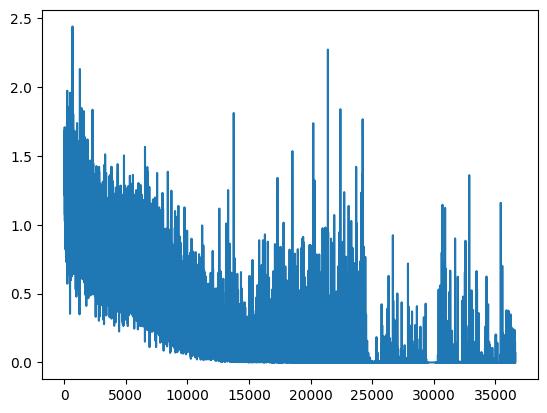

In [36]:
plt.plot(train_losses)

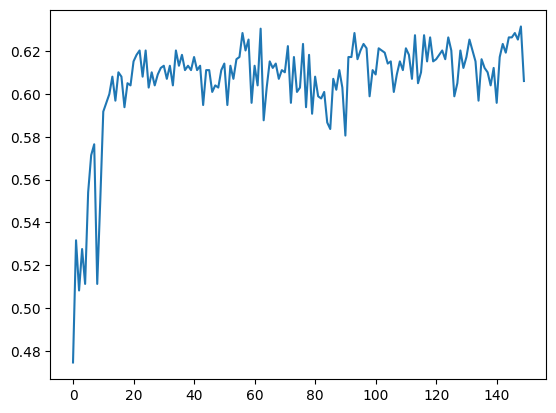

In [37]:
plt.plot(test_accuracy)

In [38]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc128_best_149epoch.pt
Correct: 619/976 (0.6342)
{'acc_detail': tensor([0.7244, 0.6620, 0.6457, 0.5079], device='cuda:0'),
 'acc_unweighted': tensor(0.6350, device='cuda:0'),
 'acc_weighted': tensor(0.6342, device='cuda:0'),
 'f1s_detail': tensor([0.7419, 0.5630, 0.6876, 0.5435], device='cuda:0'),
 'f1s_unweighted': tensor(0.6340, device='cuda:0'),
 'f1s_weighted': tensor(0.6370, device='cuda:0'),
 'precision_detail': tensor([0.7603, 0.4897, 0.7354, 0.5845], device='cuda:0'),
 'recall_detail': tensor([0.7244, 0.6620, 0.6457, 0.5079], device='cuda:0'),
 'rocauc': tensor(0.8531, device='cuda:0'),
 'rocauc_detail': tensor([0.9055, 0.8220, 0.8912, 0.7939], device='cuda:0'),
 'uar': tensor(0.6350, device='cuda:0'),
 'wap': tensor(0.6486, device='cuda:0')}


tensor([[184,  10,   8,  52],
        [ 13, 143,  33,  27],
        [  2,  76, 164,  12],
        [ 43,  63,  18, 128]], device='cuda:0')

In [39]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [48]:
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [49]:
from IConNet.visualizer import display_module

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



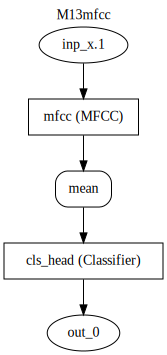

In [50]:
input_shape = (1,1,16000)
model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



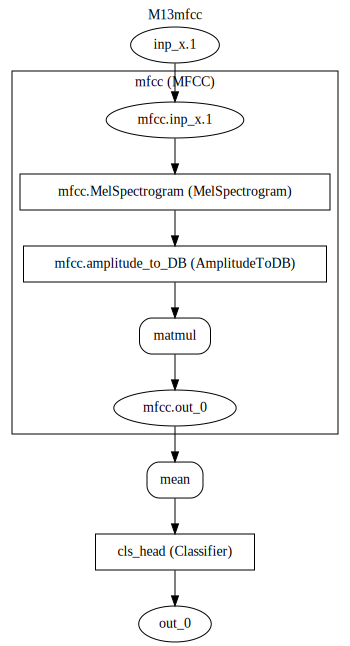

In [51]:
display_module(
    model, input, 
    classes_to_visit={"MFCC"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



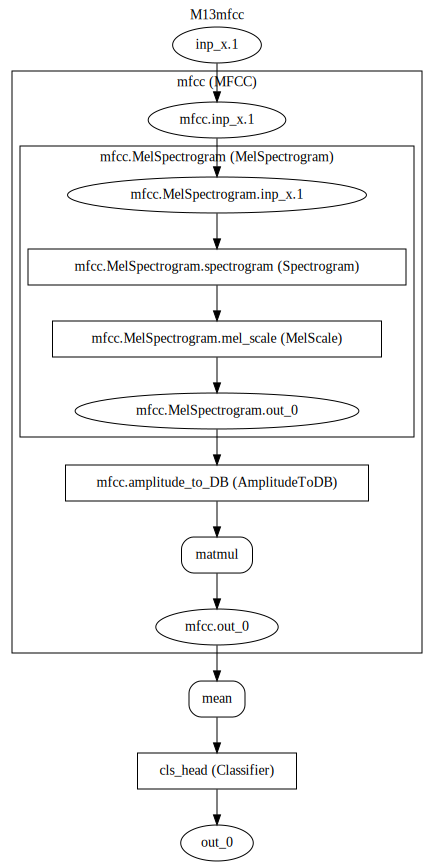

In [52]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



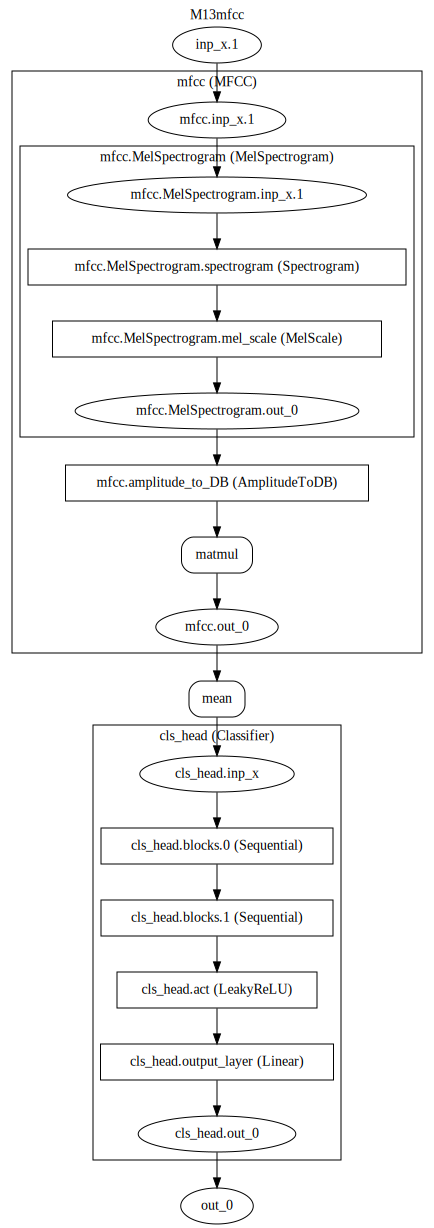

In [53]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram", "Classifier"})

In [ ]:
start_epoch = 151
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/50 [00:00<50:29, 60.60s/it]

Train Epoch: 151 [0/3918 (0%)]	Loss: 0.000002
Mem before-during-after: 20290560 20356096 22862336


  0%|                                   | 0.13770491803278687/50 [00:08<47:33, 57.23s/it]

Train Epoch: 151 [640/3918 (16%)]	Loss: 0.000002
Mem before-during-after: 22862336 23013376 22862336


  1%|▏                                  | 0.26885245901639304/50 [00:15<47:19, 57.10s/it]

Train Epoch: 151 [1280/3918 (33%)]	Loss: 0.000119
Mem before-during-after: 22862336 23013376 22862336


  1%|▎                                     | 0.39672131147541/50 [00:23<46:22, 56.09s/it]

Train Epoch: 151 [1920/3918 (49%)]	Loss: 0.000000
Mem before-during-after: 22862336 23013376 22862336


  1%|▍                                   | 0.5311475409836068/50 [00:31<48:27, 58.78s/it]

Train Epoch: 151 [2560/3918 (66%)]	Loss: 0.000036
Mem before-during-after: 22862336 23013376 22862336


  1%|▍                                   | 0.6622950819672118/50 [00:39<48:44, 59.28s/it]

Train Epoch: 151 [3200/3918 (82%)]	Loss: 0.000031
Mem before-during-after: 22862336 23013376 22862336


  2%|▌                                   | 0.7901639344262266/50 [00:46<47:04, 57.39s/it]

Train Epoch: 151 [3840/3918 (98%)]	Loss: 0.000001
Mem before-during-after: 22862336 23013376 22862336


  2%|▋                                   | 0.9999999999999944/50 [00:59<48:00, 58.79s/it]


Test Epoch: 151	Accuracy: 602/976 (61%)



  2%|▋                                   | 1.0065573770491747/50 [00:59<49:43, 60.90s/it]

Train Epoch: 152 [0/3918 (0%)]	Loss: 0.000019
Mem before-during-after: 22861312 23013376 22862336


  2%|▊                                   | 1.1377049180327796/50 [01:07<48:24, 59.45s/it]

Train Epoch: 152 [640/3918 (16%)]	Loss: 0.000001
Mem before-during-after: 22862336 23013376 22862336


  3%|▉                                   | 1.2688524590163845/50 [01:15<54:14, 66.79s/it]

Train Epoch: 152 [1280/3918 (33%)]	Loss: 0.000015
Mem before-during-after: 22862336 23013376 22862336


  3%|█                                   | 1.3999999999999895/50 [01:23<47:24, 58.53s/it]

Train Epoch: 152 [1920/3918 (49%)]	Loss: 0.000009
Mem before-during-after: 22862336 23013376 22862336


  3%|█                                   | 1.5311475409835944/50 [01:31<46:28, 57.53s/it]

Train Epoch: 152 [2560/3918 (66%)]	Loss: 0.000003
Mem before-during-after: 22862336 23013376 22862336


  3%|█▏                                  | 1.6590163934426092/50 [01:38<48:28, 60.17s/it]

Train Epoch: 152 [3200/3918 (82%)]	Loss: 0.000099
Mem before-during-after: 22862336 23013376 22862336


  4%|█▎                                  | 1.7901639344262141/50 [01:46<46:43, 58.15s/it]

Train Epoch: 152 [3840/3918 (98%)]	Loss: 0.000002
Mem before-during-after: 22862336 23013376 22862336


  4%|█▍                                   | 1.999999999999982/50 [01:58<46:10, 57.72s/it]


Test Epoch: 152	Accuracy: 608/976 (62%)



  4%|█▍                                  | 2.0065573770491625/50 [01:59<46:53, 58.63s/it]

Train Epoch: 153 [0/3918 (0%)]	Loss: 0.000072
Mem before-during-after: 22861312 23013376 22862336


  4%|█▌                                  | 2.1377049180327674/50 [02:07<46:52, 58.76s/it]

Train Epoch: 153 [640/3918 (16%)]	Loss: 0.000074
Mem before-during-after: 22862336 23013376 22862336


  5%|█▋                                  | 2.2688524590163723/50 [02:14<46:08, 58.01s/it]

Train Epoch: 153 [1280/3918 (33%)]	Loss: 0.000050
Mem before-during-after: 22862336 23013376 22862336


  5%|█▋                                  | 2.3999999999999773/50 [02:22<45:00, 56.74s/it]

Train Epoch: 153 [1920/3918 (49%)]	Loss: 0.000007
Mem before-during-after: 22862336 23013376 22862336


  5%|█▊                                   | 2.531147540983582/50 [02:29<46:22, 58.62s/it]

Train Epoch: 153 [2560/3918 (66%)]	Loss: 0.000016
Mem before-during-after: 22862336 23013376 22862336


  5%|█▉                                   | 2.659016393442597/50 [02:37<44:42, 56.66s/it]

Train Epoch: 153 [3200/3918 (82%)]	Loss: 0.000008
Mem before-during-after: 22862336 23013376 22862336


  6%|██                                   | 2.793442622950792/50 [02:44<44:45, 56.88s/it]

Train Epoch: 153 [3840/3918 (98%)]	Loss: 0.000002
Mem before-during-after: 22862336 23013376 22862336


  6%|██▎                                   | 3.00327868852456/50 [02:57<43:38, 55.71s/it]


Test Epoch: 153	Accuracy: 605/976 (62%)

Train Epoch: 154 [0/3918 (0%)]	Loss: 0.000005
Mem before-during-after: 22861312 23013376 22862336


  6%|██▎                                  | 3.137704918032755/50 [03:04<44:46, 57.32s/it]

Train Epoch: 154 [640/3918 (16%)]	Loss: 0.000004
Mem before-during-after: 22862336 23013376 22862336


  7%|██▍                                   | 3.26557377049177/50 [03:12<44:27, 57.09s/it]

Train Epoch: 154 [1280/3918 (33%)]	Loss: 0.000055
Mem before-during-after: 22862336 23013376 22862336


  7%|██▌                                  | 3.399999999999965/50 [03:20<44:25, 57.20s/it]

Train Epoch: 154 [1920/3918 (49%)]	Loss: 0.416753
Mem before-during-after: 22862336 23013376 22862336


  7%|██▌                                 | 3.5311475409835698/50 [03:27<44:02, 56.87s/it]

Train Epoch: 154 [2560/3918 (66%)]	Loss: 0.000009
Mem before-during-after: 22862336 23013376 22862336


  7%|██▋                                 | 3.6622950819671747/50 [03:35<44:23, 57.49s/it]

Train Epoch: 154 [3200/3918 (82%)]	Loss: 0.000022
Mem before-during-after: 22862336 23013376 22862336


  8%|██▋                                 | 3.7934426229507796/50 [03:42<44:32, 57.84s/it]

Train Epoch: 154 [3840/3918 (98%)]	Loss: 0.000033
Mem before-during-after: 22862336 23013376 22862336


  8%|██▉                                 | 4.0032786885245475/50 [03:54<43:16, 56.45s/it]


Test Epoch: 154	Accuracy: 614/976 (63%)

Train Epoch: 155 [0/3918 (0%)]	Loss: 0.000088
Mem before-during-after: 22861312 23013376 22862336


  8%|██▉                                 | 4.1377049180327425/50 [04:02<43:11, 56.52s/it]

Train Epoch: 155 [640/3918 (16%)]	Loss: 0.000007
Mem before-during-after: 22862336 23013376 22862336


  9%|███                                 | 4.2688524590163475/50 [04:10<43:08, 56.60s/it]

Train Epoch: 155 [1280/3918 (33%)]	Loss: 0.060830
Mem before-during-after: 22862336 23013376 22862336


  9%|███▏                                 | 4.370491803278641/50 [04:15<43:25, 57.10s/it]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [54]:
# del model
# del best_model
# gc.collect()

737